In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on February 28 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [54]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### unit test - z11

In [7]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

version of the code is: 0.20b
zmax: 11
-inf


In [8]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

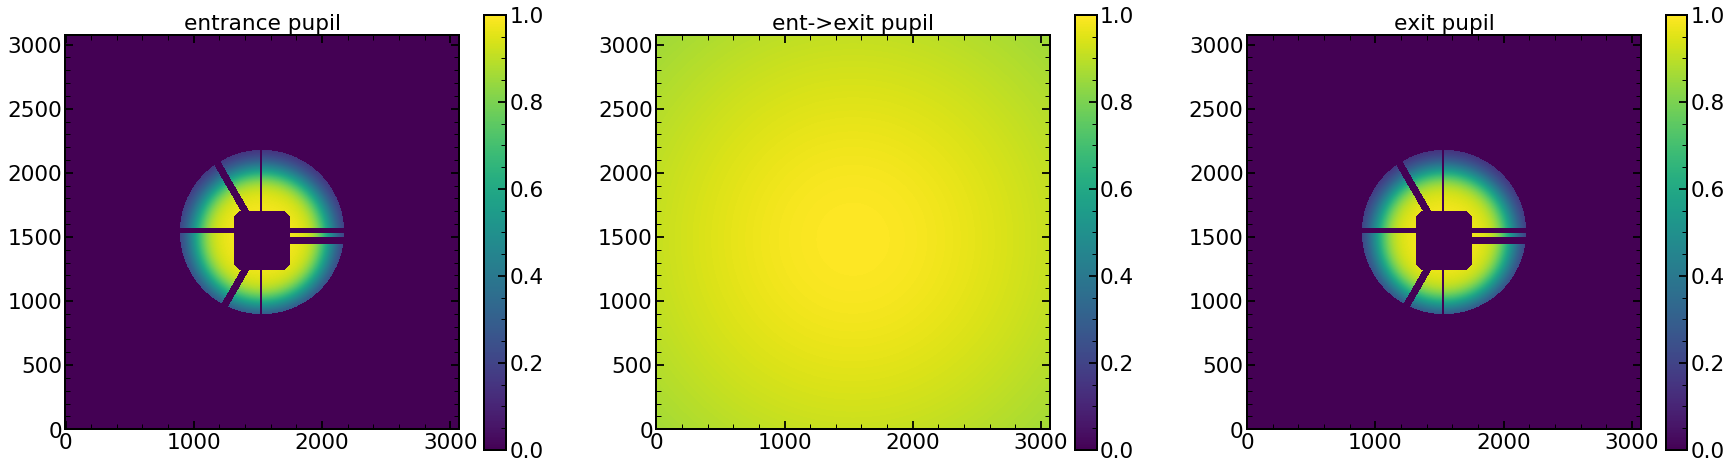

In [9]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

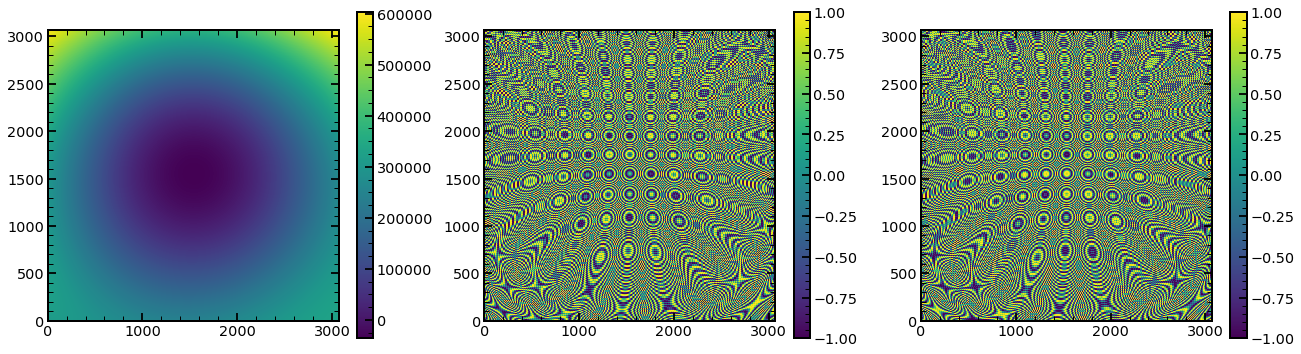

In [10]:
matplotlib.rcParams.update({'font.size': 12})

plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


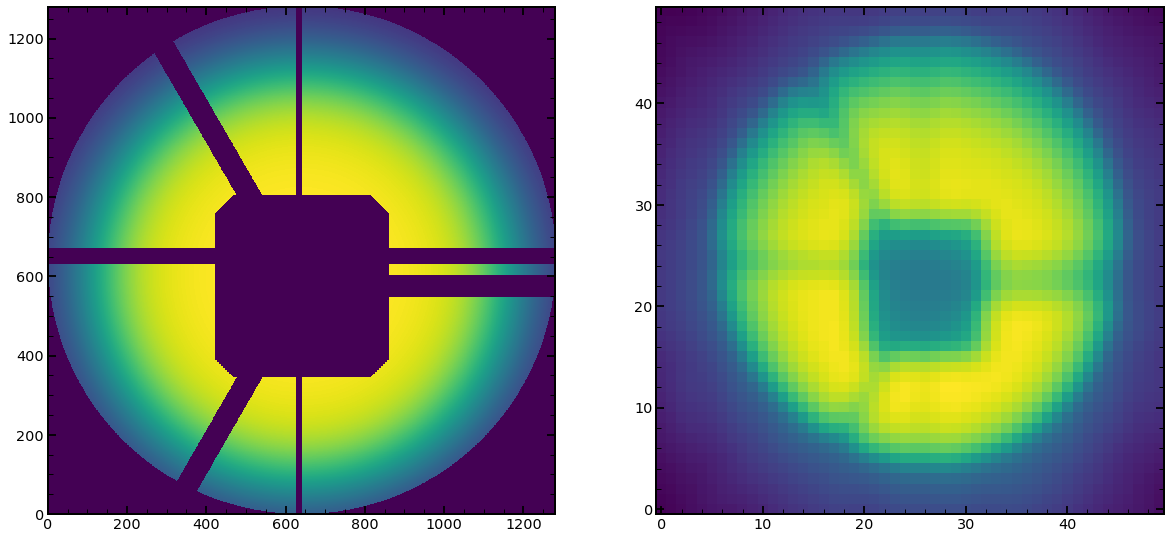

In [11]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

### unit test - z22

In [39]:
full_proposal=np.array([   25.46927509,    -0.02124209,    -1.04992786,     0.69853391,
          -0.0641416 ,     0.02247082,    -0.29192157,    -0.18292153,
           0.69976007,     0.08438785,     0.00028714,    -0.09023436,
           0.06347543,     0.01088842,     0.00008689,     0.51837526,
           0.9760724 ,     0.83827641,    -0.02061162,    -0.06103453,
           0.82536987,     0.08903461,     0.69209871,     1.04051888,
          -0.04201478, 90682.83733571,     2.58159004,     0.00378112,
           0.48956584,     1.81188317,     0.99545856,0,0])
    
    
# do analysis with up to 22 or 11 zernike - need to modify for this code
'''
if zmax==22:    
    allparameters_proposal=results_of_fit_many_interpolation_preDecemberrun[labelInput].loc[int(single_number)].values[:len(columns22)]
else:
    full_proposal=results_of_fit_many_interpolation_preDecemberrun[labelInput].loc[int(single_number)].values
    # select z4-z11, skip to z22 and join everything else
    allparameters_proposal=np.concatenate((full_proposal[0:8],[0,0,0,0,0,0,0,0,0,0,0],full_proposal[8:-2]))
  '''
allparameters_proposal=np.concatenate((full_proposal[0:8],[0,0,0,0,0,0,0,0,0,0,0],full_proposal[8:-2]))
# not sure, but I guess to protect it from chaning?
allparameters_proposal_direct_22=np.copy(allparameters_proposal) 

In [40]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.5,0,0,0,0,0,0,0,0,0,0.99,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,zmax=22)  

#res=model(allparameters_proposal)
res=model(allparameters_proposal_direct_22)
print(res)

version of the code is: 0.20b
zmax: 22
-2755.1738190744613


In [35]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

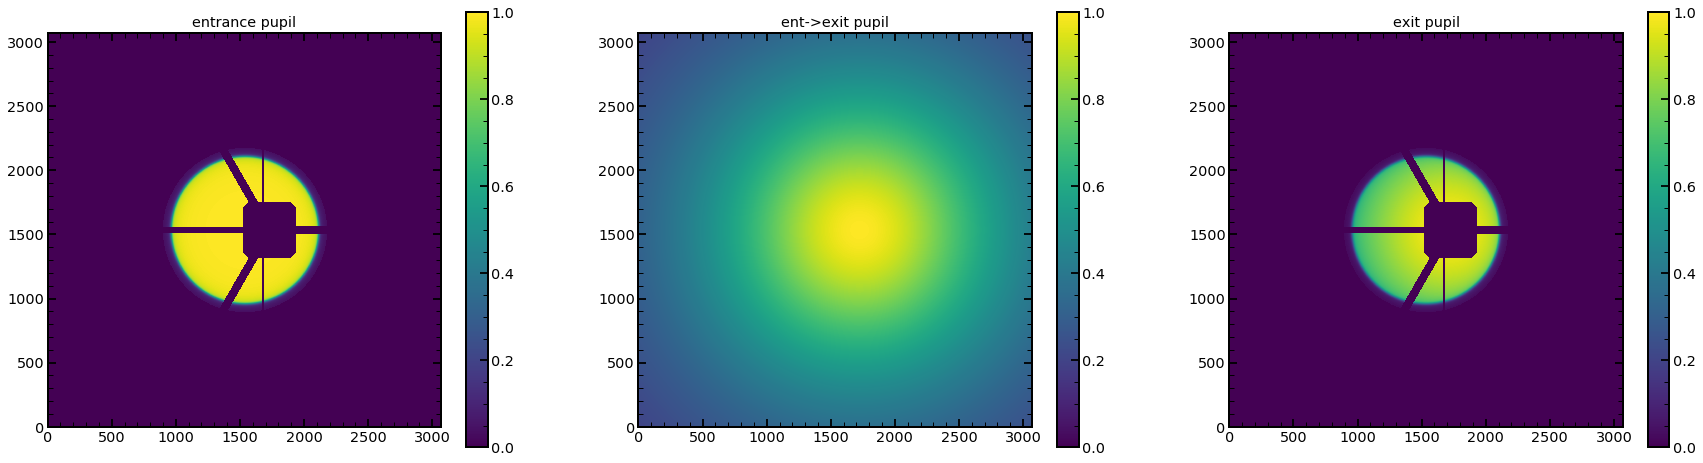

In [36]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

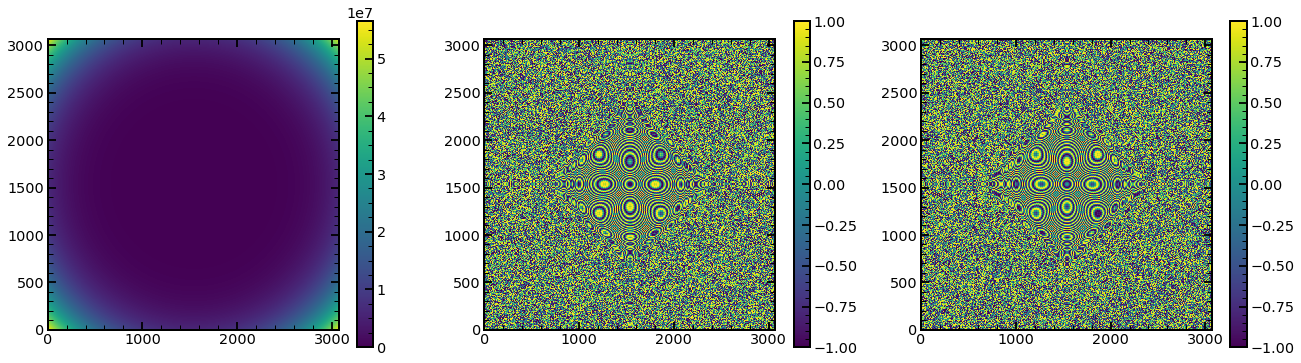

In [37]:
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

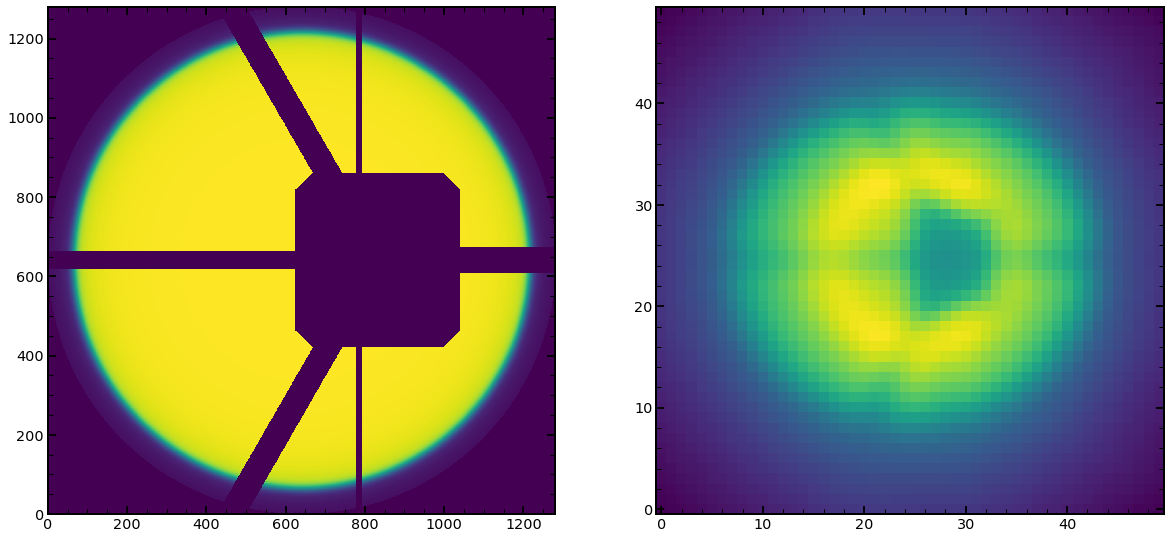

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Feb28

## Codes

In [12]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns11=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns11_analysis=columns+['chi2','chi2max']

columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

In [13]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            if step==0:
                step=10e-17
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        #print(minchain_err_test)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [14]:
def create_results_of_fit_single(date,single_number,arc=None,zMax=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
    if zMax==22:
        columns_analysis=columns22_analysis
    else:
        columns_analysis=columns11_analysis
    
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper


def create_results_of_fit_single_focus(date,single_number,arc=None,zMax=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([8576,8579,8582,8585,8588,8591,8594,8597])
    elif arc=='Ne':
        obs_possibilites=np.array([8576,8579,8582,8585,8588,8591,8594,8597])+90
        
    if zMax==22:
        columns_analysis=columns22_analysis
        
    labels=['8576','8579','8582','8585','8588','8591','8594','8597']
    results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [15]:
def solution_at_0_and_plots(date,single_number,arc,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=True,zMax=None):
    """create solution at the focus and plot dependence with defocu

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
  
    """    
    
    if zMax==22:
        columns_analysis=columns22_analysis
        columns=columns22
        z_addition_factor=11
    else:
        columns_analysis=columns11_analysis
        columns=columns11
        z_addition_factor=0
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=6:
        if zMax==22:
            solution_at_0=np.full(31+11,0)

        else:
            solution_at_0=np.full(31,0)       

        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:

            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr)
            #print(z4_arr_err)
            #print(z4_arr_err_up)
            #print(z4_arr_err_low)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]
            #print(q)
            #print(index_arr_no0)
            #print(z4_arr_no0)
            #print(z4_arr_no0_err)
            #print(z4_arr_no0_err_up)
            #print(z4_arr_no0_err_low)
            
            
            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]

            
            if q in columns[:8+z_addition_factor]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largest deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    #print('good_index'+str(np.delete(index_arr_no0,l)))
                    #print('index_arr_no0'+str(np.delete(z4_arr_no0,l)))
                    #print('z4_arr_no0_err_low'+str(np.delete(z4_arr_no0_err_low,l)))
                    #print('z4_arr_no0_err_up'+str(np.delete(z4_arr_no0_err_up,l)))
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print('good_index'+str(good_index))
                #print('index_arr_no0'+str(index_arr_no0))
                #print('z4_arr_no0_err_low'+str(z4_arr_no0_err_low))
                #print('z4_arr_no0_err_up'+str(z4_arr_no0_err_up))
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                #print(popt)
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8+z_addition_factor:25+z_addition_factor]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                third_max_dif=np.sort(interim_zero_solutions_arr_dif)[-3]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<=(third_max_dif*1.1)]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25+z_addition_factor:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######
            #print(q)
            #print(fit_res)
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            #print('prediction for focus: '+str(q)+' '+str(fit_res[9]))
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(arc)+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(arc)+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

## Scripts

### First script

In [16]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl', 'rb') as f:
    finalHgAr_Feb2019=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalNe_Feb2019.pkl', 'rb') as f:
    finalNe_Feb2019=pickle.load(f)

In [25]:
list_of_HgAr_to_analyze_all=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=10)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=5)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
list_of_HgAr_to_not_analyze_2_3=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=3)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_HgAr_to_analyze=np.setdiff1d(list_of_HgAr_to_analyze_all,list_of_HgAr_to_not_analyze_2_3)
print(len(list_of_HgAr_to_analyze))


list_of_Ne_to_analyze_all=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=10)&(finalNe_Feb2019['fiber'].values.astype(int)>=5)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
list_of_Ne_to_not_analyze_2_3=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=3)&(finalNe_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_Ne_to_analyze=np.setdiff1d(list_of_Ne_to_analyze_all,list_of_Ne_to_not_analyze_2_3)
print(len(list_of_Ne_to_analyze))


30
24


In [32]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [11790,11730,11748,11694,11754,11706,11766,11796,11736,11724,11784]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Feb.sh \n')

file.close()

In [33]:
#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T07S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [12397,12313,12355,12349,12361,12337,12373,12403,12307,12319,12391]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger07'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T07S'+str(single_spot)+'Feb.sh \n')

file.close()

### Second script

In [165]:
list_of_HgAr_to_analyze_all=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=15)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=11)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
list_of_HgAr_to_not_analyze_2_3=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=3)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_HgAr_to_analyze=np.setdiff1d(list_of_HgAr_to_analyze_all,list_of_HgAr_to_not_analyze_2_3)
print(len(list_of_HgAr_to_analyze))


list_of_Ne_to_analyze_all=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=15)&(finalNe_Feb2019['fiber'].values.astype(int)>=11)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
list_of_Ne_to_not_analyze_2_3=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=3)&(finalNe_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_Ne_to_analyze=np.setdiff1d(list_of_Ne_to_analyze_all,list_of_Ne_to_not_analyze_2_3)
print(len(list_of_Ne_to_analyze))


25
20


In [166]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [11790,11730,11748,11694,11754,11706,11766,11796,11736,11724,11784]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Feb.sh \n')

file.close()

In [167]:
#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T07S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [12397,12313,12355,12349,12361,12337,12373,12403,12307,12319,12391]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger07'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T07S'+str(single_spot)+'Feb.sh \n')

file.close()

### Third script

In [126]:
list_of_HgAr_to_analyze_all=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=4)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=0)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
list_of_HgAr_to_not_analyze_2_3=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=3)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_HgAr_to_analyze=np.setdiff1d(list_of_HgAr_to_analyze_all,list_of_HgAr_to_not_analyze_2_3)
print(len(list_of_HgAr_to_analyze))


list_of_Ne_to_analyze_all=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=4)&(finalNe_Feb2019['fiber'].values.astype(int)>=0)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
list_of_Ne_to_not_analyze_2_3=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=3)&(finalNe_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)]
# remove the spots from fibers 2 and 3 as they are too close together
list_of_Ne_to_analyze=np.setdiff1d(list_of_Ne_to_analyze_all,list_of_Ne_to_not_analyze_2_3)
print(len(list_of_Ne_to_analyze))


15
12


In [127]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [11790,11730,11748,11694,11754,11706,11766,11796,11736,11724,11784]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Feb.sh \n')

file.close()

In [128]:
#MPI
for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T07S'+str(single_spot)+'Feb.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [12397,12313,12355,12349,12361,12337,12373,12403,12307,12319,12391]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02.py "+str(obs)+" "+str(single_spot)+" 35 5 Ne\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger07'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T07S'+str(single_spot)+'Feb.sh \n')

file.close()

In [164]:
list_of_HgAr_to_analyze_all

Int64Index([133, 135, 138, 141, 143, 145, 147, 150, 153, 155, 157, 159, 162,
            165, 167, 169, 171, 174, 177, 179, 181, 183, 186, 189, 191],
           dtype='int64')

In [163]:
list_of_HgAr_to_analyze_all[22]

186

## Looking at the single image

In [184]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl', 'rb') as f:
    finalHgAr_Feb2019=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalNe_Feb2019.pkl', 'rb') as f:
    finalNe_Feb2019=pickle.load(f)
    
    
date='Feb28'
obs=11736
single_number='186'
image_index=int(single_number)
eps=5
arc='HgAr'


STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=11748
elif arc=="Ne":
    single_number_focus=11748+607    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
elif arc=='Ne':
    obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr_Feb2019
elif arc=="Ne":
    finalArc=finalNe_Feb2019    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

p4


fiber                          15
xc                           3835
yc                           2002
wavelength               795.0522
close                           1
lamp                         HgAr
xc_effective                 3904
old_index_approx              114
superold_index_approx        59.0
Name: 186, dtype: object

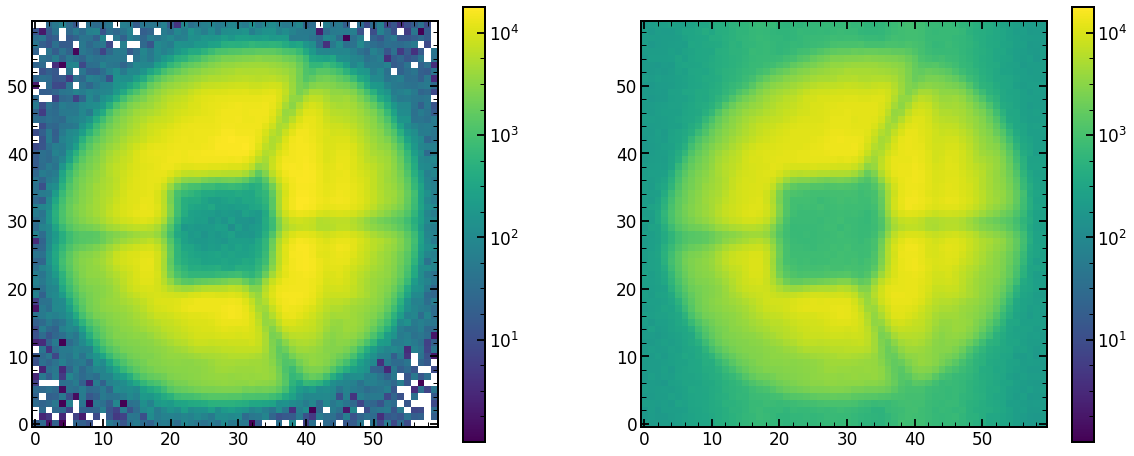

In [185]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [186]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 86582.49287064277
minimal chi2 reduced is: 48.096327392187376


In [187]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
    
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)


(31,)
          z4        z5        z6        z7        z8        z9       z10  \
0 -33.667705 -1.435051  0.599255 -0.542302 -0.401074  0.040933 -0.210222   

        z11  
0 -0.063496  
    hscFrac  strutFrac   dxFocal  dyFocal  slitFrac  slitFrac_dy  \
0  0.666679    0.08253  0.140585  0.05657  0.058419     0.055748   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.177752             0.432183  1.214036  1.467738  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.007415 -0.036421                       0.842485   0.131166   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.327941  0.967816           -0.582102  111227.802219   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.514895              0.005225      0.407259  1.809344  1.002074  


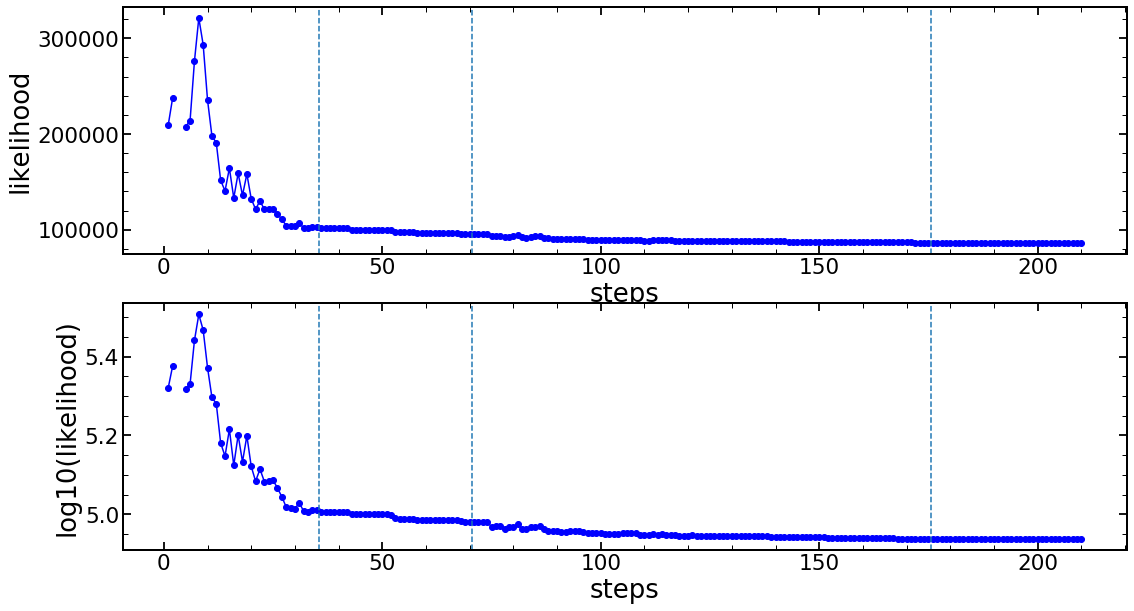

In [188]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [189]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=11)   
       
model(minchain)

zmax: 11


-86582.49287064275

In [190]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

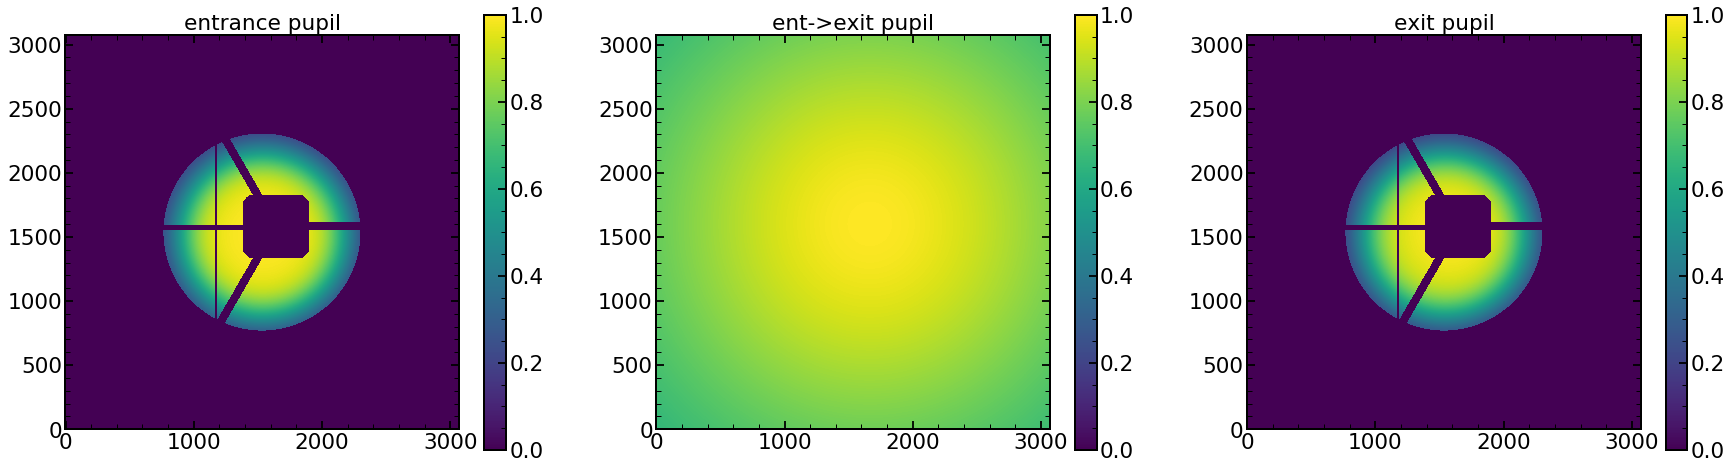

In [191]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

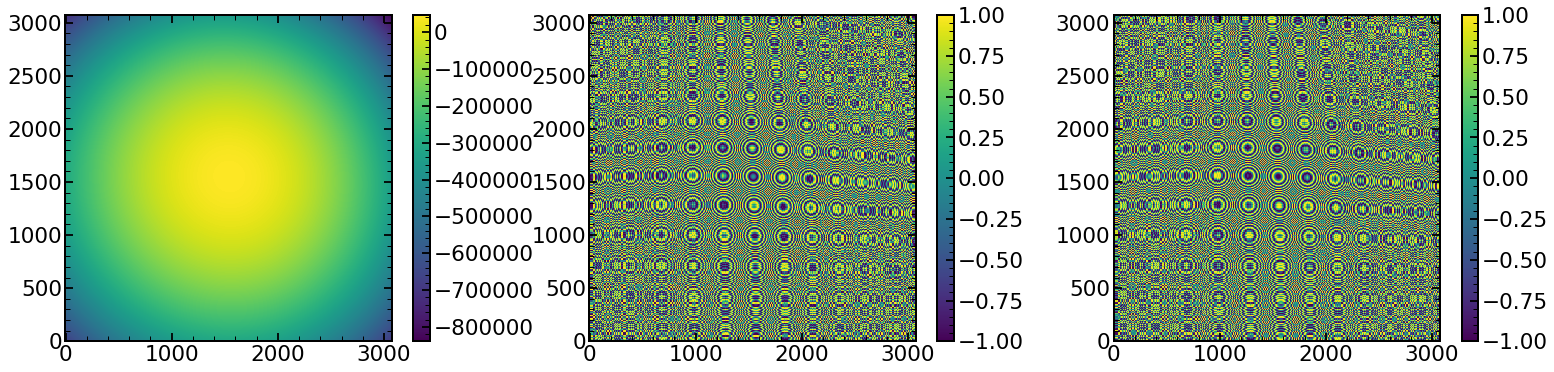

In [192]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

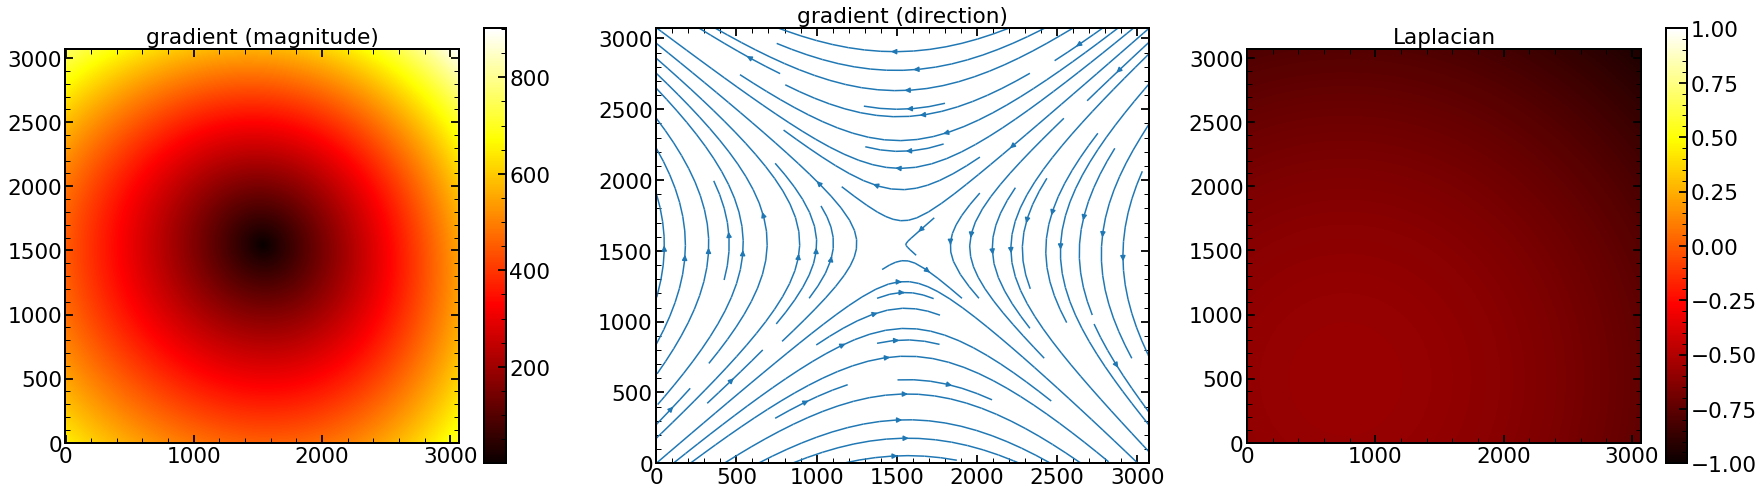

In [193]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

Text(0.5,1,'Residual')

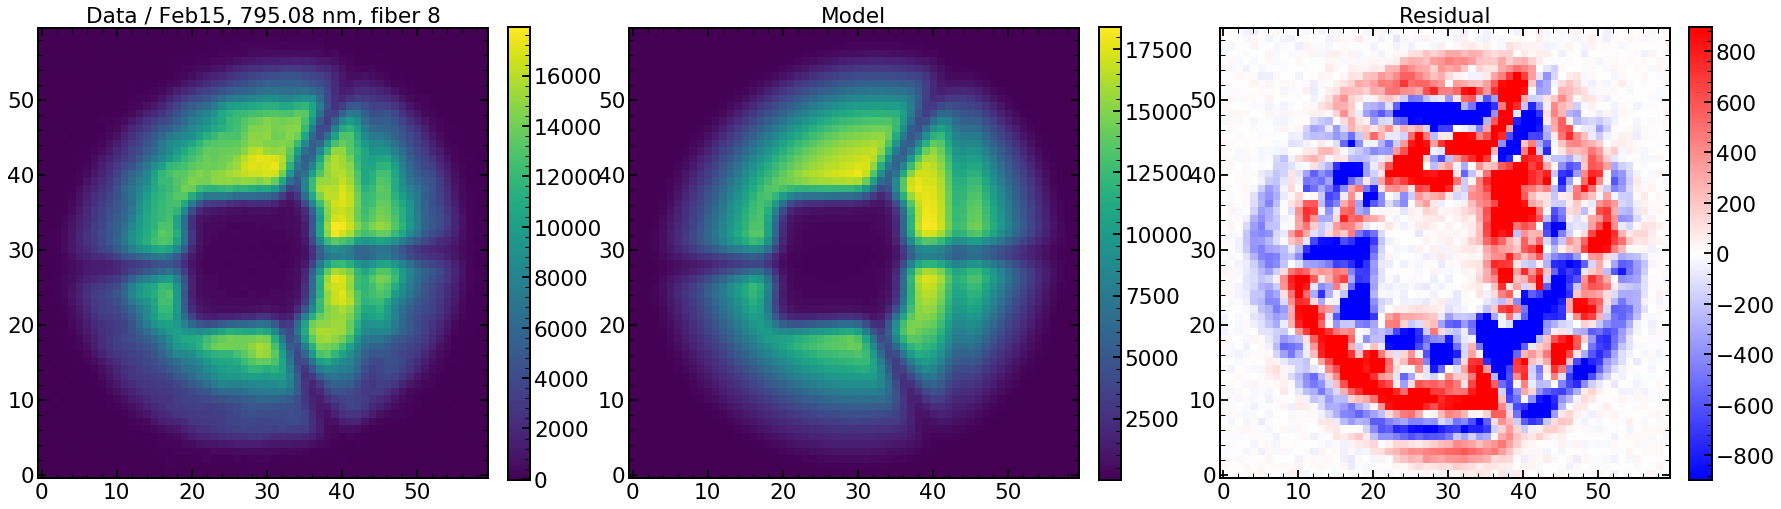

In [194]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / Feb15, 795.08 nm, fiber 8')
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=np.max(res_iapetus))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(res_iapetus-sci_image,vmin=-np.max(sci_image)/20,vmax=np.max(sci_image)/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

chi**2 reduced is: 48.09632724725395
Abs of residual divided by total flux is: 0.08029712604633221
Abs of residual divided by largest value of a flux in the image is: 0.15581570091116465


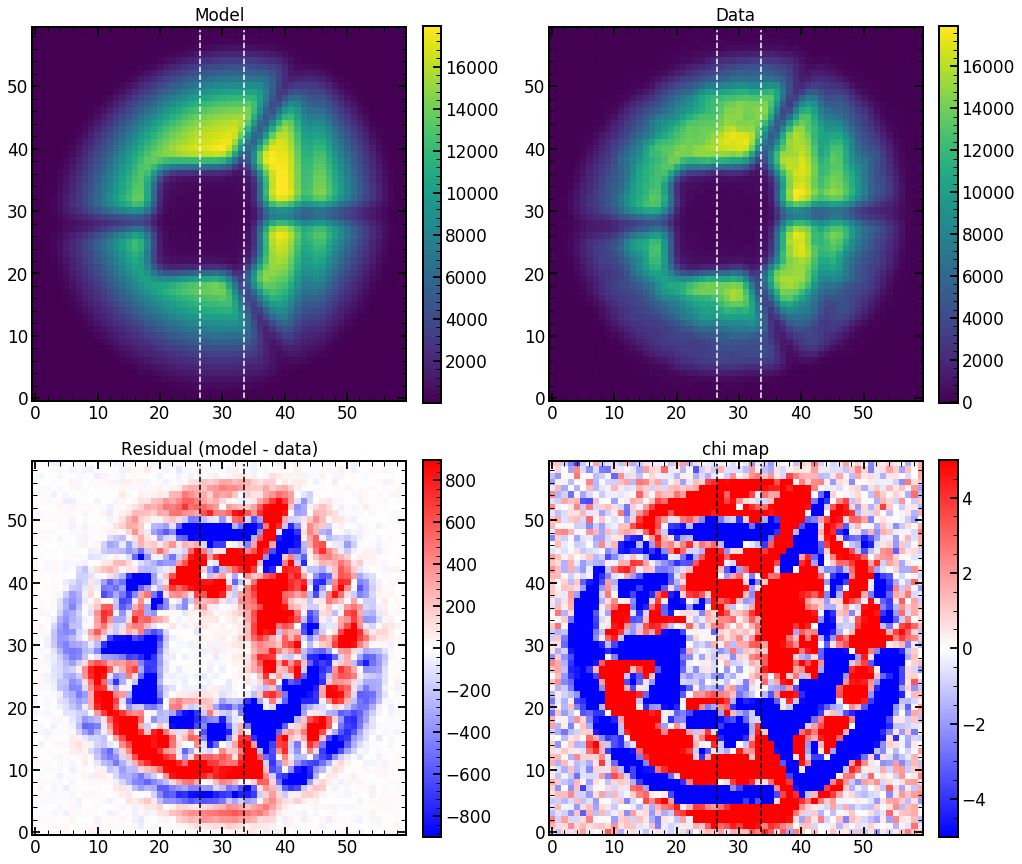

In [195]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

48.09632724725395
chi**2 reduced is: 48.09632724725395
Abs of residual divided by total flux is: 0.08029712604633221
Abs of residual divided by largest value of a flux in the image is: 0.15581570091116465


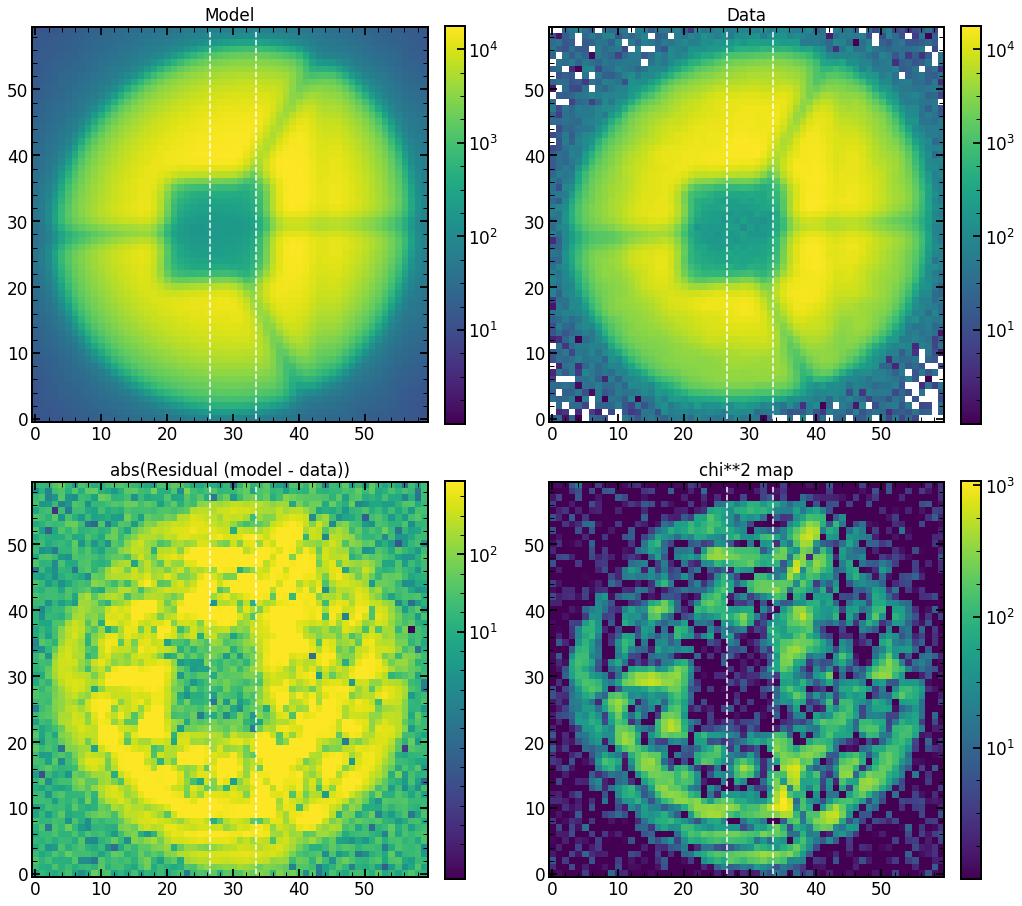

In [199]:
single_analysis.create_basic_comparison_plot_log()

48.09632724725395
chi**2 reduced is: 48.09632724725395
Abs of residual divided by total flux is: 0.08029712604633221
Abs of residual divided by largest value of a flux in the image is: 0.15581570091116465


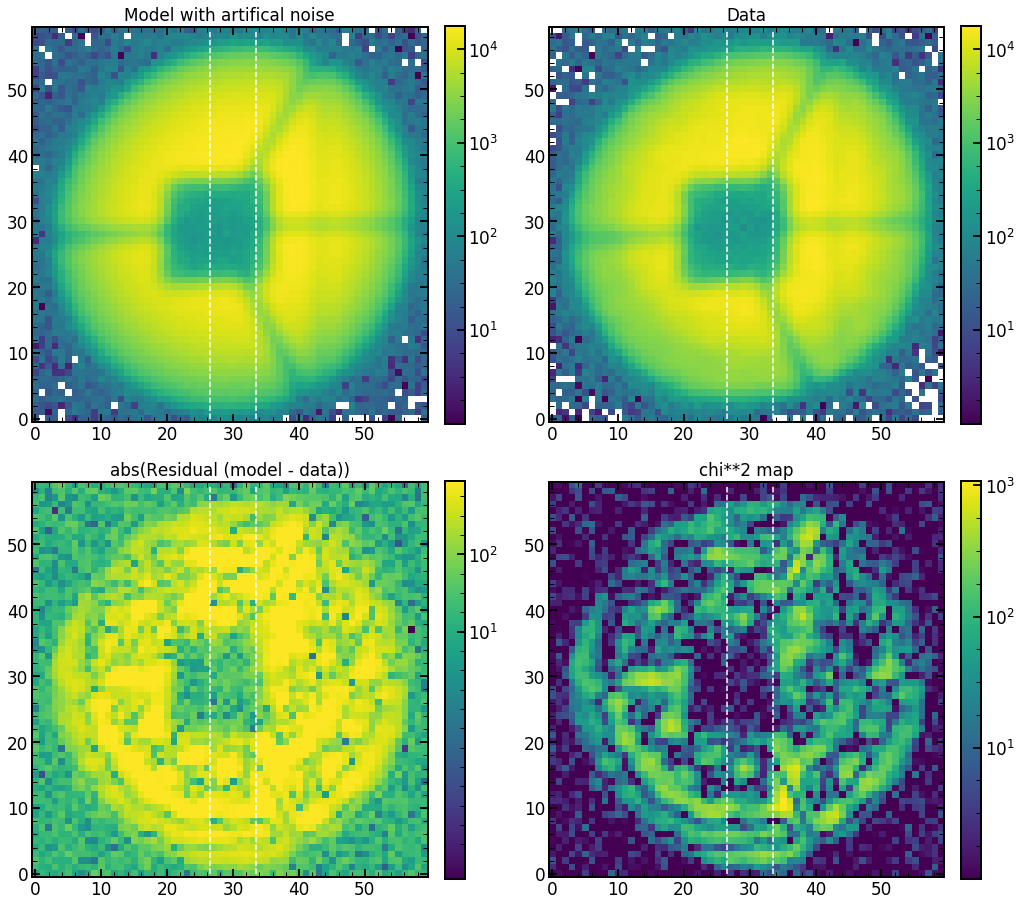

In [200]:
single_analysis.create_basic_comparison_plot_log_artifical()

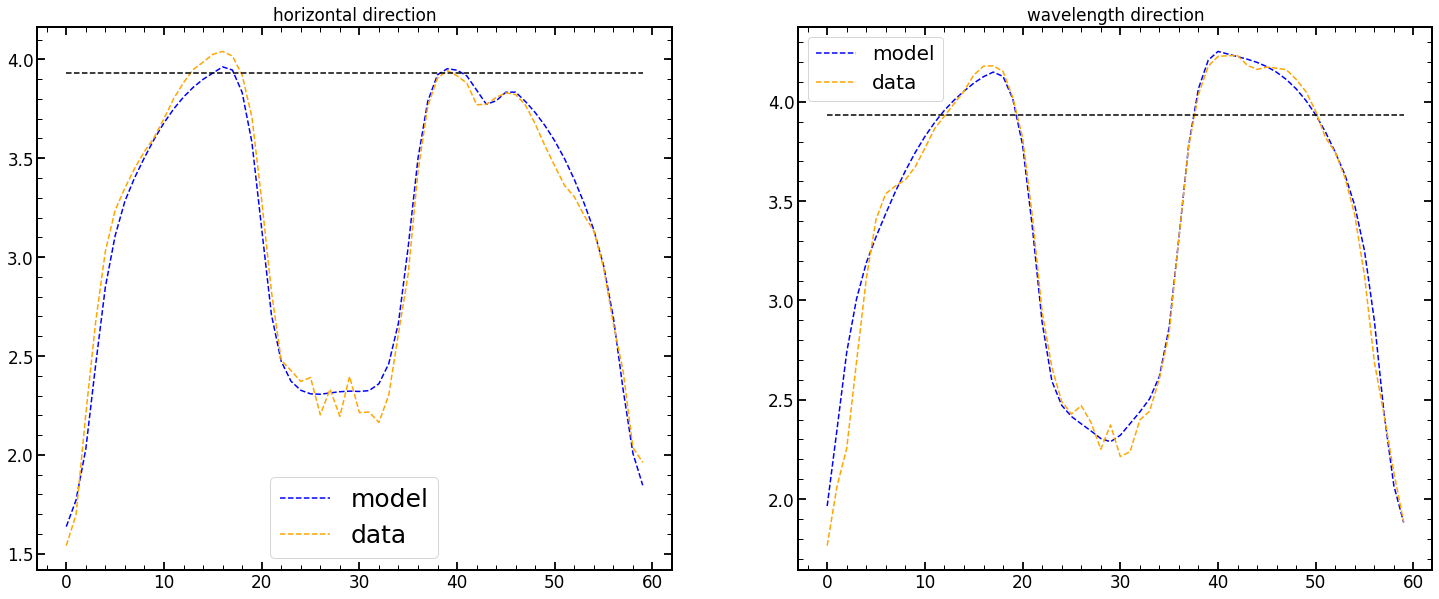

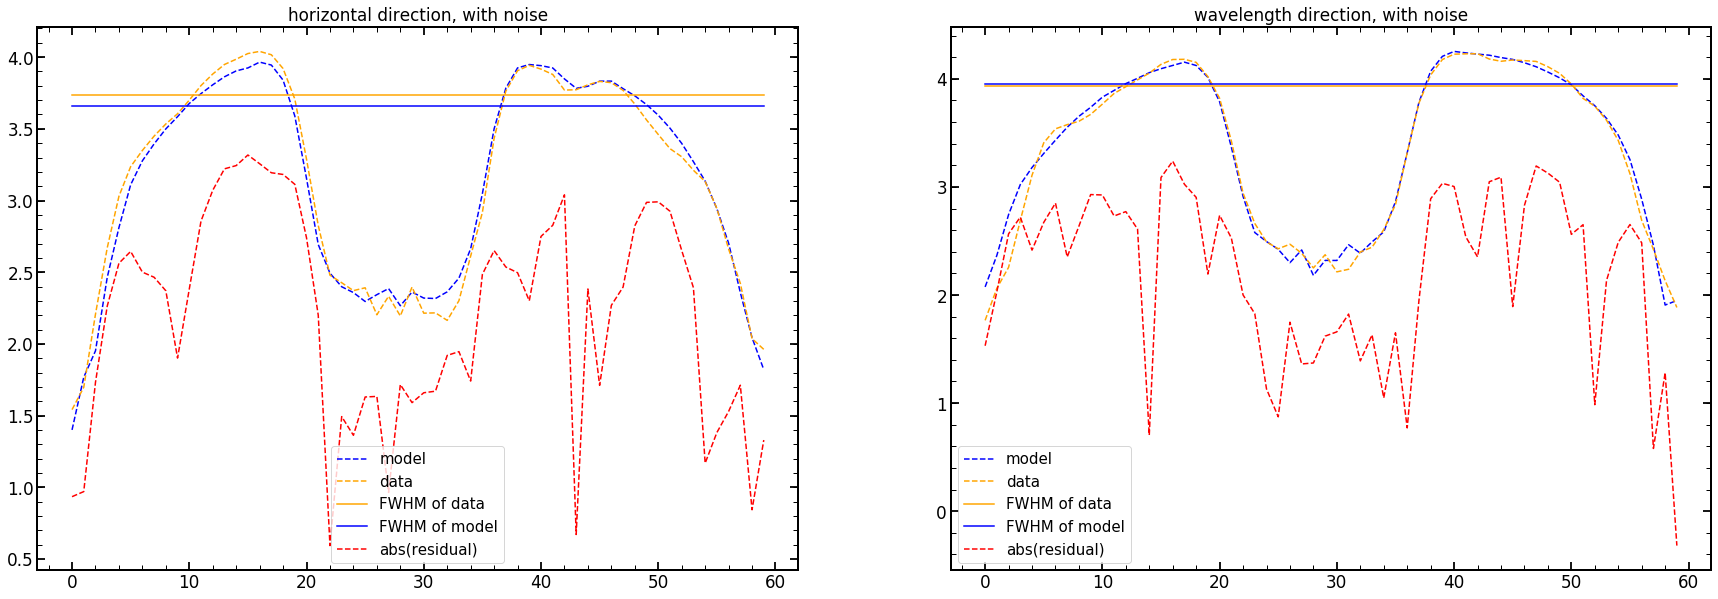

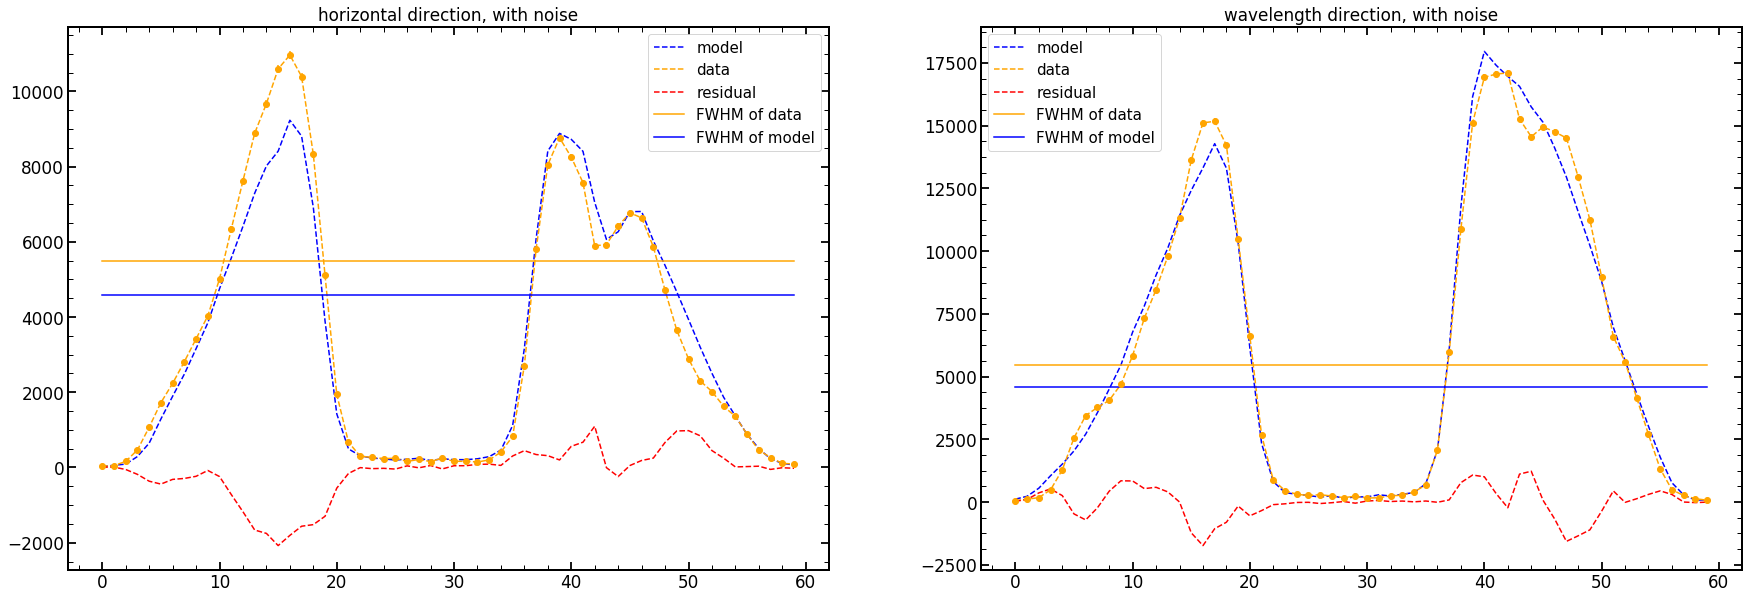

In [201]:
single_analysis.create_cut_plots()

## Core analysis 

### Defocus plots 

In [49]:
for i in tqdm(range(len(finalHgAr_Feb2019))):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Feb15',i,'HgAr',11)
    solution_at_0=solution_at_0_and_plots('Feb15',i,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,'True',11)

  0%|          | 0/192 [00:00<?, ?it/s]

11
0 11796 HgAr is NOT found or failed!
0 11790 HgAr is NOT found or failed!
0 11784 HgAr is NOT found or failed!
0 11778 HgAr is NOT found or failed!
0 11772 HgAr is NOT found or failed!
0 11766 HgAr is NOT found or failed!
0 11760 HgAr is NOT found or failed!
0 11754 HgAr is NOT found or failed!
0 11748 HgAr is NOT found or failed!
0 11748 HgAr is NOT found or failed!
0 11694 HgAr is NOT found or failed!
0 11700 HgAr is NOT found or failed!
0 11706 HgAr is NOT found or failed!
0 11712 HgAr is NOT found or failed!
0 11718 HgAr is NOT found or failed!
0 11724 HgAr is NOT found or failed!
0 11730 HgAr is NOT found or failed!
0 11736 HgAr is NOT found or failed!
11
1 11796 HgAr is NOT found or failed!
1 11790 HgAr is NOT found or failed!
1 11784 HgAr is NOT found or failed!
1 11778 HgAr is NOT found or failed!
1 11772 HgAr is NOT found or failed!
1 11766 HgAr is NOT found or failed!
1 obs (Emcee3): 11760 is found!
1 obs (Emcee3): 11754 is found!
1 obs (Emcee3): 11748 is found!
1 obs (Emc

  1%|          | 2/192 [00:16<26:44,  8.44s/it]

11
2 11796 HgAr is NOT found or failed!
2 11790 HgAr is NOT found or failed!
2 11784 HgAr is NOT found or failed!
2 11778 HgAr is NOT found or failed!
2 11772 HgAr is NOT found or failed!
2 11766 HgAr is NOT found or failed!
2 11760 HgAr is NOT found or failed!
2 11754 HgAr is NOT found or failed!
2 11748 HgAr is NOT found or failed!
2 11748 HgAr is NOT found or failed!
2 11694 HgAr is NOT found or failed!
2 11700 HgAr is NOT found or failed!
2 11706 HgAr is NOT found or failed!
2 11712 HgAr is NOT found or failed!
2 11718 HgAr is NOT found or failed!
2 11724 HgAr is NOT found or failed!
2 11730 HgAr is NOT found or failed!
2 11736 HgAr is NOT found or failed!
11
3 obs (Emcee3): 11796 is found!
3 obs (Emcee3): 11790 is found!
3 obs (Emcee3): 11784 is found!
3 11778 HgAr is NOT found or failed!
3 11772 HgAr is NOT found or failed!
3 11766 HgAr is NOT found or failed!
3 obs (Emcee3): 11760 is found!
3 obs (Emcee3): 11754 is found!
3 obs (Emcee3): 11748 is found!
3 obs (Emcee3): 11748 is 

  2%|▏         | 4/192 [00:35<27:52,  8.90s/it]

11
4 11796 HgAr is NOT found or failed!
4 11790 HgAr is NOT found or failed!
4 11784 HgAr is NOT found or failed!
4 11778 HgAr is NOT found or failed!
4 11772 HgAr is NOT found or failed!
4 11766 HgAr is NOT found or failed!
4 11760 HgAr is NOT found or failed!
4 11754 HgAr is NOT found or failed!
4 11748 HgAr is NOT found or failed!
4 11748 HgAr is NOT found or failed!
4 11694 HgAr is NOT found or failed!
4 11700 HgAr is NOT found or failed!
4 11706 HgAr is NOT found or failed!
4 11712 HgAr is NOT found or failed!
4 11718 HgAr is NOT found or failed!
4 11724 HgAr is NOT found or failed!
4 11730 HgAr is NOT found or failed!
4 11736 HgAr is NOT found or failed!
11
5 11796 HgAr is NOT found or failed!
5 11790 HgAr is NOT found or failed!
5 11784 HgAr is NOT found or failed!
5 11778 HgAr is NOT found or failed!
5 11772 HgAr is NOT found or failed!
5 11766 HgAr is NOT found or failed!
5 11760 HgAr is NOT found or failed!
5 11754 HgAr is NOT found or failed!
5 11748 HgAr is NOT found or fai

  4%|▎         | 7/192 [00:56<24:49,  8.05s/it]

11
7 11796 HgAr is NOT found or failed!
7 11790 HgAr is NOT found or failed!
7 11784 HgAr is NOT found or failed!
7 11778 HgAr is NOT found or failed!
7 11772 HgAr is NOT found or failed!
7 11766 HgAr is NOT found or failed!
7 11760 HgAr is NOT found or failed!
7 11754 HgAr is NOT found or failed!
7 11748 HgAr is NOT found or failed!
7 11748 HgAr is NOT found or failed!
7 11694 HgAr is NOT found or failed!
7 11700 HgAr is NOT found or failed!
7 11706 HgAr is NOT found or failed!
7 11712 HgAr is NOT found or failed!
7 11718 HgAr is NOT found or failed!
7 11724 HgAr is NOT found or failed!
7 11730 HgAr is NOT found or failed!
7 11736 HgAr is NOT found or failed!
11
8 11796 HgAr is NOT found or failed!
8 11790 HgAr is NOT found or failed!
8 11784 HgAr is NOT found or failed!
8 11778 HgAr is NOT found or failed!
8 11772 HgAr is NOT found or failed!
8 11766 HgAr is NOT found or failed!
8 11760 HgAr is NOT found or failed!
8 11754 HgAr is NOT found or failed!
8 11748 HgAr is NOT found or fai

  5%|▌         | 10/192 [01:16<23:05,  7.61s/it]

11
10 11796 HgAr is NOT found or failed!
10 11790 HgAr is NOT found or failed!
10 11784 HgAr is NOT found or failed!
10 11778 HgAr is NOT found or failed!
10 11772 HgAr is NOT found or failed!
10 11766 HgAr is NOT found or failed!
10 11760 HgAr is NOT found or failed!
10 11754 HgAr is NOT found or failed!
10 11748 HgAr is NOT found or failed!
10 11748 HgAr is NOT found or failed!
10 11694 HgAr is NOT found or failed!
10 11700 HgAr is NOT found or failed!
10 11706 HgAr is NOT found or failed!
10 11712 HgAr is NOT found or failed!
10 11718 HgAr is NOT found or failed!
10 11724 HgAr is NOT found or failed!
10 11730 HgAr is NOT found or failed!
10 11736 HgAr is NOT found or failed!
11
11 obs (Emcee3): 11796 is found!
11 obs (Emcee3): 11790 is found!
11 obs (Emcee3): 11784 is found!
11 11778 HgAr is NOT found or failed!
11 11772 HgAr is NOT found or failed!
11 11766 HgAr is NOT found or failed!
11 obs (Emcee3): 11760 is found!
11 obs (Emcee3): 11754 is found!
11 obs (Emcee3): 11748 is found

  6%|▋         | 12/192 [01:35<23:46,  7.92s/it]

11
12 11796 HgAr is NOT found or failed!
12 11790 HgAr is NOT found or failed!
12 11784 HgAr is NOT found or failed!
12 11778 HgAr is NOT found or failed!
12 11772 HgAr is NOT found or failed!
12 11766 HgAr is NOT found or failed!
12 11760 HgAr is NOT found or failed!
12 11754 HgAr is NOT found or failed!
12 11748 HgAr is NOT found or failed!
12 11748 HgAr is NOT found or failed!
12 11694 HgAr is NOT found or failed!
12 11700 HgAr is NOT found or failed!
12 11706 HgAr is NOT found or failed!
12 11712 HgAr is NOT found or failed!
12 11718 HgAr is NOT found or failed!
12 11724 HgAr is NOT found or failed!
12 11730 HgAr is NOT found or failed!
12 11736 HgAr is NOT found or failed!
11
13 obs (Emcee3): 11796 is found!
13 obs (Emcee3): 11790 is found!
13 obs (Emcee3): 11784 is found!
13 11778 HgAr is NOT found or failed!
13 11772 HgAr is NOT found or failed!
13 11766 HgAr is NOT found or failed!
13 obs (Emcee3): 11760 is found!
13 obs (Emcee3): 11754 is found!
13 11748 HgAr is NOT found or f

  7%|▋         | 14/192 [01:53<24:08,  8.14s/it]

11
14 11796 HgAr is NOT found or failed!
14 11790 HgAr is NOT found or failed!
14 11784 HgAr is NOT found or failed!
14 11778 HgAr is NOT found or failed!
14 11772 HgAr is NOT found or failed!
14 11766 HgAr is NOT found or failed!
14 11760 HgAr is NOT found or failed!
14 11754 HgAr is NOT found or failed!
14 11748 HgAr is NOT found or failed!
14 11748 HgAr is NOT found or failed!
14 11694 HgAr is NOT found or failed!
14 11700 HgAr is NOT found or failed!
14 11706 HgAr is NOT found or failed!
14 11712 HgAr is NOT found or failed!
14 11718 HgAr is NOT found or failed!
14 11724 HgAr is NOT found or failed!
14 11730 HgAr is NOT found or failed!
14 11736 HgAr is NOT found or failed!
11
15 obs (Emcee3): 11796 is found!
15 obs (Emcee3): 11790 is found!
15 obs (Emcee3): 11784 is found!
15 11778 HgAr is NOT found or failed!
15 11772 HgAr is NOT found or failed!
15 11766 HgAr is NOT found or failed!
15 obs (Emcee3): 11760 is found!
15 obs (Emcee3): 11754 is found!
15 obs (Emcee3): 11748 is found

  8%|▊         | 16/192 [02:12<24:20,  8.30s/it]

11
16 11796 HgAr is NOT found or failed!
16 11790 HgAr is NOT found or failed!
16 11784 HgAr is NOT found or failed!
16 11778 HgAr is NOT found or failed!
16 11772 HgAr is NOT found or failed!
16 11766 HgAr is NOT found or failed!
16 11760 HgAr is NOT found or failed!
16 11754 HgAr is NOT found or failed!
16 11748 HgAr is NOT found or failed!
16 11748 HgAr is NOT found or failed!
16 11694 HgAr is NOT found or failed!
16 11700 HgAr is NOT found or failed!
16 11706 HgAr is NOT found or failed!
16 11712 HgAr is NOT found or failed!
16 11718 HgAr is NOT found or failed!
16 11724 HgAr is NOT found or failed!
16 11730 HgAr is NOT found or failed!
16 11736 HgAr is NOT found or failed!
11
17 11796 HgAr is NOT found or failed!
17 11790 HgAr is NOT found or failed!
17 11784 HgAr is NOT found or failed!
17 11778 HgAr is NOT found or failed!
17 11772 HgAr is NOT found or failed!
17 11766 HgAr is NOT found or failed!
17 11760 HgAr is NOT found or failed!
17 11754 HgAr is NOT found or failed!
17 117

 10%|▉         | 19/192 [02:31<23:01,  7.99s/it]

11
19 11796 HgAr is NOT found or failed!
19 11790 HgAr is NOT found or failed!
19 11784 HgAr is NOT found or failed!
19 11778 HgAr is NOT found or failed!
19 11772 HgAr is NOT found or failed!
19 11766 HgAr is NOT found or failed!
19 11760 HgAr is NOT found or failed!
19 11754 HgAr is NOT found or failed!
19 11748 HgAr is NOT found or failed!
19 11748 HgAr is NOT found or failed!
19 11694 HgAr is NOT found or failed!
19 11700 HgAr is NOT found or failed!
19 11706 HgAr is NOT found or failed!
19 11712 HgAr is NOT found or failed!
19 11718 HgAr is NOT found or failed!
19 11724 HgAr is NOT found or failed!
19 11730 HgAr is NOT found or failed!
19 11736 HgAr is NOT found or failed!
11
20 11796 HgAr is NOT found or failed!
20 11790 HgAr is NOT found or failed!
20 11784 HgAr is NOT found or failed!
20 11778 HgAr is NOT found or failed!
20 11772 HgAr is NOT found or failed!
20 11766 HgAr is NOT found or failed!
20 11760 HgAr is NOT found or failed!
20 11754 HgAr is NOT found or failed!
20 117

 11%|█▏        | 22/192 [02:51<22:05,  7.79s/it]

11
22 11796 HgAr is NOT found or failed!
22 11790 HgAr is NOT found or failed!
22 11784 HgAr is NOT found or failed!
22 11778 HgAr is NOT found or failed!
22 11772 HgAr is NOT found or failed!
22 11766 HgAr is NOT found or failed!
22 11760 HgAr is NOT found or failed!
22 11754 HgAr is NOT found or failed!
22 11748 HgAr is NOT found or failed!
22 11748 HgAr is NOT found or failed!
22 11694 HgAr is NOT found or failed!
22 11700 HgAr is NOT found or failed!
22 11706 HgAr is NOT found or failed!
22 11712 HgAr is NOT found or failed!
22 11718 HgAr is NOT found or failed!
22 11724 HgAr is NOT found or failed!
22 11730 HgAr is NOT found or failed!
22 11736 HgAr is NOT found or failed!
11
23 obs (Emcee3): 11796 is found!
23 obs (Emcee3): 11790 is found!
23 obs (Emcee3): 11784 is found!
23 11778 HgAr is NOT found or failed!
23 11772 HgAr is NOT found or failed!
23 11766 HgAr is NOT found or failed!
23 obs (Emcee3): 11760 is found!
23 obs (Emcee3): 11754 is found!
23 obs (Emcee3): 11748 is found

 12%|█▎        | 24/192 [03:11<22:18,  7.97s/it]

11
24 11796 HgAr is NOT found or failed!
24 11790 HgAr is NOT found or failed!
24 11784 HgAr is NOT found or failed!
24 11778 HgAr is NOT found or failed!
24 11772 HgAr is NOT found or failed!
24 11766 HgAr is NOT found or failed!
24 11760 HgAr is NOT found or failed!
24 11754 HgAr is NOT found or failed!
24 11748 HgAr is NOT found or failed!
24 11748 HgAr is NOT found or failed!
24 11694 HgAr is NOT found or failed!
24 11700 HgAr is NOT found or failed!
24 11706 HgAr is NOT found or failed!
24 11712 HgAr is NOT found or failed!
24 11718 HgAr is NOT found or failed!
24 11724 HgAr is NOT found or failed!
24 11730 HgAr is NOT found or failed!
24 11736 HgAr is NOT found or failed!
11
25 11796 HgAr is NOT found or failed!
25 11790 HgAr is NOT found or failed!
25 11784 HgAr is NOT found or failed!
25 11778 HgAr is NOT found or failed!
25 11772 HgAr is NOT found or failed!
25 11766 HgAr is NOT found or failed!
25 11760 HgAr is NOT found or failed!
25 11754 HgAr is NOT found or failed!
25 117

 14%|█▎        | 26/192 [03:11<20:22,  7.36s/it]

25 11736 HgAr is NOT found or failed!
11
26 11796 HgAr is NOT found or failed!
26 11790 HgAr is NOT found or failed!
26 11784 HgAr is NOT found or failed!
26 11778 HgAr is NOT found or failed!
26 11772 HgAr is NOT found or failed!
26 11766 HgAr is NOT found or failed!
26 11760 HgAr is NOT found or failed!
26 11754 HgAr is NOT found or failed!
26 11748 HgAr is NOT found or failed!
26 11748 HgAr is NOT found or failed!
26 11694 HgAr is NOT found or failed!
26 11700 HgAr is NOT found or failed!
26 11706 HgAr is NOT found or failed!
26 11712 HgAr is NOT found or failed!
26 11718 HgAr is NOT found or failed!
26 11724 HgAr is NOT found or failed!
26 11730 HgAr is NOT found or failed!
26 11736 HgAr is NOT found or failed!
11
27 11796 HgAr is NOT found or failed!
27obs (Emcee2): 11790 is found!


 15%|█▍        | 28/192 [03:11<18:42,  6.85s/it]

27 11784 HgAr is NOT found or failed!
27 11778 HgAr is NOT found or failed!
27 11772 HgAr is NOT found or failed!
27 11766 HgAr is NOT found or failed!
27 11760 HgAr is NOT found or failed!
27 11754 HgAr is NOT found or failed!
27 11748 HgAr is NOT found or failed!
27 11748 HgAr is NOT found or failed!
27 11694 HgAr is NOT found or failed!
27 11700 HgAr is NOT found or failed!
27 11706 HgAr is NOT found or failed!
27 11712 HgAr is NOT found or failed!
27 11718 HgAr is NOT found or failed!
27 11724 HgAr is NOT found or failed!
27 11730 HgAr is NOT found or failed!
27 11736 HgAr is NOT found or failed!
11
28 11796 HgAr is NOT found or failed!
28 11790 HgAr is NOT found or failed!
28 11784 HgAr is NOT found or failed!
28 11778 HgAr is NOT found or failed!
28 11772 HgAr is NOT found or failed!
28 11766 HgAr is NOT found or failed!
28 11760 HgAr is NOT found or failed!
28 11754 HgAr is NOT found or failed!
28 11748 HgAr is NOT found or failed!
28 11748 HgAr is NOT found or failed!
28 11694 

 16%|█▌        | 31/192 [03:11<16:36,  6.19s/it]

30 11784 HgAr is NOT found or failed!
30 11778 HgAr is NOT found or failed!
30 11772 HgAr is NOT found or failed!
30 11766 HgAr is NOT found or failed!
30 11760 HgAr is NOT found or failed!
30 11754 HgAr is NOT found or failed!
30 11748 HgAr is NOT found or failed!
30 11748 HgAr is NOT found or failed!
30 11694 HgAr is NOT found or failed!
30 11700 HgAr is NOT found or failed!
30 11706 HgAr is NOT found or failed!
30 11712 HgAr is NOT found or failed!
30 11718 HgAr is NOT found or failed!
30 11724 HgAr is NOT found or failed!
30 11730 HgAr is NOT found or failed!
30 11736 HgAr is NOT found or failed!
11
31 11796 HgAr is NOT found or failed!
31 11790 HgAr is NOT found or failed!
31 11784 HgAr is NOT found or failed!
31 11778 HgAr is NOT found or failed!
31 11772 HgAr is NOT found or failed!
31 11766 HgAr is NOT found or failed!
31 11760 HgAr is NOT found or failed!
31 11754 HgAr is NOT found or failed!
31 11748 HgAr is NOT found or failed!
31 11748 HgAr is NOT found or failed!
31 11694 

 20%|█▉        | 38/192 [03:12<12:59,  5.06s/it]

37 11736 HgAr is NOT found or failed!
11
38 11796 HgAr is NOT found or failed!
38 11790 HgAr is NOT found or failed!
38 11784 HgAr is NOT found or failed!
38 11778 HgAr is NOT found or failed!
38 11772 HgAr is NOT found or failed!
38 11766 HgAr is NOT found or failed!
38 11760 HgAr is NOT found or failed!
38 11754 HgAr is NOT found or failed!
38 11748 HgAr is NOT found or failed!
38 11748 HgAr is NOT found or failed!
38 11694 HgAr is NOT found or failed!
38 11700 HgAr is NOT found or failed!
38 11706 HgAr is NOT found or failed!
38 11712 HgAr is NOT found or failed!
38 11718 HgAr is NOT found or failed!
38 11724 HgAr is NOT found or failed!
38 11730 HgAr is NOT found or failed!
38 11736 HgAr is NOT found or failed!
11
39 11796 HgAr is NOT found or failed!
39obs (Emcee2): 11790 is found!


 21%|██        | 40/192 [03:12<12:11,  4.81s/it]

39 11784 HgAr is NOT found or failed!
39 11778 HgAr is NOT found or failed!
39 11772 HgAr is NOT found or failed!
39 11766 HgAr is NOT found or failed!
39 11760 HgAr is NOT found or failed!
39 11754 HgAr is NOT found or failed!
39 11748 HgAr is NOT found or failed!
39 11748 HgAr is NOT found or failed!
39 11694 HgAr is NOT found or failed!
39 11700 HgAr is NOT found or failed!
39 11706 HgAr is NOT found or failed!
39 11712 HgAr is NOT found or failed!
39 11718 HgAr is NOT found or failed!
39 11724 HgAr is NOT found or failed!
39 11730 HgAr is NOT found or failed!
39 11736 HgAr is NOT found or failed!
11
40 11796 HgAr is NOT found or failed!
40 11790 HgAr is NOT found or failed!
40 11784 HgAr is NOT found or failed!
40 11778 HgAr is NOT found or failed!
40 11772 HgAr is NOT found or failed!
40 11766 HgAr is NOT found or failed!
40 11760 HgAr is NOT found or failed!
40 11754 HgAr is NOT found or failed!
40 11748 HgAr is NOT found or failed!
40 11748 HgAr is NOT found or failed!
40 11694 

 22%|██▏       | 43/192 [03:12<11:08,  4.48s/it]

42 11784 HgAr is NOT found or failed!
42 11778 HgAr is NOT found or failed!
42 11772 HgAr is NOT found or failed!
42 11766 HgAr is NOT found or failed!
42 11760 HgAr is NOT found or failed!
42 11754 HgAr is NOT found or failed!
42 11748 HgAr is NOT found or failed!
42 11748 HgAr is NOT found or failed!
42 11694 HgAr is NOT found or failed!
42 11700 HgAr is NOT found or failed!
42 11706 HgAr is NOT found or failed!
42 11712 HgAr is NOT found or failed!
42 11718 HgAr is NOT found or failed!
42 11724 HgAr is NOT found or failed!
42 11730 HgAr is NOT found or failed!
42 11736 HgAr is NOT found or failed!
11
43 11796 HgAr is NOT found or failed!
43 11790 HgAr is NOT found or failed!
43 11784 HgAr is NOT found or failed!
43 11778 HgAr is NOT found or failed!
43 11772 HgAr is NOT found or failed!
43 11766 HgAr is NOT found or failed!
43 11760 HgAr is NOT found or failed!
43 11754 HgAr is NOT found or failed!
43 11748 HgAr is NOT found or failed!
43 11748 HgAr is NOT found or failed!
43 11694 

 26%|██▌       | 50/192 [03:33<10:06,  4.27s/it]

11
50 11796 HgAr is NOT found or failed!
50 11790 HgAr is NOT found or failed!
50 11784 HgAr is NOT found or failed!
50 11778 HgAr is NOT found or failed!
50 11772 HgAr is NOT found or failed!
50 11766 HgAr is NOT found or failed!
50 11760 HgAr is NOT found or failed!
50 11754 HgAr is NOT found or failed!
50 11748 HgAr is NOT found or failed!
50 11748 HgAr is NOT found or failed!
50 11694 HgAr is NOT found or failed!
50 11700 HgAr is NOT found or failed!
50 11706 HgAr is NOT found or failed!
50 11712 HgAr is NOT found or failed!
50 11718 HgAr is NOT found or failed!
50 11724 HgAr is NOT found or failed!
50 11730 HgAr is NOT found or failed!
50 11736 HgAr is NOT found or failed!
11
51 11796 HgAr is NOT found or failed!
51 obs (Emcee3): 11790 is found!
51 obs (Emcee3): 11784 is found!
51 11778 HgAr is NOT found or failed!
51 11772 HgAr is NOT found or failed!
51 11766 HgAr is NOT found or failed!
51 obs (Emcee3): 11760 is found!
51 obs (Emcee3): 11754 is found!
51 11748 HgAr is NOT found

 27%|██▋       | 52/192 [03:52<10:24,  4.46s/it]

11
52 11796 HgAr is NOT found or failed!
52 11790 HgAr is NOT found or failed!
52 11784 HgAr is NOT found or failed!
52 11778 HgAr is NOT found or failed!
52 11772 HgAr is NOT found or failed!
52 11766 HgAr is NOT found or failed!
52 11760 HgAr is NOT found or failed!
52 11754 HgAr is NOT found or failed!
52 11748 HgAr is NOT found or failed!
52 11748 HgAr is NOT found or failed!
52 11694 HgAr is NOT found or failed!
52 11700 HgAr is NOT found or failed!
52 11706 HgAr is NOT found or failed!
52 11712 HgAr is NOT found or failed!
52 11718 HgAr is NOT found or failed!
52 11724 HgAr is NOT found or failed!
52 11730 HgAr is NOT found or failed!
52 11736 HgAr is NOT found or failed!
11
53 11796 HgAr is NOT found or failed!
53 11790 HgAr is NOT found or failed!
53 11784 HgAr is NOT found or failed!
53 11778 HgAr is NOT found or failed!
53 11772 HgAr is NOT found or failed!
53 11766 HgAr is NOT found or failed!
53 11760 HgAr is NOT found or failed!
53 11754 HgAr is NOT found or failed!
53 117

 29%|██▊       | 55/192 [04:10<10:24,  4.56s/it]

11
55 11796 HgAr is NOT found or failed!
55 11790 HgAr is NOT found or failed!
55 11784 HgAr is NOT found or failed!
55 11778 HgAr is NOT found or failed!
55 11772 HgAr is NOT found or failed!
55 11766 HgAr is NOT found or failed!
55 11760 HgAr is NOT found or failed!
55 11754 HgAr is NOT found or failed!
55 11748 HgAr is NOT found or failed!
55 11748 HgAr is NOT found or failed!
55 11694 HgAr is NOT found or failed!
55 11700 HgAr is NOT found or failed!
55 11706 HgAr is NOT found or failed!
55 11712 HgAr is NOT found or failed!
55 11718 HgAr is NOT found or failed!
55 11724 HgAr is NOT found or failed!
55 11730 HgAr is NOT found or failed!
55 11736 HgAr is NOT found or failed!
11
56 11796 HgAr is NOT found or failed!
56 11790 HgAr is NOT found or failed!
56 11784 HgAr is NOT found or failed!
56 11778 HgAr is NOT found or failed!
56 11772 HgAr is NOT found or failed!
56 11766 HgAr is NOT found or failed!
56 11760 HgAr is NOT found or failed!
56 11754 HgAr is NOT found or failed!
56 117

 30%|███       | 58/192 [04:32<10:29,  4.70s/it]

11
58 11796 HgAr is NOT found or failed!
58 11790 HgAr is NOT found or failed!
58 11784 HgAr is NOT found or failed!
58 11778 HgAr is NOT found or failed!
58 11772 HgAr is NOT found or failed!
58 11766 HgAr is NOT found or failed!
58 11760 HgAr is NOT found or failed!
58 11754 HgAr is NOT found or failed!
58 11748 HgAr is NOT found or failed!
58 11748 HgAr is NOT found or failed!
58 11694 HgAr is NOT found or failed!
58 11700 HgAr is NOT found or failed!
58 11706 HgAr is NOT found or failed!
58 11712 HgAr is NOT found or failed!
58 11718 HgAr is NOT found or failed!
58 11724 HgAr is NOT found or failed!
58 11730 HgAr is NOT found or failed!
58 11736 HgAr is NOT found or failed!
11
59 obs (Emcee3): 11796 is found!
59 obs (Emcee3): 11790 is found!
59 11784 HgAr is NOT found or failed!
59 11778 HgAr is NOT found or failed!
59 11772 HgAr is NOT found or failed!
59 11766 HgAr is NOT found or failed!
59 obs (Emcee3): 11760 is found!
59 obs (Emcee3): 11754 is found!
59 obs (Emcee3): 11748 is 

 31%|███▏      | 60/192 [04:51<10:42,  4.86s/it]

11
60 11796 HgAr is NOT found or failed!
60 11790 HgAr is NOT found or failed!
60 11784 HgAr is NOT found or failed!
60 11778 HgAr is NOT found or failed!
60 11772 HgAr is NOT found or failed!
60 11766 HgAr is NOT found or failed!
60 11760 HgAr is NOT found or failed!
60 11754 HgAr is NOT found or failed!
60 11748 HgAr is NOT found or failed!
60 11748 HgAr is NOT found or failed!
60 11694 HgAr is NOT found or failed!
60 11700 HgAr is NOT found or failed!
60 11706 HgAr is NOT found or failed!
60 11712 HgAr is NOT found or failed!
60 11718 HgAr is NOT found or failed!
60 11724 HgAr is NOT found or failed!
60 11730 HgAr is NOT found or failed!
60 11736 HgAr is NOT found or failed!
11
61 obs (Emcee3): 11796 is found!
61 obs (Emcee3): 11790 is found!
61 obs (Emcee3): 11784 is found!
61 11778 HgAr is NOT found or failed!
61 11772 HgAr is NOT found or failed!
61 11766 HgAr is NOT found or failed!
61 obs (Emcee3): 11760 is found!
61 obs (Emcee3): 11754 is found!
61 obs (Emcee3): 11748 is found

 32%|███▏      | 62/192 [05:10<10:51,  5.01s/it]

11
62 11796 HgAr is NOT found or failed!
62 11790 HgAr is NOT found or failed!
62 11784 HgAr is NOT found or failed!
62 11778 HgAr is NOT found or failed!
62 11772 HgAr is NOT found or failed!
62 11766 HgAr is NOT found or failed!
62 11760 HgAr is NOT found or failed!
62 11754 HgAr is NOT found or failed!
62 11748 HgAr is NOT found or failed!
62 11748 HgAr is NOT found or failed!
62 11694 HgAr is NOT found or failed!
62 11700 HgAr is NOT found or failed!
62 11706 HgAr is NOT found or failed!
62 11712 HgAr is NOT found or failed!
62 11718 HgAr is NOT found or failed!
62 11724 HgAr is NOT found or failed!
62 11730 HgAr is NOT found or failed!
62 11736 HgAr is NOT found or failed!
11
63 11796 HgAr is NOT found or failed!
63 obs (Emcee3): 11790 is found!
63 11784 HgAr is NOT found or failed!
63 11778 HgAr is NOT found or failed!
63 11772 HgAr is NOT found or failed!
63 11766 HgAr is NOT found or failed!
63 obs (Emcee3): 11760 is found!
63 obs (Emcee3): 11754 is found!
63 obs (Emcee3): 1174

 33%|███▎      | 64/192 [05:30<11:00,  5.16s/it]

11
64 11796 HgAr is NOT found or failed!
64 11790 HgAr is NOT found or failed!
64 11784 HgAr is NOT found or failed!
64 11778 HgAr is NOT found or failed!
64 11772 HgAr is NOT found or failed!
64 11766 HgAr is NOT found or failed!
64 11760 HgAr is NOT found or failed!
64 11754 HgAr is NOT found or failed!
64 11748 HgAr is NOT found or failed!
64 11748 HgAr is NOT found or failed!
64 11694 HgAr is NOT found or failed!
64 11700 HgAr is NOT found or failed!
64 11706 HgAr is NOT found or failed!
64 11712 HgAr is NOT found or failed!
64 11718 HgAr is NOT found or failed!
64 11724 HgAr is NOT found or failed!
64 11730 HgAr is NOT found or failed!
64 11736 HgAr is NOT found or failed!
11
65 11796 HgAr is NOT found or failed!
65 11790 HgAr is NOT found or failed!
65 11784 HgAr is NOT found or failed!
65 11778 HgAr is NOT found or failed!
65 11772 HgAr is NOT found or failed!
65 11766 HgAr is NOT found or failed!
65 11760 HgAr is NOT found or failed!
65 11754 HgAr is NOT found or failed!
65 117

 35%|███▍      | 67/192 [05:50<10:53,  5.23s/it]

11
67 11796 HgAr is NOT found or failed!
67 11790 HgAr is NOT found or failed!
67 11784 HgAr is NOT found or failed!
67 11778 HgAr is NOT found or failed!
67 11772 HgAr is NOT found or failed!
67 11766 HgAr is NOT found or failed!
67 11760 HgAr is NOT found or failed!
67 11754 HgAr is NOT found or failed!
67 11748 HgAr is NOT found or failed!
67 11748 HgAr is NOT found or failed!
67 11694 HgAr is NOT found or failed!
67 11700 HgAr is NOT found or failed!
67 11706 HgAr is NOT found or failed!
67 11712 HgAr is NOT found or failed!
67 11718 HgAr is NOT found or failed!
67 11724 HgAr is NOT found or failed!
67 11730 HgAr is NOT found or failed!
67 11736 HgAr is NOT found or failed!
11
68 11796 HgAr is NOT found or failed!
68 11790 HgAr is NOT found or failed!
68 obs (Emcee3): 11784 is found!
scattering_amplitude: failed!
fiber_r: failed!


 36%|███▌      | 69/192 [05:50<10:25,  5.08s/it]

scattering_amplitude: failed!
fiber_r: failed!
68 11784 HgAr is NOT found or failed!
68 11778 HgAr is NOT found or failed!
68 11772 HgAr is NOT found or failed!
68 11766 HgAr is NOT found or failed!
68 11760 HgAr is NOT found or failed!
68 11754 HgAr is NOT found or failed!
68 11748 HgAr is NOT found or failed!
68 11748 HgAr is NOT found or failed!
68 11694 HgAr is NOT found or failed!
68 11700 HgAr is NOT found or failed!
68 11706 HgAr is NOT found or failed!
68 11712 HgAr is NOT found or failed!
68 11718 HgAr is NOT found or failed!
68 11724 HgAr is NOT found or failed!
68 11730 HgAr is NOT found or failed!
68 11736 HgAr is NOT found or failed!
11
69 11796 HgAr is NOT found or failed!
69 obs (Emcee3): 11790 is found!
strutFrac: failed!
dxFocal: failed!
det_vert: failed!
scattering_amplitude: failed!
strutFrac: failed!
dxFocal: failed!
det_vert: failed!
scattering_amplitude: failed!
69 11784 HgAr is NOT found or failed!
69 11778 HgAr is NOT found or failed!
69 11772 HgAr is NOT found 

 36%|███▋      | 70/192 [06:11<10:47,  5.30s/it]

11
70 11796 HgAr is NOT found or failed!
70 11790 HgAr is NOT found or failed!
70 11784 HgAr is NOT found or failed!
70 11778 HgAr is NOT found or failed!
70 11772 HgAr is NOT found or failed!
70 11766 HgAr is NOT found or failed!
70 11760 HgAr is NOT found or failed!
70 11754 HgAr is NOT found or failed!
70 11748 HgAr is NOT found or failed!
70 11748 HgAr is NOT found or failed!
70 11694 HgAr is NOT found or failed!
70 11700 HgAr is NOT found or failed!
70 11706 HgAr is NOT found or failed!
70 11712 HgAr is NOT found or failed!
70 11718 HgAr is NOT found or failed!
70 11724 HgAr is NOT found or failed!
70 11730 HgAr is NOT found or failed!
70 11736 HgAr is NOT found or failed!
11
71 obs (Emcee3): 11796 is found!
71 11790 HgAr is NOT found or failed!
71 obs (Emcee3): 11784 is found!
71 11778 HgAr is NOT found or failed!
71 11772 HgAr is NOT found or failed!
71 11766 HgAr is NOT found or failed!
71 obs (Emcee3): 11760 is found!
71 obs (Emcee3): 11754 is found!
71 obs (Emcee3): 11748 is 

 38%|███▊      | 72/192 [06:29<10:49,  5.42s/it]

11
72 11796 HgAr is NOT found or failed!
72 11790 HgAr is NOT found or failed!
72 11784 HgAr is NOT found or failed!
72 11778 HgAr is NOT found or failed!
72 11772 HgAr is NOT found or failed!
72 11766 HgAr is NOT found or failed!
72 11760 HgAr is NOT found or failed!
72 11754 HgAr is NOT found or failed!
72 11748 HgAr is NOT found or failed!
72 11748 HgAr is NOT found or failed!
72 11694 HgAr is NOT found or failed!
72 11700 HgAr is NOT found or failed!
72 11706 HgAr is NOT found or failed!
72 11712 HgAr is NOT found or failed!
72 11718 HgAr is NOT found or failed!
72 11724 HgAr is NOT found or failed!
72 11730 HgAr is NOT found or failed!
72 11736 HgAr is NOT found or failed!
11
73 obs (Emcee3): 11796 is found!
73 11790 HgAr is NOT found or failed!
73 obs (Emcee3): 11784 is found!
73 11778 HgAr is NOT found or failed!
73 11772 HgAr is NOT found or failed!
73 11766 HgAr is NOT found or failed!
73 obs (Emcee3): 11760 is found!
73 obs (Emcee3): 11754 is found!
73 obs (Emcee3): 11748 is 

 39%|███▊      | 74/192 [06:48<10:51,  5.52s/it]

11
74 11796 HgAr is NOT found or failed!
74 11790 HgAr is NOT found or failed!
74 11784 HgAr is NOT found or failed!
74 11778 HgAr is NOT found or failed!
74 11772 HgAr is NOT found or failed!
74 11766 HgAr is NOT found or failed!
74 11760 HgAr is NOT found or failed!
74 11754 HgAr is NOT found or failed!
74 11748 HgAr is NOT found or failed!
74 11748 HgAr is NOT found or failed!
74 11694 HgAr is NOT found or failed!
74 11700 HgAr is NOT found or failed!
74 11706 HgAr is NOT found or failed!
74 11712 HgAr is NOT found or failed!
74 11718 HgAr is NOT found or failed!
74 11724 HgAr is NOT found or failed!
74 11730 HgAr is NOT found or failed!
74 11736 HgAr is NOT found or failed!
11
75 11796 HgAr is NOT found or failed!
75 obs (Emcee3): 11790 is found!
75 obs (Emcee3): 11784 is found!
75 11778 HgAr is NOT found or failed!
75 11772 HgAr is NOT found or failed!
75 11766 HgAr is NOT found or failed!
75 obs (Emcee3): 11760 is found!
75 11754 HgAr is NOT found or failed!
75 obs (Emcee3): 1174

 40%|███▉      | 76/192 [07:07<10:52,  5.63s/it]

11
76 11796 HgAr is NOT found or failed!
76 11790 HgAr is NOT found or failed!
76 11784 HgAr is NOT found or failed!
76 11778 HgAr is NOT found or failed!
76 11772 HgAr is NOT found or failed!
76 11766 HgAr is NOT found or failed!
76 11760 HgAr is NOT found or failed!
76 11754 HgAr is NOT found or failed!
76 11748 HgAr is NOT found or failed!
76 11748 HgAr is NOT found or failed!
76 11694 HgAr is NOT found or failed!
76 11700 HgAr is NOT found or failed!
76 11706 HgAr is NOT found or failed!
76 11712 HgAr is NOT found or failed!
76 11718 HgAr is NOT found or failed!
76 11724 HgAr is NOT found or failed!
76 11730 HgAr is NOT found or failed!
76 11736 HgAr is NOT found or failed!
11
77 11796 HgAr is NOT found or failed!
77 11790 HgAr is NOT found or failed!
77 11784 HgAr is NOT found or failed!
77 11778 HgAr is NOT found or failed!
77 11772 HgAr is NOT found or failed!
77 11766 HgAr is NOT found or failed!
77 11760 HgAr is NOT found or failed!
77 11754 HgAr is NOT found or failed!
77 117

 41%|████      | 79/192 [07:24<10:35,  5.63s/it]

11
79 11796 HgAr is NOT found or failed!
79 11790 HgAr is NOT found or failed!
79 11784 HgAr is NOT found or failed!
79 11778 HgAr is NOT found or failed!
79 11772 HgAr is NOT found or failed!
79 11766 HgAr is NOT found or failed!
79 11760 HgAr is NOT found or failed!
79 11754 HgAr is NOT found or failed!
79 11748 HgAr is NOT found or failed!
79 11748 HgAr is NOT found or failed!
79 11694 HgAr is NOT found or failed!
79 11700 HgAr is NOT found or failed!
79 11706 HgAr is NOT found or failed!
79 11712 HgAr is NOT found or failed!
79 11718 HgAr is NOT found or failed!
79 11724 HgAr is NOT found or failed!
79 11730 HgAr is NOT found or failed!
79 11736 HgAr is NOT found or failed!
11
80 11796 HgAr is NOT found or failed!
80 11790 HgAr is NOT found or failed!
80 11784 HgAr is NOT found or failed!
80 11778 HgAr is NOT found or failed!
80 11772 HgAr is NOT found or failed!
80 11766 HgAr is NOT found or failed!
80 11760 HgAr is NOT found or failed!
80 11754 HgAr is NOT found or failed!
80 117

 43%|████▎     | 82/192 [07:43<10:22,  5.66s/it]

81obs (Emcee2): 11736 is found!
11
82 11796 HgAr is NOT found or failed!
82 11790 HgAr is NOT found or failed!
82 11784 HgAr is NOT found or failed!
82 11778 HgAr is NOT found or failed!
82 11772 HgAr is NOT found or failed!
82 11766 HgAr is NOT found or failed!
82 11760 HgAr is NOT found or failed!
82 11754 HgAr is NOT found or failed!
82 11748 HgAr is NOT found or failed!
82 11748 HgAr is NOT found or failed!
82 11694 HgAr is NOT found or failed!
82 11700 HgAr is NOT found or failed!
82 11706 HgAr is NOT found or failed!
82 11712 HgAr is NOT found or failed!
82 11718 HgAr is NOT found or failed!
82 11724 HgAr is NOT found or failed!
82 11730 HgAr is NOT found or failed!
82 11736 HgAr is NOT found or failed!
11
83 obs (Emcee3): 11796 is found!
83 obs (Emcee3): 11790 is found!
83 11784 HgAr is NOT found or failed!
83 11778 HgAr is NOT found or failed!
83 11772 HgAr is NOT found or failed!
83 11766 HgAr is NOT found or failed!
83 obs (Emcee3): 11760 is found!
83 obs (Emcee3): 11754 is f

 44%|████▍     | 84/192 [08:04<10:23,  5.77s/it]

11
84 11796 HgAr is NOT found or failed!
84 11790 HgAr is NOT found or failed!
84 11784 HgAr is NOT found or failed!
84 11778 HgAr is NOT found or failed!
84 11772 HgAr is NOT found or failed!
84 11766 HgAr is NOT found or failed!
84 11760 HgAr is NOT found or failed!
84 11754 HgAr is NOT found or failed!
84 11748 HgAr is NOT found or failed!
84 11748 HgAr is NOT found or failed!
84 11694 HgAr is NOT found or failed!
84 11700 HgAr is NOT found or failed!
84 11706 HgAr is NOT found or failed!
84 11712 HgAr is NOT found or failed!
84 11718 HgAr is NOT found or failed!
84 11724 HgAr is NOT found or failed!
84 11730 HgAr is NOT found or failed!
84 11736 HgAr is NOT found or failed!
11
85 11796 HgAr is NOT found or failed!
85 obs (Emcee3): 11790 is found!
85 obs (Emcee3): 11784 is found!
85 11778 HgAr is NOT found or failed!
85 11772 HgAr is NOT found or failed!
85 11766 HgAr is NOT found or failed!
85 obs (Emcee3): 11760 is found!
85 obs (Emcee3): 11754 is found!
85 obs (Emcee3): 11748 is 

 45%|████▍     | 86/192 [08:22<10:18,  5.84s/it]

11
86 11796 HgAr is NOT found or failed!
86 11790 HgAr is NOT found or failed!
86 11784 HgAr is NOT found or failed!
86 11778 HgAr is NOT found or failed!
86 11772 HgAr is NOT found or failed!
86 11766 HgAr is NOT found or failed!
86 11760 HgAr is NOT found or failed!
86 11754 HgAr is NOT found or failed!
86 11748 HgAr is NOT found or failed!
86 11748 HgAr is NOT found or failed!
86 11694 HgAr is NOT found or failed!
86 11700 HgAr is NOT found or failed!
86 11706 HgAr is NOT found or failed!
86 11712 HgAr is NOT found or failed!
86 11718 HgAr is NOT found or failed!
86 11724 HgAr is NOT found or failed!
86 11730 HgAr is NOT found or failed!
86 11736 HgAr is NOT found or failed!
11
87 obs (Emcee3): 11796 is found!
87 obs (Emcee3): 11790 is found!
87 obs (Emcee3): 11784 is found!
87 11778 HgAr is NOT found or failed!
87 11772 HgAr is NOT found or failed!
87 11766 HgAr is NOT found or failed!
87 obs (Emcee3): 11760 is found!
87 obs (Emcee3): 11754 is found!
87 obs (Emcee3): 11748 is found

 46%|████▌     | 88/192 [08:40<10:15,  5.91s/it]

11
88 11796 HgAr is NOT found or failed!
88 11790 HgAr is NOT found or failed!
88 11784 HgAr is NOT found or failed!
88 11778 HgAr is NOT found or failed!
88 11772 HgAr is NOT found or failed!
88 11766 HgAr is NOT found or failed!
88 11760 HgAr is NOT found or failed!
88 11754 HgAr is NOT found or failed!
88 11748 HgAr is NOT found or failed!
88 11748 HgAr is NOT found or failed!
88 11694 HgAr is NOT found or failed!
88 11700 HgAr is NOT found or failed!
88 11706 HgAr is NOT found or failed!
88 11712 HgAr is NOT found or failed!
88 11718 HgAr is NOT found or failed!
88 11724 HgAr is NOT found or failed!
88 11730 HgAr is NOT found or failed!
88 11736 HgAr is NOT found or failed!
11
89 11796 HgAr is NOT found or failed!
89 11790 HgAr is NOT found or failed!
89 11784 HgAr is NOT found or failed!
89 11778 HgAr is NOT found or failed!
89 11772 HgAr is NOT found or failed!
89 11766 HgAr is NOT found or failed!
89 11760 HgAr is NOT found or failed!
89 11754 HgAr is NOT found or failed!
89 117

 47%|████▋     | 91/192 [09:00<10:00,  5.94s/it]

11
91 11796 HgAr is NOT found or failed!
91 11790 HgAr is NOT found or failed!
91 11784 HgAr is NOT found or failed!
91 11778 HgAr is NOT found or failed!
91 11772 HgAr is NOT found or failed!
91 11766 HgAr is NOT found or failed!
91 11760 HgAr is NOT found or failed!
91 11754 HgAr is NOT found or failed!
91 11748 HgAr is NOT found or failed!
91 11748 HgAr is NOT found or failed!
91 11694 HgAr is NOT found or failed!
91 11700 HgAr is NOT found or failed!
91 11706 HgAr is NOT found or failed!
91 11712 HgAr is NOT found or failed!
91 11718 HgAr is NOT found or failed!
91 11724 HgAr is NOT found or failed!
91 11730 HgAr is NOT found or failed!
91 11736 HgAr is NOT found or failed!
11
92 11796 HgAr is NOT found or failed!
92 11790 HgAr is NOT found or failed!
92 11784 HgAr is NOT found or failed!
92 11778 HgAr is NOT found or failed!
92 11772 HgAr is NOT found or failed!
92 11766 HgAr is NOT found or failed!
92 11760 HgAr is NOT found or failed!
92 11754 HgAr is NOT found or failed!
92 117

 49%|████▉     | 94/192 [09:19<09:43,  5.95s/it]

11
94 11796 HgAr is NOT found or failed!
94 11790 HgAr is NOT found or failed!
94 11784 HgAr is NOT found or failed!
94 11778 HgAr is NOT found or failed!
94 11772 HgAr is NOT found or failed!
94 11766 HgAr is NOT found or failed!
94 11760 HgAr is NOT found or failed!
94 11754 HgAr is NOT found or failed!
94 11748 HgAr is NOT found or failed!
94 11748 HgAr is NOT found or failed!
94 11694 HgAr is NOT found or failed!
94 11700 HgAr is NOT found or failed!
94 11706 HgAr is NOT found or failed!
94 11712 HgAr is NOT found or failed!
94 11718 HgAr is NOT found or failed!
94 11724 HgAr is NOT found or failed!
94 11730 HgAr is NOT found or failed!
94 11736 HgAr is NOT found or failed!
11
95 11796 HgAr is NOT found or failed!
95 obs (Emcee3): 11790 is found!
95 obs (Emcee3): 11784 is found!
95 11778 HgAr is NOT found or failed!
95 11772 HgAr is NOT found or failed!
95 11766 HgAr is NOT found or failed!
95 obs (Emcee3): 11760 is found!
95 obs (Emcee3): 11754 is found!
95 obs (Emcee3): 11748 is 

 50%|█████     | 96/192 [09:35<09:35,  5.99s/it]

11
96 11796 HgAr is NOT found or failed!
96 11790 HgAr is NOT found or failed!
96 11784 HgAr is NOT found or failed!
96 11778 HgAr is NOT found or failed!
96 11772 HgAr is NOT found or failed!
96 11766 HgAr is NOT found or failed!
96 11760 HgAr is NOT found or failed!
96 11754 HgAr is NOT found or failed!
96 11748 HgAr is NOT found or failed!
96 11748 HgAr is NOT found or failed!
96 11694 HgAr is NOT found or failed!
96 11700 HgAr is NOT found or failed!
96 11706 HgAr is NOT found or failed!
96 11712 HgAr is NOT found or failed!
96 11718 HgAr is NOT found or failed!
96 11724 HgAr is NOT found or failed!
96 11730 HgAr is NOT found or failed!
96 11736 HgAr is NOT found or failed!
11
97 11796 HgAr is NOT found or failed!
97 obs (Emcee3): 11790 is found!
97 obs (Emcee3): 11784 is found!
97 11778 HgAr is NOT found or failed!
97 11772 HgAr is NOT found or failed!
97 11766 HgAr is NOT found or failed!
97 obs (Emcee3): 11760 is found!
97 obs (Emcee3): 11754 is found!
97 obs (Emcee3): 11748 is 

 51%|█████     | 98/192 [09:53<09:29,  6.06s/it]

11
98 11796 HgAr is NOT found or failed!
98 11790 HgAr is NOT found or failed!
98 11784 HgAr is NOT found or failed!
98 11778 HgAr is NOT found or failed!
98 11772 HgAr is NOT found or failed!
98 11766 HgAr is NOT found or failed!
98 11760 HgAr is NOT found or failed!
98 11754 HgAr is NOT found or failed!
98 11748 HgAr is NOT found or failed!
98 11748 HgAr is NOT found or failed!
98 11694 HgAr is NOT found or failed!
98 11700 HgAr is NOT found or failed!
98 11706 HgAr is NOT found or failed!
98 11712 HgAr is NOT found or failed!
98 11718 HgAr is NOT found or failed!
98 11724 HgAr is NOT found or failed!
98 11730 HgAr is NOT found or failed!
98 11736 HgAr is NOT found or failed!
11
99 obs (Emcee3): 11796 is found!
99 obs (Emcee3): 11790 is found!
99 obs (Emcee3): 11784 is found!
99 11778 HgAr is NOT found or failed!
99 11772 HgAr is NOT found or failed!
99 11766 HgAr is NOT found or failed!
99 obs (Emcee3): 11760 is found!
99 obs (Emcee3): 11754 is found!
99 obs (Emcee3): 11748 is found

 52%|█████▏    | 100/192 [10:11<09:22,  6.11s/it]

11
100 11796 HgAr is NOT found or failed!
100 11790 HgAr is NOT found or failed!
100 11784 HgAr is NOT found or failed!
100 11778 HgAr is NOT found or failed!
100 11772 HgAr is NOT found or failed!
100 11766 HgAr is NOT found or failed!
100 11760 HgAr is NOT found or failed!
100 11754 HgAr is NOT found or failed!
100 11748 HgAr is NOT found or failed!
100 11748 HgAr is NOT found or failed!
100 11694 HgAr is NOT found or failed!
100 11700 HgAr is NOT found or failed!
100 11706 HgAr is NOT found or failed!
100 11712 HgAr is NOT found or failed!
100 11718 HgAr is NOT found or failed!
100 11724 HgAr is NOT found or failed!
100 11730 HgAr is NOT found or failed!
100 11736 HgAr is NOT found or failed!
11
101 11796 HgAr is NOT found or failed!
101 11790 HgAr is NOT found or failed!
101 11784 HgAr is NOT found or failed!
101 11778 HgAr is NOT found or failed!
101 11772 HgAr is NOT found or failed!
101 11766 HgAr is NOT found or failed!
101 11760 HgAr is NOT found or failed!
101 11754 HgAr is N

 54%|█████▎    | 103/192 [10:29<09:04,  6.12s/it]

11
103 11796 HgAr is NOT found or failed!
103 11790 HgAr is NOT found or failed!
103 11784 HgAr is NOT found or failed!
103 11778 HgAr is NOT found or failed!
103 11772 HgAr is NOT found or failed!
103 11766 HgAr is NOT found or failed!
103 11760 HgAr is NOT found or failed!
103 11754 HgAr is NOT found or failed!
103 11748 HgAr is NOT found or failed!
103 11748 HgAr is NOT found or failed!
103 11694 HgAr is NOT found or failed!
103 11700 HgAr is NOT found or failed!
103 11706 HgAr is NOT found or failed!
103 11712 HgAr is NOT found or failed!
103 11718 HgAr is NOT found or failed!
103 11724 HgAr is NOT found or failed!
103 11730 HgAr is NOT found or failed!
103 11736 HgAr is NOT found or failed!
11
104 11796 HgAr is NOT found or failed!
104 11790 HgAr is NOT found or failed!
104 11784 HgAr is NOT found or failed!
104 11778 HgAr is NOT found or failed!
104 11772 HgAr is NOT found or failed!
104 11766 HgAr is NOT found or failed!
104 11760 HgAr is NOT found or failed!
104 11754 HgAr is N

 55%|█████▌    | 106/192 [10:48<08:45,  6.11s/it]

11
106 11796 HgAr is NOT found or failed!
106 11790 HgAr is NOT found or failed!
106 11784 HgAr is NOT found or failed!
106 11778 HgAr is NOT found or failed!
106 11772 HgAr is NOT found or failed!
106 11766 HgAr is NOT found or failed!
106 11760 HgAr is NOT found or failed!
106 11754 HgAr is NOT found or failed!
106 11748 HgAr is NOT found or failed!
106 11748 HgAr is NOT found or failed!
106 11694 HgAr is NOT found or failed!
106 11700 HgAr is NOT found or failed!
106 11706 HgAr is NOT found or failed!
106 11712 HgAr is NOT found or failed!
106 11718 HgAr is NOT found or failed!
106 11724 HgAr is NOT found or failed!
106 11730 HgAr is NOT found or failed!
106 11736 HgAr is NOT found or failed!
11
107 obs (Emcee3): 11796 is found!
107 obs (Emcee3): 11790 is found!
107 obs (Emcee3): 11784 is found!
107 11778 HgAr is NOT found or failed!
107 11772 HgAr is NOT found or failed!
107 11766 HgAr is NOT found or failed!
107 obs (Emcee3): 11760 is found!
107 obs (Emcee3): 11754 is found!
107 o

 56%|█████▋    | 108/192 [11:09<08:40,  6.20s/it]

11
108 11796 HgAr is NOT found or failed!
108 11790 HgAr is NOT found or failed!
108 11784 HgAr is NOT found or failed!
108 11778 HgAr is NOT found or failed!
108 11772 HgAr is NOT found or failed!
108 11766 HgAr is NOT found or failed!
108 11760 HgAr is NOT found or failed!
108 11754 HgAr is NOT found or failed!
108 11748 HgAr is NOT found or failed!
108 11748 HgAr is NOT found or failed!
108 11694 HgAr is NOT found or failed!
108 11700 HgAr is NOT found or failed!
108 11706 HgAr is NOT found or failed!
108 11712 HgAr is NOT found or failed!
108 11718 HgAr is NOT found or failed!
108 11724 HgAr is NOT found or failed!
108 11730 HgAr is NOT found or failed!
108 11736 HgAr is NOT found or failed!
11
109 11796 HgAr is NOT found or failed!
109 obs (Emcee3): 11790 is found!
109 obs (Emcee3): 11784 is found!
109 11778 HgAr is NOT found or failed!
109 11772 HgAr is NOT found or failed!
109 11766 HgAr is NOT found or failed!
109 obs (Emcee3): 11760 is found!
109 obs (Emcee3): 11754 is found!


 57%|█████▋    | 110/192 [11:27<08:32,  6.25s/it]

11
110 11796 HgAr is NOT found or failed!
110 11790 HgAr is NOT found or failed!
110 11784 HgAr is NOT found or failed!
110 11778 HgAr is NOT found or failed!
110 11772 HgAr is NOT found or failed!
110 11766 HgAr is NOT found or failed!
110 11760 HgAr is NOT found or failed!
110 11754 HgAr is NOT found or failed!
110 11748 HgAr is NOT found or failed!
110 11748 HgAr is NOT found or failed!
110 11694 HgAr is NOT found or failed!
110 11700 HgAr is NOT found or failed!
110 11706 HgAr is NOT found or failed!
110 11712 HgAr is NOT found or failed!
110 11718 HgAr is NOT found or failed!
110 11724 HgAr is NOT found or failed!
110 11730 HgAr is NOT found or failed!
110 11736 HgAr is NOT found or failed!
11
111 11796 HgAr is NOT found or failed!
111 obs (Emcee3): 11790 is found!
111 obs (Emcee3): 11784 is found!
111 11778 HgAr is NOT found or failed!
111 11772 HgAr is NOT found or failed!
111 11766 HgAr is NOT found or failed!
111 obs (Emcee3): 11760 is found!
111 obs (Emcee3): 11754 is found!


 58%|█████▊    | 112/192 [11:45<08:23,  6.30s/it]

11
112 11796 HgAr is NOT found or failed!
112 11790 HgAr is NOT found or failed!
112 11784 HgAr is NOT found or failed!
112 11778 HgAr is NOT found or failed!
112 11772 HgAr is NOT found or failed!
112 11766 HgAr is NOT found or failed!
112 11760 HgAr is NOT found or failed!
112 11754 HgAr is NOT found or failed!
112 11748 HgAr is NOT found or failed!
112 11748 HgAr is NOT found or failed!
112 11694 HgAr is NOT found or failed!
112 11700 HgAr is NOT found or failed!
112 11706 HgAr is NOT found or failed!
112 11712 HgAr is NOT found or failed!
112 11718 HgAr is NOT found or failed!
112 11724 HgAr is NOT found or failed!
112 11730 HgAr is NOT found or failed!
112 11736 HgAr is NOT found or failed!
11
113 11796 HgAr is NOT found or failed!
113 11790 HgAr is NOT found or failed!
113 11784 HgAr is NOT found or failed!
113 11778 HgAr is NOT found or failed!
113 11772 HgAr is NOT found or failed!
113 11766 HgAr is NOT found or failed!
113 11760 HgAr is NOT found or failed!
113 11754 HgAr is N

 60%|█████▉    | 115/192 [12:01<08:02,  6.27s/it]

11
115 11796 HgAr is NOT found or failed!
115 11790 HgAr is NOT found or failed!
115 11784 HgAr is NOT found or failed!
115 11778 HgAr is NOT found or failed!
115 11772 HgAr is NOT found or failed!
115 11766 HgAr is NOT found or failed!
115 11760 HgAr is NOT found or failed!
115 11754 HgAr is NOT found or failed!
115 11748 HgAr is NOT found or failed!
115 11748 HgAr is NOT found or failed!
115 11694 HgAr is NOT found or failed!
115 11700 HgAr is NOT found or failed!
115 11706 HgAr is NOT found or failed!
115 11712 HgAr is NOT found or failed!
115 11718 HgAr is NOT found or failed!
115 11724 HgAr is NOT found or failed!
115 11730 HgAr is NOT found or failed!
115 11736 HgAr is NOT found or failed!
11
116 11796 HgAr is NOT found or failed!
116 11790 HgAr is NOT found or failed!
116 11784 HgAr is NOT found or failed!
116 11778 HgAr is NOT found or failed!
116 11772 HgAr is NOT found or failed!
116 11766 HgAr is NOT found or failed!
116 11760 HgAr is NOT found or failed!
116 11754 HgAr is N

 61%|██████▏   | 118/192 [12:19<07:43,  6.27s/it]

11
118 11796 HgAr is NOT found or failed!
118 11790 HgAr is NOT found or failed!
118 11784 HgAr is NOT found or failed!
118 11778 HgAr is NOT found or failed!
118 11772 HgAr is NOT found or failed!
118 11766 HgAr is NOT found or failed!
118 11760 HgAr is NOT found or failed!
118 11754 HgAr is NOT found or failed!
118 11748 HgAr is NOT found or failed!
118 11748 HgAr is NOT found or failed!
118 11694 HgAr is NOT found or failed!
118 11700 HgAr is NOT found or failed!
118 11706 HgAr is NOT found or failed!
118 11712 HgAr is NOT found or failed!
118 11718 HgAr is NOT found or failed!
118 11724 HgAr is NOT found or failed!
118 11730 HgAr is NOT found or failed!
118 11736 HgAr is NOT found or failed!
11
119 11796 HgAr is NOT found or failed!
119 11790 HgAr is NOT found or failed!
119 obs (Emcee3): 11784 is found!
119 11778 HgAr is NOT found or failed!
119 11772 HgAr is NOT found or failed!
119 11766 HgAr is NOT found or failed!
119 obs (Emcee3): 11760 is found!
119 obs (Emcee3): 11754 is fo

 62%|██████▎   | 120/192 [12:39<07:35,  6.33s/it]

11
120 11796 HgAr is NOT found or failed!
120 11790 HgAr is NOT found or failed!
120 11784 HgAr is NOT found or failed!
120 11778 HgAr is NOT found or failed!
120 11772 HgAr is NOT found or failed!
120 11766 HgAr is NOT found or failed!
120 11760 HgAr is NOT found or failed!
120 11754 HgAr is NOT found or failed!
120 11748 HgAr is NOT found or failed!
120 11748 HgAr is NOT found or failed!
120 11694 HgAr is NOT found or failed!
120 11700 HgAr is NOT found or failed!
120 11706 HgAr is NOT found or failed!
120 11712 HgAr is NOT found or failed!
120 11718 HgAr is NOT found or failed!
120 11724 HgAr is NOT found or failed!
120 11730 HgAr is NOT found or failed!
120 11736 HgAr is NOT found or failed!
11
121 11796 HgAr is NOT found or failed!
121 obs (Emcee3): 11790 is found!
121 11784 HgAr is NOT found or failed!
121 11778 HgAr is NOT found or failed!
121 11772 HgAr is NOT found or failed!
121 11766 HgAr is NOT found or failed!
121 obs (Emcee3): 11760 is found!
121 obs (Emcee3): 11754 is fo

 64%|██████▎   | 122/192 [12:59<07:27,  6.39s/it]

11
122 11796 HgAr is NOT found or failed!
122 11790 HgAr is NOT found or failed!
122 11784 HgAr is NOT found or failed!
122 11778 HgAr is NOT found or failed!
122 11772 HgAr is NOT found or failed!
122 11766 HgAr is NOT found or failed!
122 11760 HgAr is NOT found or failed!
122 11754 HgAr is NOT found or failed!
122 11748 HgAr is NOT found or failed!
122 11748 HgAr is NOT found or failed!
122 11694 HgAr is NOT found or failed!
122 11700 HgAr is NOT found or failed!
122 11706 HgAr is NOT found or failed!
122 11712 HgAr is NOT found or failed!
122 11718 HgAr is NOT found or failed!
122 11724 HgAr is NOT found or failed!
122 11730 HgAr is NOT found or failed!
122 11736 HgAr is NOT found or failed!
11
123 obs (Emcee3): 11796 is found!
123 obs (Emcee3): 11790 is found!
123 obs (Emcee3): 11784 is found!
123 11778 HgAr is NOT found or failed!
123 11772 HgAr is NOT found or failed!
123 11766 HgAr is NOT found or failed!
123 obs (Emcee3): 11760 is found!
123 obs (Emcee3): 11754 is found!
123 o

 65%|██████▍   | 124/192 [13:17<07:17,  6.43s/it]

11
124 11796 HgAr is NOT found or failed!
124 11790 HgAr is NOT found or failed!
124 11784 HgAr is NOT found or failed!
124 11778 HgAr is NOT found or failed!
124 11772 HgAr is NOT found or failed!
124 11766 HgAr is NOT found or failed!
124 11760 HgAr is NOT found or failed!
124 11754 HgAr is NOT found or failed!
124 11748 HgAr is NOT found or failed!
124 11748 HgAr is NOT found or failed!
124 11694 HgAr is NOT found or failed!
124 11700 HgAr is NOT found or failed!
124 11706 HgAr is NOT found or failed!
124 11712 HgAr is NOT found or failed!
124 11718 HgAr is NOT found or failed!
124 11724 HgAr is NOT found or failed!
124 11730 HgAr is NOT found or failed!
124 11736 HgAr is NOT found or failed!
11
125 11796 HgAr is NOT found or failed!
125 11790 HgAr is NOT found or failed!
125 11784 HgAr is NOT found or failed!
125 11778 HgAr is NOT found or failed!
125 11772 HgAr is NOT found or failed!
125 11766 HgAr is NOT found or failed!
125 11760 HgAr is NOT found or failed!
125 11754 HgAr is N

 66%|██████▌   | 127/192 [13:39<06:59,  6.45s/it]

11
127 11796 HgAr is NOT found or failed!
127 11790 HgAr is NOT found or failed!
127 11784 HgAr is NOT found or failed!
127 11778 HgAr is NOT found or failed!
127 11772 HgAr is NOT found or failed!
127 11766 HgAr is NOT found or failed!
127 11760 HgAr is NOT found or failed!
127 11754 HgAr is NOT found or failed!
127 11748 HgAr is NOT found or failed!
127 11748 HgAr is NOT found or failed!
127 11694 HgAr is NOT found or failed!
127 11700 HgAr is NOT found or failed!
127 11706 HgAr is NOT found or failed!
127 11712 HgAr is NOT found or failed!
127 11718 HgAr is NOT found or failed!
127 11724 HgAr is NOT found or failed!
127 11730 HgAr is NOT found or failed!
127 11736 HgAr is NOT found or failed!
11
128 11796 HgAr is NOT found or failed!
128 11790 HgAr is NOT found or failed!
128 11784 HgAr is NOT found or failed!
128 11778 HgAr is NOT found or failed!
128 11772 HgAr is NOT found or failed!
128 11766 HgAr is NOT found or failed!
128 11760 HgAr is NOT found or failed!
128 11754 HgAr is N

 68%|██████▊   | 130/192 [14:02<06:41,  6.48s/it]

11
130 11796 HgAr is NOT found or failed!
130 11790 HgAr is NOT found or failed!
130 11784 HgAr is NOT found or failed!
130 11778 HgAr is NOT found or failed!
130 11772 HgAr is NOT found or failed!
130 11766 HgAr is NOT found or failed!
130 11760 HgAr is NOT found or failed!
130 11754 HgAr is NOT found or failed!
130 11748 HgAr is NOT found or failed!
130 11748 HgAr is NOT found or failed!
130 11694 HgAr is NOT found or failed!
130 11700 HgAr is NOT found or failed!
130 11706 HgAr is NOT found or failed!
130 11712 HgAr is NOT found or failed!
130 11718 HgAr is NOT found or failed!
130 11724 HgAr is NOT found or failed!
130 11730 HgAr is NOT found or failed!
130 11736 HgAr is NOT found or failed!
11
131 obs (Emcee3): 11796 is found!
131 obs (Emcee3): 11790 is found!
131 11784 HgAr is NOT found or failed!
131 11778 HgAr is NOT found or failed!
131 11772 HgAr is NOT found or failed!
131 11766 HgAr is NOT found or failed!
131 obs (Emcee3): 11760 is found!
131 obs (Emcee3): 11754 is found!


 69%|██████▉   | 132/192 [14:19<06:30,  6.51s/it]

11
132 11796 HgAr is NOT found or failed!
132 11790 HgAr is NOT found or failed!
132 11784 HgAr is NOT found or failed!
132 11778 HgAr is NOT found or failed!
132 11772 HgAr is NOT found or failed!
132 11766 HgAr is NOT found or failed!
132 11760 HgAr is NOT found or failed!
132 11754 HgAr is NOT found or failed!
132 11748 HgAr is NOT found or failed!
132 11748 HgAr is NOT found or failed!
132 11694 HgAr is NOT found or failed!
132 11700 HgAr is NOT found or failed!
132 11706 HgAr is NOT found or failed!
132 11712 HgAr is NOT found or failed!
132 11718 HgAr is NOT found or failed!
132 11724 HgAr is NOT found or failed!
132 11730 HgAr is NOT found or failed!
132 11736 HgAr is NOT found or failed!
11
133 obs (Emcee3): 11796 is found!
133 obs (Emcee3): 11790 is found!
133 obs (Emcee3): 11784 is found!
133 11778 HgAr is NOT found or failed!
133 11772 HgAr is NOT found or failed!
133 11766 HgAr is NOT found or failed!
133 obs (Emcee3): 11760 is found!
133 obs (Emcee3): 11754 is found!
133 o

 70%|██████▉   | 134/192 [14:37<06:19,  6.55s/it]

11
134 11796 HgAr is NOT found or failed!
134 11790 HgAr is NOT found or failed!
134 11784 HgAr is NOT found or failed!
134 11778 HgAr is NOT found or failed!
134 11772 HgAr is NOT found or failed!
134 11766 HgAr is NOT found or failed!
134 11760 HgAr is NOT found or failed!
134 11754 HgAr is NOT found or failed!
134 11748 HgAr is NOT found or failed!
134 11748 HgAr is NOT found or failed!
134 11694 HgAr is NOT found or failed!
134 11700 HgAr is NOT found or failed!
134 11706 HgAr is NOT found or failed!
134 11712 HgAr is NOT found or failed!
134 11718 HgAr is NOT found or failed!
134 11724 HgAr is NOT found or failed!
134 11730 HgAr is NOT found or failed!
134 11736 HgAr is NOT found or failed!
11
135 obs (Emcee3): 11796 is found!
135 obs (Emcee3): 11790 is found!
135 11784 HgAr is NOT found or failed!
135 11778 HgAr is NOT found or failed!
135 11772 HgAr is NOT found or failed!
135 11766 HgAr is NOT found or failed!
135 obs (Emcee3): 11760 is found!
135 obs (Emcee3): 11754 is found!


 71%|███████   | 136/192 [14:57<06:09,  6.60s/it]

11
136 11796 HgAr is NOT found or failed!
136 11790 HgAr is NOT found or failed!
136 11784 HgAr is NOT found or failed!
136 11778 HgAr is NOT found or failed!
136 11772 HgAr is NOT found or failed!
136 11766 HgAr is NOT found or failed!
136 11760 HgAr is NOT found or failed!
136 11754 HgAr is NOT found or failed!
136 11748 HgAr is NOT found or failed!
136 11748 HgAr is NOT found or failed!
136 11694 HgAr is NOT found or failed!
136 11700 HgAr is NOT found or failed!
136 11706 HgAr is NOT found or failed!
136 11712 HgAr is NOT found or failed!
136 11718 HgAr is NOT found or failed!
136 11724 HgAr is NOT found or failed!
136 11730 HgAr is NOT found or failed!
136 11736 HgAr is NOT found or failed!
11
137 11796 HgAr is NOT found or failed!
137 11790 HgAr is NOT found or failed!
137 11784 HgAr is NOT found or failed!
137 11778 HgAr is NOT found or failed!
137 11772 HgAr is NOT found or failed!
137 11766 HgAr is NOT found or failed!
137 11760 HgAr is NOT found or failed!
137 11754 HgAr is N

 72%|███████▏  | 139/192 [15:17<05:49,  6.60s/it]

11
139 11796 HgAr is NOT found or failed!
139 11790 HgAr is NOT found or failed!
139 11784 HgAr is NOT found or failed!
139 11778 HgAr is NOT found or failed!
139 11772 HgAr is NOT found or failed!
139 11766 HgAr is NOT found or failed!
139 11760 HgAr is NOT found or failed!
139 11754 HgAr is NOT found or failed!
139 11748 HgAr is NOT found or failed!
139 11748 HgAr is NOT found or failed!
139 11694 HgAr is NOT found or failed!
139 11700 HgAr is NOT found or failed!
139 11706 HgAr is NOT found or failed!
139 11712 HgAr is NOT found or failed!
139 11718 HgAr is NOT found or failed!
139 11724 HgAr is NOT found or failed!
139 11730 HgAr is NOT found or failed!
139 11736 HgAr is NOT found or failed!
11
140 11796 HgAr is NOT found or failed!
140 11790 HgAr is NOT found or failed!
140 11784 HgAr is NOT found or failed!
140 11778 HgAr is NOT found or failed!
140 11772 HgAr is NOT found or failed!
140 11766 HgAr is NOT found or failed!
140 11760 HgAr is NOT found or failed!
140 11754 HgAr is N

 74%|███████▍  | 142/192 [15:37<05:30,  6.60s/it]

11
142 11796 HgAr is NOT found or failed!
142 11790 HgAr is NOT found or failed!
142 11784 HgAr is NOT found or failed!
142 11778 HgAr is NOT found or failed!
142 11772 HgAr is NOT found or failed!
142 11766 HgAr is NOT found or failed!
142 11760 HgAr is NOT found or failed!
142 11754 HgAr is NOT found or failed!
142 11748 HgAr is NOT found or failed!
142 11748 HgAr is NOT found or failed!
142 11694 HgAr is NOT found or failed!
142 11700 HgAr is NOT found or failed!
142 11706 HgAr is NOT found or failed!
142 11712 HgAr is NOT found or failed!
142 11718 HgAr is NOT found or failed!
142 11724 HgAr is NOT found or failed!
142 11730 HgAr is NOT found or failed!
142 11736 HgAr is NOT found or failed!
11
143 obs (Emcee3): 11796 is found!
143 obs (Emcee3): 11790 is found!
143 11784 HgAr is NOT found or failed!
143 11778 HgAr is NOT found or failed!
143 11772 HgAr is NOT found or failed!
143 11766 HgAr is NOT found or failed!
143 obs (Emcee3): 11760 is found!
143 obs (Emcee3): 11754 is found!


 75%|███████▌  | 144/192 [15:54<05:18,  6.63s/it]

11
144 11796 HgAr is NOT found or failed!
144 11790 HgAr is NOT found or failed!
144 11784 HgAr is NOT found or failed!
144 11778 HgAr is NOT found or failed!
144 11772 HgAr is NOT found or failed!
144 11766 HgAr is NOT found or failed!
144 11760 HgAr is NOT found or failed!
144 11754 HgAr is NOT found or failed!
144 11748 HgAr is NOT found or failed!
144 11748 HgAr is NOT found or failed!
144 11694 HgAr is NOT found or failed!
144 11700 HgAr is NOT found or failed!
144 11706 HgAr is NOT found or failed!
144 11712 HgAr is NOT found or failed!
144 11718 HgAr is NOT found or failed!
144 11724 HgAr is NOT found or failed!
144 11730 HgAr is NOT found or failed!
144 11736 HgAr is NOT found or failed!
11
145 obs (Emcee3): 11796 is found!
145 obs (Emcee3): 11790 is found!
z7: failed!
frd_sigma: failed!
scattering_amplitude: failed!
z7: failed!
frd_sigma: failed!
scattering_amplitude: failed!
145 obs (Emcee3): 11784 is found!
145 11778 HgAr is NOT found or failed!
145 11772 HgAr is NOT found o

 76%|███████▌  | 146/192 [16:12<05:06,  6.66s/it]

11
146 11796 HgAr is NOT found or failed!
146 11790 HgAr is NOT found or failed!
146 11784 HgAr is NOT found or failed!
146 11778 HgAr is NOT found or failed!
146 11772 HgAr is NOT found or failed!
146 11766 HgAr is NOT found or failed!
146 11760 HgAr is NOT found or failed!
146 11754 HgAr is NOT found or failed!
146 11748 HgAr is NOT found or failed!
146 11748 HgAr is NOT found or failed!
146 11694 HgAr is NOT found or failed!
146 11700 HgAr is NOT found or failed!
146 11706 HgAr is NOT found or failed!
146 11712 HgAr is NOT found or failed!
146 11718 HgAr is NOT found or failed!
146 11724 HgAr is NOT found or failed!
146 11730 HgAr is NOT found or failed!
146 11736 HgAr is NOT found or failed!
11
147 11796 HgAr is NOT found or failed!
147 obs (Emcee3): 11790 is found!
147 11784 HgAr is NOT found or failed!
147 11778 HgAr is NOT found or failed!
147 11772 HgAr is NOT found or failed!
147 11766 HgAr is NOT found or failed!
147 obs (Emcee3): 11760 is found!
147 obs (Emcee3): 11754 is fo

 77%|███████▋  | 148/192 [16:31<04:54,  6.70s/it]

11
148 11796 HgAr is NOT found or failed!
148 11790 HgAr is NOT found or failed!
148 11784 HgAr is NOT found or failed!
148 11778 HgAr is NOT found or failed!
148 11772 HgAr is NOT found or failed!
148 11766 HgAr is NOT found or failed!
148 11760 HgAr is NOT found or failed!
148 11754 HgAr is NOT found or failed!
148 11748 HgAr is NOT found or failed!
148 11748 HgAr is NOT found or failed!
148 11694 HgAr is NOT found or failed!
148 11700 HgAr is NOT found or failed!
148 11706 HgAr is NOT found or failed!
148 11712 HgAr is NOT found or failed!
148 11718 HgAr is NOT found or failed!
148 11724 HgAr is NOT found or failed!
148 11730 HgAr is NOT found or failed!
148 11736 HgAr is NOT found or failed!
11
149 11796 HgAr is NOT found or failed!
149 11790 HgAr is NOT found or failed!
149 11784 HgAr is NOT found or failed!
149 11778 HgAr is NOT found or failed!
149 11772 HgAr is NOT found or failed!
149 11766 HgAr is NOT found or failed!
149 11760 HgAr is NOT found or failed!
149 11754 HgAr is N

 79%|███████▊  | 151/192 [16:55<04:35,  6.72s/it]

11
151 11796 HgAr is NOT found or failed!
151 11790 HgAr is NOT found or failed!
151 11784 HgAr is NOT found or failed!
151 11778 HgAr is NOT found or failed!
151 11772 HgAr is NOT found or failed!
151 11766 HgAr is NOT found or failed!
151 11760 HgAr is NOT found or failed!
151 11754 HgAr is NOT found or failed!
151 11748 HgAr is NOT found or failed!
151 11748 HgAr is NOT found or failed!
151 11694 HgAr is NOT found or failed!
151 11700 HgAr is NOT found or failed!
151 11706 HgAr is NOT found or failed!
151 11712 HgAr is NOT found or failed!
151 11718 HgAr is NOT found or failed!
151 11724 HgAr is NOT found or failed!
151 11730 HgAr is NOT found or failed!
151 11736 HgAr is NOT found or failed!
11
152 11796 HgAr is NOT found or failed!
152 11790 HgAr is NOT found or failed!
152 11784 HgAr is NOT found or failed!
152 11778 HgAr is NOT found or failed!
152 11772 HgAr is NOT found or failed!
152 11766 HgAr is NOT found or failed!
152 11760 HgAr is NOT found or failed!
152 11754 HgAr is N

 80%|████████  | 154/192 [17:13<04:14,  6.71s/it]

11
154 11796 HgAr is NOT found or failed!
154 11790 HgAr is NOT found or failed!
154 11784 HgAr is NOT found or failed!
154 11778 HgAr is NOT found or failed!
154 11772 HgAr is NOT found or failed!
154 11766 HgAr is NOT found or failed!
154 11760 HgAr is NOT found or failed!
154 11754 HgAr is NOT found or failed!
154 11748 HgAr is NOT found or failed!
154 11748 HgAr is NOT found or failed!
154 11694 HgAr is NOT found or failed!
154 11700 HgAr is NOT found or failed!
154 11706 HgAr is NOT found or failed!
154 11712 HgAr is NOT found or failed!
154 11718 HgAr is NOT found or failed!
154 11724 HgAr is NOT found or failed!
154 11730 HgAr is NOT found or failed!
154 11736 HgAr is NOT found or failed!
11
155 11796 HgAr is NOT found or failed!
155 obs (Emcee3): 11790 is found!
155 11784 HgAr is NOT found or failed!
155 11778 HgAr is NOT found or failed!
155 11772 HgAr is NOT found or failed!
155 11766 HgAr is NOT found or failed!
155 obs (Emcee3): 11760 is found!
155 obs (Emcee3): 11754 is fo

 81%|████████▏ | 156/192 [17:31<04:02,  6.74s/it]

11
156 11796 HgAr is NOT found or failed!
156 11790 HgAr is NOT found or failed!
156 11784 HgAr is NOT found or failed!
156 11778 HgAr is NOT found or failed!
156 11772 HgAr is NOT found or failed!
156 11766 HgAr is NOT found or failed!
156 11760 HgAr is NOT found or failed!
156 11754 HgAr is NOT found or failed!
156 11748 HgAr is NOT found or failed!
156 11748 HgAr is NOT found or failed!
156 11694 HgAr is NOT found or failed!
156 11700 HgAr is NOT found or failed!
156 11706 HgAr is NOT found or failed!
156 11712 HgAr is NOT found or failed!
156 11718 HgAr is NOT found or failed!
156 11724 HgAr is NOT found or failed!
156 11730 HgAr is NOT found or failed!
156 11736 HgAr is NOT found or failed!
11
157 11796 HgAr is NOT found or failed!
157 obs (Emcee3): 11790 is found!
157 11784 HgAr is NOT found or failed!
157 11778 HgAr is NOT found or failed!
157 11772 HgAr is NOT found or failed!
157 11766 HgAr is NOT found or failed!
157 11760 HgAr is NOT found or failed!
157obs (Emcee2): 11754 i

 82%|████████▏ | 158/192 [17:33<03:46,  6.67s/it]

157 11700 HgAr is NOT found or failed!
157 11706 HgAr is NOT found or failed!
157 11712 HgAr is NOT found or failed!
157 11718 HgAr is NOT found or failed!
157 11724 HgAr is NOT found or failed!
157 11730 HgAr is NOT found or failed!
157 11736 HgAr is NOT found or failed!
11
158 11796 HgAr is NOT found or failed!
158 11790 HgAr is NOT found or failed!
158 11784 HgAr is NOT found or failed!
158 11778 HgAr is NOT found or failed!
158 11772 HgAr is NOT found or failed!
158 11766 HgAr is NOT found or failed!
158 11760 HgAr is NOT found or failed!
158 11754 HgAr is NOT found or failed!
158 11748 HgAr is NOT found or failed!
158 11748 HgAr is NOT found or failed!
158 11694 HgAr is NOT found or failed!
158 11700 HgAr is NOT found or failed!
158 11706 HgAr is NOT found or failed!
158 11712 HgAr is NOT found or failed!
158 11718 HgAr is NOT found or failed!
158 11724 HgAr is NOT found or failed!
158 11730 HgAr is NOT found or failed!
158 11736 HgAr is NOT found or failed!
11
159 11796 HgAr is N

 83%|████████▎ | 160/192 [17:33<03:30,  6.58s/it]

159 11784 HgAr is NOT found or failed!
159 11778 HgAr is NOT found or failed!
159 11772 HgAr is NOT found or failed!
159 11766 HgAr is NOT found or failed!
159 11760 HgAr is NOT found or failed!
159 11754 HgAr is NOT found or failed!
159 11748 HgAr is NOT found or failed!
159 11748 HgAr is NOT found or failed!
159 11694 HgAr is NOT found or failed!
159 11700 HgAr is NOT found or failed!
159 11706 HgAr is NOT found or failed!
159 11712 HgAr is NOT found or failed!
159 11718 HgAr is NOT found or failed!
159 11724 HgAr is NOT found or failed!
159 11730 HgAr is NOT found or failed!
159 11736 HgAr is NOT found or failed!
11
160 11796 HgAr is NOT found or failed!
160 11790 HgAr is NOT found or failed!
160 11784 HgAr is NOT found or failed!
160 11778 HgAr is NOT found or failed!
160 11772 HgAr is NOT found or failed!
160 11766 HgAr is NOT found or failed!
160 11760 HgAr is NOT found or failed!
160 11754 HgAr is NOT found or failed!
160 11748 HgAr is NOT found or failed!
160 11748 HgAr is NOT 

 85%|████████▍ | 163/192 [17:33<03:07,  6.46s/it]

162 11784 HgAr is NOT found or failed!
162 11778 HgAr is NOT found or failed!
162 11772 HgAr is NOT found or failed!
162 11766 HgAr is NOT found or failed!
162 11760 HgAr is NOT found or failed!
162 11754 HgAr is NOT found or failed!
162 11748 HgAr is NOT found or failed!
162 11748 HgAr is NOT found or failed!
162 11694 HgAr is NOT found or failed!
162 11700 HgAr is NOT found or failed!
162 11706 HgAr is NOT found or failed!
162 11712 HgAr is NOT found or failed!
162 11718 HgAr is NOT found or failed!
162 11724 HgAr is NOT found or failed!
162 11730 HgAr is NOT found or failed!
162 11736 HgAr is NOT found or failed!
11
163 11796 HgAr is NOT found or failed!
163 11790 HgAr is NOT found or failed!
163 11784 HgAr is NOT found or failed!
163 11778 HgAr is NOT found or failed!
163 11772 HgAr is NOT found or failed!
163 11766 HgAr is NOT found or failed!
163 11760 HgAr is NOT found or failed!
163 11754 HgAr is NOT found or failed!
163 11748 HgAr is NOT found or failed!
163 11748 HgAr is NOT 

 86%|████████▋ | 166/192 [17:34<02:45,  6.35s/it]

165 11784 HgAr is NOT found or failed!
165 11778 HgAr is NOT found or failed!
165 11772 HgAr is NOT found or failed!
165 11766 HgAr is NOT found or failed!
165 11760 HgAr is NOT found or failed!
165 11754 HgAr is NOT found or failed!
165 11748 HgAr is NOT found or failed!
165 11748 HgAr is NOT found or failed!
165 11694 HgAr is NOT found or failed!
165 11700 HgAr is NOT found or failed!
165 11706 HgAr is NOT found or failed!
165 11712 HgAr is NOT found or failed!
165 11718 HgAr is NOT found or failed!
165 11724 HgAr is NOT found or failed!
165 11730 HgAr is NOT found or failed!
165 11736 HgAr is NOT found or failed!
11
166 11796 HgAr is NOT found or failed!
166 11790 HgAr is NOT found or failed!
166 11784 HgAr is NOT found or failed!
166 11778 HgAr is NOT found or failed!
166 11772 HgAr is NOT found or failed!
166 11766 HgAr is NOT found or failed!
166 11760 HgAr is NOT found or failed!
166 11754 HgAr is NOT found or failed!
166 11748 HgAr is NOT found or failed!
166 11748 HgAr is NOT 

 88%|████████▊ | 168/192 [17:34<02:30,  6.28s/it]

167 11736 HgAr is NOT found or failed!
11
168 11796 HgAr is NOT found or failed!
168 11790 HgAr is NOT found or failed!
168 11784 HgAr is NOT found or failed!
168 11778 HgAr is NOT found or failed!
168 11772 HgAr is NOT found or failed!
168 11766 HgAr is NOT found or failed!
168 11760 HgAr is NOT found or failed!
168 11754 HgAr is NOT found or failed!
168 11748 HgAr is NOT found or failed!
168 11748 HgAr is NOT found or failed!
168 11694 HgAr is NOT found or failed!
168 11700 HgAr is NOT found or failed!
168 11706 HgAr is NOT found or failed!
168 11712 HgAr is NOT found or failed!
168 11718 HgAr is NOT found or failed!
168 11724 HgAr is NOT found or failed!
168 11730 HgAr is NOT found or failed!
168 11736 HgAr is NOT found or failed!
11
169 11796 HgAr is NOT found or failed!
169 11790 HgAr is NOT found or failed!
169 11784 HgAr is NOT found or failed!
169 11778 HgAr is NOT found or failed!
169 11772 HgAr is NOT found or failed!
169 11766 HgAr is NOT found or failed!
169 11760 HgAr is N

 89%|████████▊ | 170/192 [17:34<02:16,  6.20s/it]

169 11736 HgAr is NOT found or failed!
11
170 11796 HgAr is NOT found or failed!
170 11790 HgAr is NOT found or failed!
170 11784 HgAr is NOT found or failed!
170 11778 HgAr is NOT found or failed!
170 11772 HgAr is NOT found or failed!
170 11766 HgAr is NOT found or failed!
170 11760 HgAr is NOT found or failed!
170 11754 HgAr is NOT found or failed!
170 11748 HgAr is NOT found or failed!
170 11748 HgAr is NOT found or failed!
170 11694 HgAr is NOT found or failed!
170 11700 HgAr is NOT found or failed!
170 11706 HgAr is NOT found or failed!
170 11712 HgAr is NOT found or failed!
170 11718 HgAr is NOT found or failed!
170 11724 HgAr is NOT found or failed!
170 11730 HgAr is NOT found or failed!
170 11736 HgAr is NOT found or failed!
11
171 11796 HgAr is NOT found or failed!
171 11790 HgAr is NOT found or failed!
171 11784 HgAr is NOT found or failed!
171 11778 HgAr is NOT found or failed!
171 11772 HgAr is NOT found or failed!
171 11766 HgAr is NOT found or failed!
171 11760 HgAr is N

100%|██████████| 192/192 [17:35<00:00,  5.50s/it]

171 11736 HgAr is NOT found or failed!
11
172 11796 HgAr is NOT found or failed!
172 11790 HgAr is NOT found or failed!
172 11784 HgAr is NOT found or failed!
172 11778 HgAr is NOT found or failed!
172 11772 HgAr is NOT found or failed!
172 11766 HgAr is NOT found or failed!
172 11760 HgAr is NOT found or failed!
172 11754 HgAr is NOT found or failed!
172 11748 HgAr is NOT found or failed!
172 11748 HgAr is NOT found or failed!
172 11694 HgAr is NOT found or failed!
172 11700 HgAr is NOT found or failed!
172 11706 HgAr is NOT found or failed!
172 11712 HgAr is NOT found or failed!
172 11718 HgAr is NOT found or failed!
172 11724 HgAr is NOT found or failed!
172 11730 HgAr is NOT found or failed!
172 11736 HgAr is NOT found or failed!
11
173 11796 HgAr is NOT found or failed!
173 11790 HgAr is NOT found or failed!
173 11784 HgAr is NOT found or failed!
173 11778 HgAr is NOT found or failed!
173 11772 HgAr is NOT found or failed!
173 11766 HgAr is NOT found or failed!
173 11760 HgAr is N

## Creation of pandas dataframe

In [202]:
#single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_Feb2019),len(columns11_analysis))).reshape(-1,len(columns11_analysis)),index=finalHgAr_Feb2019.index,columns=columns11_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_Feb2019),len(columns11_analysis))).reshape(-1,len(columns11_analysis)),index=finalHgAr_Feb2019.index,columns=columns11_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(len(finalHgAr_Feb2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Feb28',single_number,'HgAr',11)
    solution_at_0=solution_at_0_and_plots('Feb28',single_number,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,True,11)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]



11
0 11796 HgAr is NOT found or failed!
0 11790 HgAr is NOT found or failed!
0 11784 HgAr is NOT found or failed!
0 11778 HgAr is NOT found or failed!
0 11772 HgAr is NOT found or failed!
0 11766 HgAr is NOT found or failed!
0 11760 HgAr is NOT found or failed!
0 11754 HgAr is NOT found or failed!
0 11748 HgAr is NOT found or failed!
0 11748 HgAr is NOT found or failed!
0 11694 HgAr is NOT found or failed!
0 11700 HgAr is NOT found or failed!
0 11706 HgAr is NOT found or failed!
0 11712 HgAr is NOT found or failed!
0 11718 HgAr is NOT found or failed!
0 11724 HgAr is NOT found or failed!
0 11730 HgAr is NOT found or failed!
0 11736 HgAr is NOT found or failed!
11
1 11796 HgAr is NOT found or failed!
1 11790 HgAr is NOT found or failed!
1 11784 HgAr is NOT found or failed!
1 11778 HgAr is NOT found or failed!
1 11772 HgAr is NOT found or failed!
1 obs (Emcee3): 11766 is found!
1 11760 HgAr is NOT found or failed!
1 obs (Emcee3): 11754 is found!
1 obs (Emcee3): 11748 is found!
1 obs (Emc

13 obs (Emcee3): 11790 is found!
13 obs (Emcee3): 11784 is found!
13 11778 HgAr is NOT found or failed!
13 11772 HgAr is NOT found or failed!
13 obs (Emcee3): 11766 is found!
13 11760 HgAr is NOT found or failed!
13 obs (Emcee3): 11754 is found!
13 obs (Emcee3): 11748 is found!
13 obs (Emcee3): 11748 is found!
13 obs (Emcee3): 11694 is found!
13 11700 HgAr is NOT found or failed!
13 obs (Emcee3): 11706 is found!
13 11712 HgAr is NOT found or failed!
13 11718 HgAr is NOT found or failed!
13 obs (Emcee3): 11724 is found!
13 obs (Emcee3): 11730 is found!
13 11736 HgAr is NOT found or failed!
11
14 11796 HgAr is NOT found or failed!
14 11790 HgAr is NOT found or failed!
14 11784 HgAr is NOT found or failed!
14 11778 HgAr is NOT found or failed!
14 11772 HgAr is NOT found or failed!
14 11766 HgAr is NOT found or failed!
14 11760 HgAr is NOT found or failed!
14 11754 HgAr is NOT found or failed!
14 11748 HgAr is NOT found or failed!
14 11748 HgAr is NOT found or failed!
14 11694 HgAr is NOT 

11
37 11796 HgAr is NOT found or failed!
37 11790 HgAr is NOT found or failed!
37 11784 HgAr is NOT found or failed!
37 11778 HgAr is NOT found or failed!
37 11772 HgAr is NOT found or failed!
37 11766 HgAr is NOT found or failed!
37 11760 HgAr is NOT found or failed!
37 11754 HgAr is NOT found or failed!
37 11748 HgAr is NOT found or failed!
37 11748 HgAr is NOT found or failed!
37 11694 HgAr is NOT found or failed!
37 11700 HgAr is NOT found or failed!
37 11706 HgAr is NOT found or failed!
37 11712 HgAr is NOT found or failed!
37 11718 HgAr is NOT found or failed!
37 11724 HgAr is NOT found or failed!
37 11730 HgAr is NOT found or failed!
37 11736 HgAr is NOT found or failed!
11
38 11796 HgAr is NOT found or failed!
38 11790 HgAr is NOT found or failed!
38 11784 HgAr is NOT found or failed!
38 11778 HgAr is NOT found or failed!
38 11772 HgAr is NOT found or failed!
38 11766 HgAr is NOT found or failed!
38 11760 HgAr is NOT found or failed!
38 11754 HgAr is NOT found or failed!
38 117

49 11778 HgAr is NOT found or failed!
49 11772 HgAr is NOT found or failed!
49 obs (Emcee3): 11766 is found!
49 11760 HgAr is NOT found or failed!
49 obs (Emcee3): 11754 is found!
49 obs (Emcee3): 11748 is found!
49 obs (Emcee3): 11748 is found!
49 obs (Emcee3): 11694 is found!
49 11700 HgAr is NOT found or failed!
49 obs (Emcee3): 11706 is found!
49 11712 HgAr is NOT found or failed!
49 11718 HgAr is NOT found or failed!
49 obs (Emcee3): 11724 is found!
49 11730 HgAr is NOT found or failed!
49 obs (Emcee3): 11736 is found!
11
50 11796 HgAr is NOT found or failed!
50 11790 HgAr is NOT found or failed!
50 11784 HgAr is NOT found or failed!
50 11778 HgAr is NOT found or failed!
50 11772 HgAr is NOT found or failed!
50 11766 HgAr is NOT found or failed!
50 11760 HgAr is NOT found or failed!
50 11754 HgAr is NOT found or failed!
50 11748 HgAr is NOT found or failed!
50 11748 HgAr is NOT found or failed!
50 11694 HgAr is NOT found or failed!
50 11700 HgAr is NOT found or failed!
50 11706 Hg

61 11760 HgAr is NOT found or failed!
61 obs (Emcee3): 11754 is found!
61 obs (Emcee3): 11748 is found!
61 obs (Emcee3): 11748 is found!
61 obs (Emcee3): 11694 is found!
61 11700 HgAr is NOT found or failed!
61 obs (Emcee3): 11706 is found!
61 11712 HgAr is NOT found or failed!
61 11718 HgAr is NOT found or failed!
61 obs (Emcee3): 11724 is found!
61 obs (Emcee3): 11730 is found!
61 obs (Emcee3): 11736 is found!
11
62 11796 HgAr is NOT found or failed!
62 11790 HgAr is NOT found or failed!
62 11784 HgAr is NOT found or failed!
62 11778 HgAr is NOT found or failed!
62 11772 HgAr is NOT found or failed!
62 11766 HgAr is NOT found or failed!
62 11760 HgAr is NOT found or failed!
62 11754 HgAr is NOT found or failed!
62 11748 HgAr is NOT found or failed!
62 11748 HgAr is NOT found or failed!
62 11694 HgAr is NOT found or failed!
62 11700 HgAr is NOT found or failed!
62 11706 HgAr is NOT found or failed!
62 11712 HgAr is NOT found or failed!
62 11718 HgAr is NOT found or failed!
62 11724 Hg

73 11712 HgAr is NOT found or failed!
73 11718 HgAr is NOT found or failed!
73 11724 HgAr is NOT found or failed!
73 obs (Emcee3): 11730 is found!
73 11736 HgAr is NOT found or failed!
11
74 11796 HgAr is NOT found or failed!
74 11790 HgAr is NOT found or failed!
74 11784 HgAr is NOT found or failed!
74 11778 HgAr is NOT found or failed!
74 11772 HgAr is NOT found or failed!
74 11766 HgAr is NOT found or failed!
74 11760 HgAr is NOT found or failed!
74 11754 HgAr is NOT found or failed!
74 11748 HgAr is NOT found or failed!
74 11748 HgAr is NOT found or failed!
74 11694 HgAr is NOT found or failed!
74 11700 HgAr is NOT found or failed!
74 11706 HgAr is NOT found or failed!
74 11712 HgAr is NOT found or failed!
74 11718 HgAr is NOT found or failed!
74 11724 HgAr is NOT found or failed!
74 11730 HgAr is NOT found or failed!
74 11736 HgAr is NOT found or failed!
11
75 11796 HgAr is NOT found or failed!
75 obs (Emcee3): 11790 is found!
75 obs (Emcee3): 11784 is found!
75 11778 HgAr is NOT 

87 obs (Emcee3): 11784 is found!
87 11778 HgAr is NOT found or failed!
87 11772 HgAr is NOT found or failed!
87 obs (Emcee3): 11766 is found!
87 11760 HgAr is NOT found or failed!
87 obs (Emcee3): 11754 is found!
87 obs (Emcee3): 11748 is found!
87 obs (Emcee3): 11748 is found!
87 obs (Emcee3): 11694 is found!
87 11700 HgAr is NOT found or failed!
87 obs (Emcee3): 11706 is found!
87 11712 HgAr is NOT found or failed!
87 11718 HgAr is NOT found or failed!
87 obs (Emcee3): 11724 is found!
87 obs (Emcee3): 11730 is found!
87 obs (Emcee3): 11736 is found!
11
88 11796 HgAr is NOT found or failed!
88 11790 HgAr is NOT found or failed!
88 11784 HgAr is NOT found or failed!
88 11778 HgAr is NOT found or failed!
88 11772 HgAr is NOT found or failed!
88 11766 HgAr is NOT found or failed!
88 11760 HgAr is NOT found or failed!
88 11754 HgAr is NOT found or failed!
88 11748 HgAr is NOT found or failed!
88 11748 HgAr is NOT found or failed!
88 11694 HgAr is NOT found or failed!
88 11700 HgAr is NOT 

99 obs (Emcee3): 11748 is found!
99 obs (Emcee3): 11748 is found!
99 obs (Emcee3): 11694 is found!
99 11700 HgAr is NOT found or failed!
99 obs (Emcee3): 11706 is found!
99 11712 HgAr is NOT found or failed!
99 11718 HgAr is NOT found or failed!
99 obs (Emcee3): 11724 is found!
99 obs (Emcee3): 11730 is found!
99 11736 HgAr is NOT found or failed!
11
100 11796 HgAr is NOT found or failed!
100 11790 HgAr is NOT found or failed!
100 11784 HgAr is NOT found or failed!
100 11778 HgAr is NOT found or failed!
100 11772 HgAr is NOT found or failed!
100 11766 HgAr is NOT found or failed!
100 11760 HgAr is NOT found or failed!
100 11754 HgAr is NOT found or failed!
100 11748 HgAr is NOT found or failed!
100 11748 HgAr is NOT found or failed!
100 11694 HgAr is NOT found or failed!
100 11700 HgAr is NOT found or failed!
100 11706 HgAr is NOT found or failed!
100 11712 HgAr is NOT found or failed!
100 11718 HgAr is NOT found or failed!
100 11724 HgAr is NOT found or failed!
100 11730 HgAr is NOT f

111 obs (Emcee3): 11748 is found!
111 obs (Emcee3): 11748 is found!
111 obs (Emcee3): 11694 is found!
111 11700 HgAr is NOT found or failed!
111 obs (Emcee3): 11706 is found!
111 11712 HgAr is NOT found or failed!
111 11718 HgAr is NOT found or failed!
111 obs (Emcee3): 11724 is found!
111 11730 HgAr is NOT found or failed!
111 obs (Emcee3): 11736 is found!
11
112 11796 HgAr is NOT found or failed!
112 11790 HgAr is NOT found or failed!
112 11784 HgAr is NOT found or failed!
112 11778 HgAr is NOT found or failed!
112 11772 HgAr is NOT found or failed!
112 11766 HgAr is NOT found or failed!
112 11760 HgAr is NOT found or failed!
112 11754 HgAr is NOT found or failed!
112 11748 HgAr is NOT found or failed!
112 11748 HgAr is NOT found or failed!
112 11694 HgAr is NOT found or failed!
112 11700 HgAr is NOT found or failed!
112 11706 HgAr is NOT found or failed!
112 11712 HgAr is NOT found or failed!
112 11718 HgAr is NOT found or failed!
112 11724 HgAr is NOT found or failed!
112 11730 HgA

123 obs (Emcee3): 11748 is found!
123 obs (Emcee3): 11694 is found!
123 11700 HgAr is NOT found or failed!
123 obs (Emcee3): 11706 is found!
123 11712 HgAr is NOT found or failed!
123 11718 HgAr is NOT found or failed!
123 obs (Emcee3): 11724 is found!
123 obs (Emcee3): 11730 is found!
123 11736 HgAr is NOT found or failed!
11
124 11796 HgAr is NOT found or failed!
124 11790 HgAr is NOT found or failed!
124 11784 HgAr is NOT found or failed!
124 11778 HgAr is NOT found or failed!
124 11772 HgAr is NOT found or failed!
124 11766 HgAr is NOT found or failed!
124 11760 HgAr is NOT found or failed!
124 11754 HgAr is NOT found or failed!
124 11748 HgAr is NOT found or failed!
124 11748 HgAr is NOT found or failed!
124 11694 HgAr is NOT found or failed!
124 11700 HgAr is NOT found or failed!
124 11706 HgAr is NOT found or failed!
124 11712 HgAr is NOT found or failed!
124 11718 HgAr is NOT found or failed!
124 11724 HgAr is NOT found or failed!
124 11730 HgAr is NOT found or failed!
124 1173

135 11700 HgAr is NOT found or failed!
135 obs (Emcee3): 11706 is found!
135 11712 HgAr is NOT found or failed!
135 11718 HgAr is NOT found or failed!
135 obs (Emcee3): 11724 is found!
135 11730 HgAr is NOT found or failed!
135 obs (Emcee3): 11736 is found!
11
136 11796 HgAr is NOT found or failed!
136 11790 HgAr is NOT found or failed!
136 11784 HgAr is NOT found or failed!
136 11778 HgAr is NOT found or failed!
136 11772 HgAr is NOT found or failed!
136 11766 HgAr is NOT found or failed!
136 11760 HgAr is NOT found or failed!
136 11754 HgAr is NOT found or failed!
136 11748 HgAr is NOT found or failed!
136 11748 HgAr is NOT found or failed!
136 11694 HgAr is NOT found or failed!
136 11700 HgAr is NOT found or failed!
136 11706 HgAr is NOT found or failed!
136 11712 HgAr is NOT found or failed!
136 11718 HgAr is NOT found or failed!
136 11724 HgAr is NOT found or failed!
136 11730 HgAr is NOT found or failed!
136 11736 HgAr is NOT found or failed!
11
137 11796 HgAr is NOT found or fai

147 11700 HgAr is NOT found or failed!
147 obs (Emcee3): 11706 is found!
147 11712 HgAr is NOT found or failed!
147 11718 HgAr is NOT found or failed!
147 obs (Emcee3): 11724 is found!
147 obs (Emcee3): 11730 is found!
147 obs (Emcee3): 11736 is found!
11
148 11796 HgAr is NOT found or failed!
148 11790 HgAr is NOT found or failed!
148 11784 HgAr is NOT found or failed!
148 11778 HgAr is NOT found or failed!
148 11772 HgAr is NOT found or failed!
148 11766 HgAr is NOT found or failed!
148 11760 HgAr is NOT found or failed!
148 11754 HgAr is NOT found or failed!
148 11748 HgAr is NOT found or failed!
148 11748 HgAr is NOT found or failed!
148 11694 HgAr is NOT found or failed!
148 11700 HgAr is NOT found or failed!
148 11706 HgAr is NOT found or failed!
148 11712 HgAr is NOT found or failed!
148 11718 HgAr is NOT found or failed!
148 11724 HgAr is NOT found or failed!
148 11730 HgAr is NOT found or failed!
148 11736 HgAr is NOT found or failed!
11
149 11796 HgAr is NOT found or failed!


159 obs (Emcee3): 11736 is found!
11
160 11796 HgAr is NOT found or failed!
160 11790 HgAr is NOT found or failed!
160 11784 HgAr is NOT found or failed!
160 11778 HgAr is NOT found or failed!
160 11772 HgAr is NOT found or failed!
160 11766 HgAr is NOT found or failed!
160 11760 HgAr is NOT found or failed!
160 11754 HgAr is NOT found or failed!
160 11748 HgAr is NOT found or failed!
160 11748 HgAr is NOT found or failed!
160 11694 HgAr is NOT found or failed!
160 11700 HgAr is NOT found or failed!
160 11706 HgAr is NOT found or failed!
160 11712 HgAr is NOT found or failed!
160 11718 HgAr is NOT found or failed!
160 11724 HgAr is NOT found or failed!
160 11730 HgAr is NOT found or failed!
160 11736 HgAr is NOT found or failed!
11
161 11796 HgAr is NOT found or failed!
161 11790 HgAr is NOT found or failed!
161 11784 HgAr is NOT found or failed!
161 11778 HgAr is NOT found or failed!
161 11772 HgAr is NOT found or failed!
161 11766 HgAr is NOT found or failed!
161 11760 HgAr is NOT fo

171 11736 HgAr is NOT found or failed!
11
172 11796 HgAr is NOT found or failed!
172 11790 HgAr is NOT found or failed!
172 11784 HgAr is NOT found or failed!
172 11778 HgAr is NOT found or failed!
172 11772 HgAr is NOT found or failed!
172 11766 HgAr is NOT found or failed!
172 11760 HgAr is NOT found or failed!
172 11754 HgAr is NOT found or failed!
172 11748 HgAr is NOT found or failed!
172 11748 HgAr is NOT found or failed!
172 11694 HgAr is NOT found or failed!
172 11700 HgAr is NOT found or failed!
172 11706 HgAr is NOT found or failed!
172 11712 HgAr is NOT found or failed!
172 11718 HgAr is NOT found or failed!
172 11724 HgAr is NOT found or failed!
172 11730 HgAr is NOT found or failed!
172 11736 HgAr is NOT found or failed!
11
173 11796 HgAr is NOT found or failed!
173 11790 HgAr is NOT found or failed!
173 11784 HgAr is NOT found or failed!
173 11778 HgAr is NOT found or failed!
173 11772 HgAr is NOT found or failed!
173 11766 HgAr is NOT found or failed!
173 11760 HgAr is N

183 obs (Emcee3): 11736 is found!
11
184 11796 HgAr is NOT found or failed!
184 11790 HgAr is NOT found or failed!
184 11784 HgAr is NOT found or failed!
184 11778 HgAr is NOT found or failed!
184 11772 HgAr is NOT found or failed!
184 11766 HgAr is NOT found or failed!
184 11760 HgAr is NOT found or failed!
184 11754 HgAr is NOT found or failed!
184 11748 HgAr is NOT found or failed!
184 11748 HgAr is NOT found or failed!
184 11694 HgAr is NOT found or failed!
184 11700 HgAr is NOT found or failed!
184 11706 HgAr is NOT found or failed!
184 11712 HgAr is NOT found or failed!
184 11718 HgAr is NOT found or failed!
184 11724 HgAr is NOT found or failed!
184 11730 HgAr is NOT found or failed!
184 11736 HgAr is NOT found or failed!
11
185 11796 HgAr is NOT found or failed!
185 11790 HgAr is NOT found or failed!
185 11784 HgAr is NOT found or failed!
185 11778 HgAr is NOT found or failed!
185 11772 HgAr is NOT found or failed!
185 11766 HgAr is NOT found or failed!
185 11760 HgAr is NOT fo

In [203]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe_Feb2019),len(columns11_analysis))).reshape(-1,len(columns11_analysis)),index=finalNe_Feb2019.index,columns=columns11_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe_Feb2019),len(columns11_analysis))).reshape(-1,len(columns11_analysis)),index=finalNe_Feb2019.index,columns=columns11_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in range(len(finalNe_Feb2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Feb28',single_number,'Ne',11)
    solution_at_0=solution_at_0_and_plots('Feb28',single_number,'Ne',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,True,11)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]


11
0 12403 Ne is NOT found or failed!
0 12397 Ne is NOT found or failed!
0 12391 Ne is NOT found or failed!
0 12385 Ne is NOT found or failed!
0 12379 Ne is NOT found or failed!
0 12373 Ne is NOT found or failed!
0 12367 Ne is NOT found or failed!
0 12361 Ne is NOT found or failed!
0 12355 Ne is NOT found or failed!
0 12355 Ne is NOT found or failed!
0 12349 Ne is NOT found or failed!
0 12343 Ne is NOT found or failed!
0 12337 Ne is NOT found or failed!
0 12331 Ne is NOT found or failed!
0 12325 Ne is NOT found or failed!
0 12319 Ne is NOT found or failed!
0 12313 Ne is NOT found or failed!
0 12307 Ne is NOT found or failed!
11
1 12403 Ne is NOT found or failed!
1 12397 Ne is NOT found or failed!
1 12391 Ne is NOT found or failed!
1 12385 Ne is NOT found or failed!
1 12379 Ne is NOT found or failed!
1 12373 Ne is NOT found or failed!
1 12367 Ne is NOT found or failed!
1 12361 Ne is NOT found or failed!
1 12355 Ne is NOT found or failed!
1 12355 Ne is NOT found or failed!
1 12349 Ne is 

14 obs (Emcee3): 12391 is found!
14 12385 Ne is NOT found or failed!
14 12379 Ne is NOT found or failed!
14 obs (Emcee3): 12373 is found!
14 12367 Ne is NOT found or failed!
14 obs (Emcee3): 12361 is found!
14 obs (Emcee3): 12355 is found!
14 obs (Emcee3): 12355 is found!
14 obs (Emcee3): 12349 is found!
14 12343 Ne is NOT found or failed!
14 12337 Ne is NOT found or failed!
14 12331 Ne is NOT found or failed!
14 12325 Ne is NOT found or failed!
14 obs (Emcee3): 12319 is found!
14 obs (Emcee3): 12313 is found!
14 obs (Emcee3): 12307 is found!
11
15 obs (Emcee3): 12403 is found!
15 obs (Emcee3): 12397 is found!
15 obs (Emcee3): 12391 is found!
15 12385 Ne is NOT found or failed!
15 12379 Ne is NOT found or failed!
15 obs (Emcee3): 12373 is found!
15 12367 Ne is NOT found or failed!
15 obs (Emcee3): 12361 is found!
15 obs (Emcee3): 12355 is found!
15 obs (Emcee3): 12355 is found!
15 obs (Emcee3): 12349 is found!
15 12343 Ne is NOT found or failed!
15 obs (Emcee3): 12337 is found!
15 1233

32 12403 Ne is NOT found or failed!
32 12397 Ne is NOT found or failed!
32 12391 Ne is NOT found or failed!
32 12385 Ne is NOT found or failed!
32 12379 Ne is NOT found or failed!
32 12373 Ne is NOT found or failed!
32 12367 Ne is NOT found or failed!
32 12361 Ne is NOT found or failed!
32 12355 Ne is NOT found or failed!
32 12355 Ne is NOT found or failed!
32 12349 Ne is NOT found or failed!
32 12343 Ne is NOT found or failed!
32 12337 Ne is NOT found or failed!
32 12331 Ne is NOT found or failed!
32 12325 Ne is NOT found or failed!
32 12319 Ne is NOT found or failed!
32 12313 Ne is NOT found or failed!
32 12307 Ne is NOT found or failed!
11
33 12403 Ne is NOT found or failed!
33 12397 Ne is NOT found or failed!
33 12391 Ne is NOT found or failed!
33 12385 Ne is NOT found or failed!
33 12379 Ne is NOT found or failed!
33 12373 Ne is NOT found or failed!
33 12367 Ne is NOT found or failed!
33 12361 Ne is NOT found or failed!
33 12355 Ne is NOT found or failed!
33 12355 Ne is NOT found 

45 12325 Ne is NOT found or failed!
45 12319 Ne is NOT found or failed!
45 12313 Ne is NOT found or failed!
45 12307 Ne is NOT found or failed!
11
46 12403 Ne is NOT found or failed!
46 12397 Ne is NOT found or failed!
46 12391 Ne is NOT found or failed!
46 12385 Ne is NOT found or failed!
46 12379 Ne is NOT found or failed!
46 12373 Ne is NOT found or failed!
46 12367 Ne is NOT found or failed!
46 12361 Ne is NOT found or failed!
46 12355 Ne is NOT found or failed!
46 12355 Ne is NOT found or failed!
46 12349 Ne is NOT found or failed!
46 12343 Ne is NOT found or failed!
46 12337 Ne is NOT found or failed!
46 12331 Ne is NOT found or failed!
46 12325 Ne is NOT found or failed!
46 12319 Ne is NOT found or failed!
46 12313 Ne is NOT found or failed!
46 12307 Ne is NOT found or failed!
11
47 obs (Emcee3): 12403 is found!
47 obs (Emcee3): 12397 is found!
47 12391 Ne is NOT found or failed!
47 12385 Ne is NOT found or failed!
47 12379 Ne is NOT found or failed!
47 obs (Emcee3): 12373 is fo

59 obs (Emcee3): 12397 is found!
59 obs (Emcee3): 12391 is found!
59 12385 Ne is NOT found or failed!
59 12379 Ne is NOT found or failed!
59 obs (Emcee3): 12373 is found!
59 12367 Ne is NOT found or failed!
59 obs (Emcee3): 12361 is found!
59 obs (Emcee3): 12355 is found!
59 obs (Emcee3): 12355 is found!
59 obs (Emcee3): 12349 is found!
59 12343 Ne is NOT found or failed!
59 obs (Emcee3): 12337 is found!
59 12331 Ne is NOT found or failed!
59 12325 Ne is NOT found or failed!
59 obs (Emcee3): 12319 is found!
59 obs (Emcee3): 12313 is found!
59 obs (Emcee3): 12307 is found!
z5: failed!
z5: failed!
11
60 obs (Emcee3): 12403 is found!
60 obs (Emcee3): 12397 is found!
60 obs (Emcee3): 12391 is found!
60 12385 Ne is NOT found or failed!
60 12379 Ne is NOT found or failed!
60 obs (Emcee3): 12373 is found!
60 12367 Ne is NOT found or failed!
60 obs (Emcee3): 12361 is found!
60 obs (Emcee3): 12355 is found!
60 obs (Emcee3): 12355 is found!
60 12349 Ne is NOT found or failed!
60 12343 Ne is NOT 

74 obs (Emcee3): 12397 is found!
74 obs (Emcee3): 12391 is found!
74 12385 Ne is NOT found or failed!
74 12379 Ne is NOT found or failed!
74 obs (Emcee3): 12373 is found!
74 12367 Ne is NOT found or failed!
74 obs (Emcee3): 12361 is found!
74 obs (Emcee3): 12355 is found!
74 obs (Emcee3): 12355 is found!
74 obs (Emcee3): 12349 is found!
74 12343 Ne is NOT found or failed!
74 obs (Emcee3): 12337 is found!
74 12331 Ne is NOT found or failed!
74 12325 Ne is NOT found or failed!
74 obs (Emcee3): 12319 is found!
74 obs (Emcee3): 12313 is found!
74 12307 Ne is NOT found or failed!
11
75 12403 Ne is NOT found or failed!
75 12397 Ne is NOT found or failed!
75 12391 Ne is NOT found or failed!
75 12385 Ne is NOT found or failed!
75 12379 Ne is NOT found or failed!
75 12373 Ne is NOT found or failed!
75 12367 Ne is NOT found or failed!
75 12361 Ne is NOT found or failed!
75 12355 Ne is NOT found or failed!
75 12355 Ne is NOT found or failed!
75 12349 Ne is NOT found or failed!
75 12343 Ne is NOT 

86 obs (Emcee3): 12307 is found!
x_ilum: failed!
x_ilum: failed!
11
87 obs (Emcee3): 12403 is found!
87 obs (Emcee3): 12397 is found!
87 obs (Emcee3): 12391 is found!
87 12385 Ne is NOT found or failed!
87 12379 Ne is NOT found or failed!
87 obs (Emcee3): 12373 is found!
87 12367 Ne is NOT found or failed!
87 obs (Emcee3): 12361 is found!
87 obs (Emcee3): 12355 is found!
87 obs (Emcee3): 12355 is found!
87 obs (Emcee3): 12349 is found!
87 12343 Ne is NOT found or failed!
87 obs (Emcee3): 12337 is found!
87 12331 Ne is NOT found or failed!
87 12325 Ne is NOT found or failed!
87 obs (Emcee3): 12319 is found!
87 obs (Emcee3): 12313 is found!
87 obs (Emcee3): 12307 is found!
11
88 12403 Ne is NOT found or failed!
88 12397 Ne is NOT found or failed!
88 12391 Ne is NOT found or failed!
88 12385 Ne is NOT found or failed!
88 12379 Ne is NOT found or failed!
88 12373 Ne is NOT found or failed!
88 12367 Ne is NOT found or failed!
88 12361 Ne is NOT found or failed!
88 12355 Ne is NOT found or f

101 obs (Emcee3): 12397 is found!
101 obs (Emcee3): 12391 is found!
dxFocal: failed!
x_ilum: failed!
dxFocal: failed!
x_ilum: failed!
101 12385 Ne is NOT found or failed!
101 12379 Ne is NOT found or failed!
101 obs (Emcee3): 12373 is found!
101 12367 Ne is NOT found or failed!
101 obs (Emcee3): 12361 is found!
101 obs (Emcee3): 12355 is found!
101 obs (Emcee3): 12355 is found!
101 obs (Emcee3): 12349 is found!
101 12343 Ne is NOT found or failed!
101 obs (Emcee3): 12337 is found!
101 12331 Ne is NOT found or failed!
101 12325 Ne is NOT found or failed!
101 obs (Emcee3): 12319 is found!
101 12313 Ne is NOT found or failed!
101 obs (Emcee3): 12307 is found!
11
102 12403 Ne is NOT found or failed!
102 12397 Ne is NOT found or failed!
102 12391 Ne is NOT found or failed!
102 12385 Ne is NOT found or failed!
102 12379 Ne is NOT found or failed!
102 12373 Ne is NOT found or failed!
102 12367 Ne is NOT found or failed!
102 12361 Ne is NOT found or failed!
102 12355 Ne is NOT found or failed!

113 12355 Ne is NOT found or failed!
113 12355 Ne is NOT found or failed!
113 obs (Emcee3): 12349 is found!
113 12343 Ne is NOT found or failed!
113 obs (Emcee3): 12337 is found!
113 12331 Ne is NOT found or failed!
113 12325 Ne is NOT found or failed!
113 obs (Emcee3): 12319 is found!
z7: failed!
hscFrac: failed!
det_vert: failed!
scattering_slope: failed!
z7: failed!
hscFrac: failed!
det_vert: failed!
scattering_slope: failed!
113 obs (Emcee3): 12313 is found!
113 obs (Emcee3): 12307 is found!
11
114 12403 Ne is NOT found or failed!
114 obs (Emcee3): 12397 is found!
114 obs (Emcee3): 12391 is found!
114 12385 Ne is NOT found or failed!
114 12379 Ne is NOT found or failed!
114 obs (Emcee3): 12373 is found!
114 12367 Ne is NOT found or failed!
114 obs (Emcee3): 12361 is found!
114 obs (Emcee3): 12355 is found!
114 obs (Emcee3): 12355 is found!
114 obs (Emcee3): 12349 is found!
114 12343 Ne is NOT found or failed!
114 obs (Emcee3): 12337 is found!
114 12331 Ne is NOT found or failed!
11

128 obs (Emcee3): 12397 is found!
128 obs (Emcee3): 12391 is found!
128 12385 Ne is NOT found or failed!
128 12379 Ne is NOT found or failed!
128 obs (Emcee3): 12373 is found!
128 12367 Ne is NOT found or failed!
128 obs (Emcee3): 12361 is found!
128 obs (Emcee3): 12355 is found!
128 obs (Emcee3): 12355 is found!
128 obs (Emcee3): 12349 is found!
128 12343 Ne is NOT found or failed!
128 obs (Emcee3): 12337 is found!
128 12331 Ne is NOT found or failed!
128 12325 Ne is NOT found or failed!
128 obs (Emcee3): 12319 is found!
128 obs (Emcee3): 12313 is found!
128 obs (Emcee3): 12307 is found!
11
129 12403 Ne is NOT found or failed!
129 12397 Ne is NOT found or failed!
129 12391 Ne is NOT found or failed!
129 12385 Ne is NOT found or failed!
129 12379 Ne is NOT found or failed!
129 12373 Ne is NOT found or failed!
129 12367 Ne is NOT found or failed!
129 12361 Ne is NOT found or failed!
129 12355 Ne is NOT found or failed!
129 12355 Ne is NOT found or failed!
129 12349 Ne is NOT found or fa

140 obs (Emcee3): 12355 is found!
140 obs (Emcee3): 12355 is found!
140 obs (Emcee3): 12349 is found!
140 12343 Ne is NOT found or failed!
140 obs (Emcee3): 12337 is found!
140 12331 Ne is NOT found or failed!
140 12325 Ne is NOT found or failed!
140 obs (Emcee3): 12319 is found!
140 obs (Emcee3): 12313 is found!
140 obs (Emcee3): 12307 is found!
11
141 obs (Emcee3): 12403 is found!
141 obs (Emcee3): 12397 is found!
141 obs (Emcee3): 12391 is found!
141 12385 Ne is NOT found or failed!
141 12379 Ne is NOT found or failed!
141 obs (Emcee3): 12373 is found!
141 12367 Ne is NOT found or failed!
141 obs (Emcee3): 12361 is found!
141 obs (Emcee3): 12355 is found!
141 obs (Emcee3): 12355 is found!
141 obs (Emcee3): 12349 is found!
141 12343 Ne is NOT found or failed!
141 obs (Emcee3): 12337 is found!
141 12331 Ne is NOT found or failed!
141 12325 Ne is NOT found or failed!
141 obs (Emcee3): 12319 is found!
141 obs (Emcee3): 12313 is found!
141 obs (Emcee3): 12307 is found!
11
142 12403 Ne is

In [204]:
pd.set_option("display.max_rows",10)
results_of_fit_many_HgAr['p35']

z4        z5        z6        z7        z8        z9       z10  \
1   -22.741161  1.135555 -0.006672  0.502247  0.959569  0.178511 -0.258549   
6   -23.120559  0.885524  0.638919  0.082375  0.941065  0.002607 -0.153348   
9   -24.009811  0.592883  0.806386 -0.454104  0.819024 -0.219296 -0.218381   
11  -24.671069  0.596276  0.919226 -0.699421  0.825370 -0.318800 -0.475785   
13  -23.727965  1.392889  0.189599  0.511503  0.855305  0.101074 -0.395252   
..         ...       ...       ...       ...       ...       ...       ...   
181 -29.032982 -1.375360 -0.040618  0.187301 -0.475793  0.158883  0.005977   
183 -29.402525 -1.409506  0.120405 -0.096121 -0.485942  0.099877 -0.071064   
186 -29.304504 -1.254497  0.418651 -0.265490 -0.286658  0.006302 -0.246924   
189 -29.910180 -1.778977  0.459935 -0.742697 -0.223989 -0.299418 -0.180256   
191 -30.377286 -2.202851  0.690196 -0.920776 -0.234377 -0.378763 -0.046015   

          z11   hscFrac  strutFrac      ...       det_vert  \
1   -0.108387  0.703000   0.100327      ...       1.013090   
6   -0.231001  0.699154   0.087774      ...       1.020589   
9    0.081190  0.704365   0.101368      ...       1.031893   
11   0.287443  0.704937   0.107054      ...       1.041906   
13  -0.070170  0.677079   0.092551      ...       1.005754   
..        ...       ...        ...      ...            ...   
181 -0.137880  0.688797   0.084006      ...       0.988856   
183 -0.124847  0.675802   0.084142      ...       0.988992   
186 -0.139015  0.688790   0.085497      ...       0.978813   
189  0.115769  0.681004   0.089592      ...       1.012443   
191  0.295712  0.692688   0.096668      ...       1.011105   

     slitHolder_frac_dx  grating_lines  scattering_slope  \
1              0.626512  106535.800629          2.589235   
6              0.570086  112347.795019          2.363359   
9              0.618531  108760.400929          2.829010   
11             0.587851   13333.706124          2.716560   
13             0.517492   93137.729098          2.644009   
..                  ...            ...               ...   
181           -0.603373   77161.205528          2.620829   
183           -0.574606  105221.896581          2.519605   
186           -0.613228   98445.236150          2.455000   
189           -0.628661   80329.272147          2.498031   
191           -0.618222   60978.968291          2.380348   

     scattering_amplitude  pixel_effect   fiber_r      flux        chi2  \
1                0.004791      0.410068  1.871494  0.994294   46.739374   
6                0.002188      0.409260  1.875118  0.996906   31.437888   
9                0.011756      0.448233  1.840531  0.993721  229.838944   
11               0.021345      0.416172  1.841448  0.994635   21.329644   
13               0.005663      0.405634  1.838250  0.996180   33.149691   
..                    ...           ...       ...       ...         ...   
181              0.007176      0.438806  1.780225  0.998326   36.621295   
183              0.005040      0.383863  1.826905  0.992907   10.218668   
186              0.003720      0.437637  1.883420  0.990601   32.377840   
189              0.005667      0.495793  1.795527  0.989585  165.535465   
191              0.007601      0.572854  1.956832  0.990930   10.319812   

          chi2max  
1     7980.152832  
6     7261.770508  
9    41751.484375  
11    2409.529541  
13    7141.930176  
..            ...  
181   4078.432129  
183    969.867249  
186   3372.895996  
189  16137.949219  
191    809.200012  

[54 rows x 33 columns]

In [205]:
pd.set_option("display.max_rows",10)
results_of_fit_many_Ne['p35']

z4        z5        z6        z7        z8        z9       z10  \
2   -22.903672  1.254702 -0.197516  0.619218  1.078251  0.242423 -0.346760   
6   -22.881226  1.251498  0.181373  0.406968  0.922131  0.156720 -0.187150   
11  -22.827720  1.109099 -0.064229  0.448885  0.821083  0.174730 -0.453213   
14  -23.251330  1.346474  0.200663  0.394967  0.897232  0.117148 -0.390291   
15  -23.551481  1.368435  0.388648  0.279677  0.771332  0.117326 -0.348150   
..         ...       ...       ...       ...       ...       ...       ...   
133 -28.047972 -1.382352  0.130357  0.003474 -0.532385  0.058547 -0.066416   
137 -28.603083 -1.111875 -0.348841  0.282538 -0.633695  0.300171  0.119414   
140 -28.734968 -1.241599 -0.203212  0.113696 -0.422234  0.195014  0.003113   
141 -28.681404 -1.298241 -0.023183 -0.004308 -0.339868  0.157095 -0.047862   
142 -28.916291 -1.401721  0.026954  0.066139 -0.461539  0.104871 -0.022711   

          z11   hscFrac  strutFrac      ...       det_vert  \
2    0.002214  0.679023   0.097705      ...       1.006688   
6   -0.105416  0.693123   0.099054      ...       1.021940   
11  -0.088516  0.702276   0.101660      ...       1.008622   
14  -0.139951  0.689331   0.095115      ...       1.010512   
15  -0.207029  0.688707   0.093784      ...       1.002045   
..        ...       ...        ...      ...            ...   
133 -0.322891  0.703118   0.086058      ...       0.994159   
137  0.046435  0.680911   0.088508      ...       1.002526   
140 -0.113622  0.695294   0.085380      ...       0.996070   
141 -0.191268  0.708080   0.082740      ...       0.981182   
142 -0.099798  0.688839   0.087978      ...       0.986999   

     slitHolder_frac_dx  grating_lines  scattering_slope  \
2              0.630968   90387.912363          2.566419   
6              0.609569   73308.908375          2.495200   
11             0.575053   51660.683652          2.485115   
14             0.515396   94873.728643          2.799003   
15             0.527036   64898.430692          2.391584   
..                  ...            ...               ...   
133           -0.541975  109675.081128          2.545611   
137           -0.579619   78831.162565          2.848595   
140           -0.612235   56008.359185          2.352406   
141           -0.636135   55659.714406          2.559206   
142           -0.588257  119437.699501          2.797953   

     scattering_amplitude  pixel_effect   fiber_r      flux        chi2  \
2                0.005362      0.382915  1.805125  0.993210  167.103243   
6                0.003035      0.411942  1.839456  0.993506   51.859428   
11               0.003785      0.384857  1.829857  0.993654  133.204861   
14               0.010867      0.368546  1.848568  0.994374  214.411691   
15               0.001892      0.388761  1.792097  0.995735   39.849899   
..                    ...           ...       ...       ...         ...   
133              0.004556      0.386571  1.803946  0.991239  562.835063   
137              0.016198      0.414284  1.813025  0.990622  120.133846   
140              0.002438      0.440222  1.861698  0.990530  199.353902   
141              0.003972      0.397819  1.866547  0.988548   42.944572   
142              0.013349      0.421112  1.785930  0.987455  514.101538   

          chi2max  
2    25335.611328  
6     8448.855469  
11   22494.923828  
14   38591.050781  
15    7713.336426  
..            ...  
133  61764.949219  
137  13989.252930  
140  22382.167969  
141   4296.269043  
142  47604.898438  

[41 rows x 33 columns]

In [206]:
label

['m4',
 'm35',
 'm3',
 'm25',
 'm2',
 'm15',
 'm1',
 'm05',
 '0',
 '0d',
 'p05',
 'p1',
 'p15',
 'p2',
 'p25',
 'p3',
 'p35',
 'p4',
 '0p']

In [211]:
labels_with_data_HgAr=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_HgAr[label[i]])>5:
        labels_with_data_HgAr.append(i)
        
labels_with_data_Ne=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_Ne[label[i]])>5:
        labels_with_data_Ne.append(i)
        
labels_with_data=np.unique(labels_with_data_HgAr+labels_with_data_Ne)

In [212]:
pd.reset_option("display.max_rows")
import pickle

if not os.path.exists('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/'):
    os.makedirs('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/')

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/' + 'results_of_fit_many_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/' + 'results_of_fit_many_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
labels_with_data

array([ 0,  1,  2,  5,  7,  8,  9, 10, 12, 15, 16, 17])

In [214]:
# plot the results of the first fit

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Feb28'
zMax=11
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocus that we have analyzed
for j in tqdm(labels_with_data):
    print("Plotting "+str(label[j])+' now')
    # i runs through all the parameters
    for i in range(0,len(descriptions)):
        # take values for HgAr
        
        x_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe_Feb2019.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe_Feb2019.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])

        # this was when I had only HgAr
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        

        
        
        # size of point
        # this was when I had only HgAr
        #area = np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2).ravel()  # 0 to 15 point radii
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii
        

        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1        
        
        
        
        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/12 [00:00<?, ?it/s]

Plotting m4 now


  8%|▊         | 1/12 [00:46<08:27, 46.16s/it]

Plotting m35 now


 17%|█▋        | 2/12 [01:06<05:32, 33.23s/it]

Plotting m3 now


 25%|██▌       | 3/12 [01:27<04:21, 29.10s/it]

Plotting m15 now


 33%|███▎      | 4/12 [01:48<03:36, 27.01s/it]

Plotting m05 now


 42%|████▏     | 5/12 [02:07<02:58, 25.45s/it]

Plotting 0 now


 50%|█████     | 6/12 [02:26<02:26, 24.42s/it]

Plotting 0d now


 58%|█████▊    | 7/12 [02:46<01:58, 23.78s/it]

Plotting p05 now


 67%|██████▋   | 8/12 [03:06<01:33, 23.31s/it]

Plotting p15 now


 75%|███████▌  | 9/12 [03:25<01:08, 22.88s/it]

Plotting p3 now


 83%|████████▎ | 10/12 [03:45<00:45, 22.54s/it]

Plotting p35 now


 92%|█████████▏| 11/12 [04:05<00:22, 22.32s/it]

Plotting p4 now


100%|██████████| 12/12 [04:26<00:00, 22.18s/it]


<Figure size 864x720 with 0 Axes>

## Creation of prediction for next fit and verification

In [215]:
labels_with_data

array([ 0,  1,  2,  5,  7,  8,  9, 10, 12, 15, 16, 17])

In [216]:
labels_with_data.astype(int)

array([ 0,  1,  2,  5,  7,  8,  9, 10, 12, 15, 16, 17])

### creation 

In [217]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]


def funcz4(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1,c2):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+c2*x[2]**2+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label_focus_focus=['0']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [218]:
results_of_fit_many_interpolation_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

results_of_fit_many_interpolation_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

# find coordinates of all spots on the detector
all_x_HgAr=finalHgAr_Feb2019['xc_effective']
all_y_HgAr=finalHgAr_Feb2019['yc']

all_x_Ne=finalNe_Feb2019['xc_effective']
all_y_Ne=finalNe_Feb2019['yc']

# detector is 4096 pixels in x direction and 4176 in y direction
all_x_HgAr_in_respect_to_center=all_x_HgAr-int((4096+69)/2)
all_y_HgAr_in_respect_to_center=all_y_HgAr-int(4176/2)

all_x_Ne_in_respect_to_center=all_x_Ne-int((4096+69)/2)
all_y_Ne_in_respect_to_center=all_y_Ne-int(4176/2)


In [219]:
i='p35'
j='z11'
single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)

i='p35'
j='z11'
single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)

In [220]:
print(len(results_of_fit_many_HgAr[i][j]))
print(len(results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]))

print(len(results_of_fit_many_Ne[i][j]))
print(len(results_of_fit_many_Ne[i][j][single_selection_Ne_index]))

54
54
41
41


In [221]:
if zMax==11:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']
else:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']


single_parameter=[]
for j in labels_cont:
    for i in label_defocus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  

        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)          
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]      
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]         
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values

        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values

        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        single_selection_array=single_selection_array_HgAr
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))        
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))      
    elif j in ['slitHolder_frac_dx']:
        # I force to have no z-dependance and positive x dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[-0.000001,0,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        ##############
        # I am manually overiding the fit!!!!
        ##############
        #popt=[-3*10e-5,0,0,0,0,0,0,0,0]
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt)))             
    else:     
        # 'z5','z6','z7','z8','z9','z10','z11'
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0])
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]        

        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0])        
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
  
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
     

z5: [-0.0000731  -0.00000003 -0.0000737  -0.00000004 -0.0186685  -0.14186685
  0.00000022 -0.00018147 -0.00001553]
Value in center for z5: -1.4666597635704277
First fit for z5: [-0.0000731  -0.00000003 -0.0000737  -0.00000004 -0.0186685  -0.14186685
  0.00000022 -0.00018147 -0.00001553]
z6: [-0.00011506  0.00000014  0.00004808 -0.00000016  0.18843724 -0.40217173
  0.          0.00001491  0.00008975]
Value in center for z6: 0.9924424023174815
First fit for z6: [-0.00011506  0.00000014  0.00004808 -0.00000016  0.18843724 -0.40217173
  0.          0.00001491  0.00008975]
z7: [-0.00003599 -0.00000006 -0.00024544  0.00000002 -0.03206997  0.25211985
  0.00000003 -0.00001701 -0.00001635]
Value in center for z7: -0.7808998690615058
First fit for z7: [-0.00003599 -0.00000006 -0.00024544  0.00000002 -0.03206997  0.25211985
  0.00000003 -0.00001701 -0.00001635]
z8: [-0.0003512   0.00000002  0.00001046  0.00000001  0.0078977   0.0198901
  0.00000004 -0.00000095 -0.00000518]
Value in center for z8:

In [222]:
single_parameter=[]
for j in ['z4']:
    for i in label_defocus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  

        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        single_selection_array=single_selection_array_HgAr

        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['z4']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(funcz4, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0,0])
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,0],*popt)))            
   
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=funcz4([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=funcz4([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for z4: [-0.00204227 -0.00000076  0.00029653 -0.00000006 -0.          1.30799336
 -0.00000094 -0.         -0.        ]
z4: [-0.00136826  0.00000016 -0.00013013  0.00000005 -7.61036961 -0.72366375
 -0.00000001 -0.00009082 -0.00012538  0.01931935]
Value in center for z4: -34.89875325245261
Value in center for z4: -2.9628047695169197


In [223]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    

    # when I had only HgAr
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)    

    
    # taking median
    parameter_res=[]
    # number of fibers
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1
    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr_Feb2019['fiber']
        dspot_Ne=finalNe_Feb2019['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [224]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    
    
    # when you have only HgAr
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)    

    
    # taking median
    parameter_res=[]
    
    # number of fibers
    
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1

    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr_Feb2019['fiber']
        dspot_Ne=finalNe_Feb2019['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [225]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  
        
        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        # when we had only HgAr
        #single_selection_array=single_selection_array_HgAr
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
       
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))
    if j in ['pixel_effect']:
        # no z dependence, no dependence has to become stronger towards lower wavelengths
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))
        
    else:
        # no z dependence
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-10,-np.inf,-np.inf,-10e-10,-10e-10],[np.inf,np.inf,np.inf,np.inf,10e-10,np.inf,np.inf,10e-10,10e-10]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))

    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for scattering_slope: [ 0.00001861 -0.00000001  0.00004607 -0.00000004  0.          2.59979823
  0.          0.         -0.        ]
scattering_slope [ 0.00001727 -0.00000001  0.00004556 -0.00000004  0.          2.60718964
  0.          0.         -0.        ]
Value in center for scattering_slope :2.5136789952759955
First fit for scattering_amplitude: [ 0.00000038 -0.          0.000001    0.          0.          0.00399858
  0.          0.         -0.        ]
scattering_amplitude [ 0.0000003  -0.          0.00000074  0.          0.          0.00402238
  0.          0.         -0.        ]
Value in center for scattering_amplitude :0.006850579869094766
First fit for pixel_effect: [0.         0.         0.         0.         0.         0.39212653
 0.         0.         0.        ]
pixel_effect [0.         0.         0.         0.         0.         0.38554877
 0.         0.         0.        ]
Value in center for pixel_effect :0.38567925244889306
First fit for flux: [-0.0000002

In [226]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr_Feb2019['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr_Feb2019['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe_Feb2019['wavelength'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe_Feb2019['wavelength'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            

    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne))    
    
    #values=values_HgAr       
    #dspot=dspot_HgAr 
    
    
    parameter_res=[]
    for i in range(len(np.unique(dspot))):
        if len(values[dspot==np.unique(dspot)[i]])>1:
            print(np.unique(dspot)[i])
            print(values[dspot==np.unique(dspot)[i]])
            print(np.median(values[dspot==np.unique(dspot)[i]]))
            parameter_res.append(np.median(values[dspot==np.unique(dspot)[i]]))
        else:
            parameter_res.append(100000)
    parameter_res=np.array(parameter_res)                                   
    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr_Feb2019['wavelength']
        dspot_Ne=finalNe_Feb2019['wavelength']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            if np.sum((np.unique(dspot)==dspot_HgAr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_HgAr.append(100000)
            else:
                values_HgAr.append(parameter_res[(np.unique(dspot)==dspot_HgAr[l])][0])
        for l in range(len(dspot_Ne)):
            if np.sum((np.unique(dspot)==dspot_Ne[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Ne.append(100000)
            else:
                values_Ne.append(parameter_res[(np.unique(dspot)==dspot_Ne[l])][0])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

660.0668
[65966.56864771 79048.55500879 62376.82190204 69730.73693338
 69257.15781233 55677.08575663 57550.62458527 58444.90776374
 70561.06274583 69450.22520808 60930.68756578 59132.8727873
 76696.18531289 69181.13394468]
67573.85129619812
693.13116
[ 88793.18032326  85689.86634347  65154.70542798  63193.62290135
  66897.4832869   66430.10447445  69641.02326937  65747.99338973
  77591.71609588  75173.81545027  65996.68093407  69584.73402317
 102551.74820733]
69584.7340231658
696.7261
[103498.46139244 117867.34926787  66271.8697728  102241.09108543
  98714.81656874 104393.66799875 117807.00132508 119218.02905063
 119966.64209544 118125.33855644 107170.2059835  104445.69277904
 111584.01167893  92537.99924221]
105807.94938127091
717.59015
[78570.5183005  75674.98625041 50701.28432581 70905.75558548
 54388.62762159 63526.614484   95856.82886279 52238.46922815
 87354.6974572  91083.15927621 96874.05139886 79725.94548939
 72757.54164129 77498.36366764]
76586.67495902764
724.72437
[119861.2

In [227]:
# parameters that vary as a function of fiber, sensitive in focus

inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr_Feb2019['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe_Feb2019['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)
    
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1

    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr_Feb2019['fiber']
        dspot_Ne=finalNe_Feb2019['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [228]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/' + 'results_of_fit_many_interpolation_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Feb280119/' + 'results_of_fit_many_interpolation_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
labels_with_data

### verification - global step

In [229]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Feb28'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe_Feb2019.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe_Feb2019.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])
        
        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        

        
        
        # size of point
        #area = np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2).ravel()  # 0 to 15 point radii
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii
        

        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+'Interpolation: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/12 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/hscFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolat

  8%|▊         | 1/12 [00:20<03:47, 20.65s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/m35/


 17%|█▋        | 2/12 [00:41<03:27, 20.76s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/m3/


 25%|██▌       | 3/12 [01:01<03:03, 20.43s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/m15/


 33%|███▎      | 4/12 [01:22<02:44, 20.50s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/m05/


 42%|████▏     | 5/12 [01:43<02:25, 20.73s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/0d/


 50%|█████     | 6/12 [02:03<02:03, 20.61s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/0/


 58%|█████▊    | 7/12 [02:26<01:44, 20.87s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/p05/


 67%|██████▋   | 8/12 [02:45<01:22, 20.63s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/p15/


 75%|███████▌  | 9/12 [03:04<01:01, 20.55s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/p3/


 83%|████████▎ | 10/12 [03:25<00:41, 20.52s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/p35/


 92%|█████████▏| 11/12 [03:44<00:20, 20.44s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneInterpolation/p4/


100%|██████████| 12/12 [04:04<00:00, 20.34s/it]


<Figure size 864x720 with 0 Axes>

### residuals

In [230]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Feb28'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr_Feb2019.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])[results_of_fit_many_HgAr[label[j]].index]-np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe_Feb2019.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe_Feb2019.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])[results_of_fit_many_Ne[label[j]].index]-np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        

        
        
        # size of point
        #area = np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2).ravel()  # 0 to 15 point radii
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii
        

        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+'Residuals: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/12 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/hscFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/strutFrac/
Images are in folder: /Users/

  8%|▊         | 1/12 [00:17<03:15, 17.77s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/m35/


 17%|█▋        | 2/12 [00:34<02:54, 17.43s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/m3/


 25%|██▌       | 3/12 [00:52<02:38, 17.56s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/m15/


 33%|███▎      | 4/12 [01:10<02:20, 17.50s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/m05/


 42%|████▏     | 5/12 [01:27<02:02, 17.56s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/0d/


 50%|█████     | 6/12 [01:45<01:45, 17.63s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/0/


 58%|█████▊    | 7/12 [02:05<01:29, 17.97s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/p05/


 67%|██████▋   | 8/12 [02:27<01:13, 18.43s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/p15/


 75%|███████▌  | 9/12 [02:47<00:55, 18.65s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/p3/


 83%|████████▎ | 10/12 [03:08<00:37, 18.86s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/p35/


 92%|█████████▏| 11/12 [03:28<00:18, 18.91s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Feb28/PlaneResiduals/p4/


100%|██████████| 12/12 [03:46<00:00, 18.89s/it]


<Figure size 864x720 with 0 Axes>

### verification - individual images - HgAr

In [231]:
finalHgAr_Feb2019[finalHgAr_Feb2019.close=='1'][finalHgAr_Feb2019.wavelength=='795.0522']

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


fiber    xc    yc wavelength close  lamp  xc_effective old_index_approx  \
6       0   274  1987   795.0522     1  HgAr           274                6   
18      1   484  1979   795.0522     1  HgAr           484               18   
30      2   867  1968   795.0522     1  HgAr           867               30   
42      3   910  1966   795.0522     1  HgAr           910               30   
54      4  1242  1960   795.0522     1  HgAr          1242               30   
66      5  1525  1957   795.0522     1  HgAr          1525               42   
78      6  1630  1956   795.0522     1  HgAr          1630               42   
90      7  2005  1955   795.0522     1  HgAr          2005               54   
102     8  2133  1955   795.0522     1  HgAr          2202               66   
114     9  2249  1956   795.0522     1  HgAr          2318               66   
126    10  2459  1959   795.0522     1  HgAr          2528               78   
138    11  2656  1962   795.0522     1  HgAr          2725               78   
150    12  2847  1966   795.0522     1  HgAr          2916               90   
162    13  3346  1981   795.0522     1  HgAr          3415              102   
174    14  3643  1993   795.0522     1  HgAr          3712              102   
186    15  3835  2002   795.0522     1  HgAr          3904              114   

    superold_index_approx  
6                    50.0  
18                   51.0  
30                   52.0  
42                   52.0  
54                   52.0  
66                   53.0  
78                   53.0  
90                   54.0  
102                  55.0  
114                  55.0  
126                  56.0  
138                  56.0  
150                  57.0  
162                  58.0  
174                  58.0  
186                  59.0

In [232]:
print(results_of_fit_many_HgAr['p35'].loc[102][0])
print(results_of_fit_many_HgAr['p35'].loc[66][0])
print(results_of_fit_many_HgAr['p35'].loc[126][0])

print(results_of_fit_many_HgAr['p35'].loc[105][0])
print(results_of_fit_many_HgAr['p35'].loc[99][0])


-26.764646549017687
-25.70135337373753
-27.969372049959027
-27.133873026999204
-26.59999334377203


In [233]:
date='Feb28'

arc='HgAr'
obs=11730
single_number=126
sci_image_right =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_right =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=66
sci_image_left =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_left =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=99
sci_image_bottom =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_bottom =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=105
sci_image_top =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_top =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=102
sci_image_center =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_center =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [234]:
single_number=126
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right=minchain
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_right)
test_image_right=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left=minchain
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_left)
test_image_left=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=99
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom=minchain
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_bottom)
test_image_bottom=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=105
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top=minchain
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_top)
test_image_top=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=102
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center=minchain
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_center)
test_image_center=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 56159.32286924807
minimal chi2 reduced is: 31.194492691274625
zmax: 11
Time for single pupil calculation is 1.3301148414611816
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:9.08416015625e-05
Supplied pupil has so many pixels (pupil_plane_im)(1536, 1536)
pupil.scale: 9.08416015625e-05
pupil.illuminated.astype(np.float32).shape: (1536, 1536)
(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 47506.278937939824
minimal chi2 reduced is: 26.387154916157108
zmax: 11
Time for single pupil calculation is 1.4154927730560303
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:9.08416015625e-05
Supplied pupil has so many pixels (pupil_plane_im)(1536, 1536)
pupil.scale: 9.08416015625e-05
pupil.illuminated.astype(np.float32).shape: (1536, 1536)
(number of walkers, number of ste

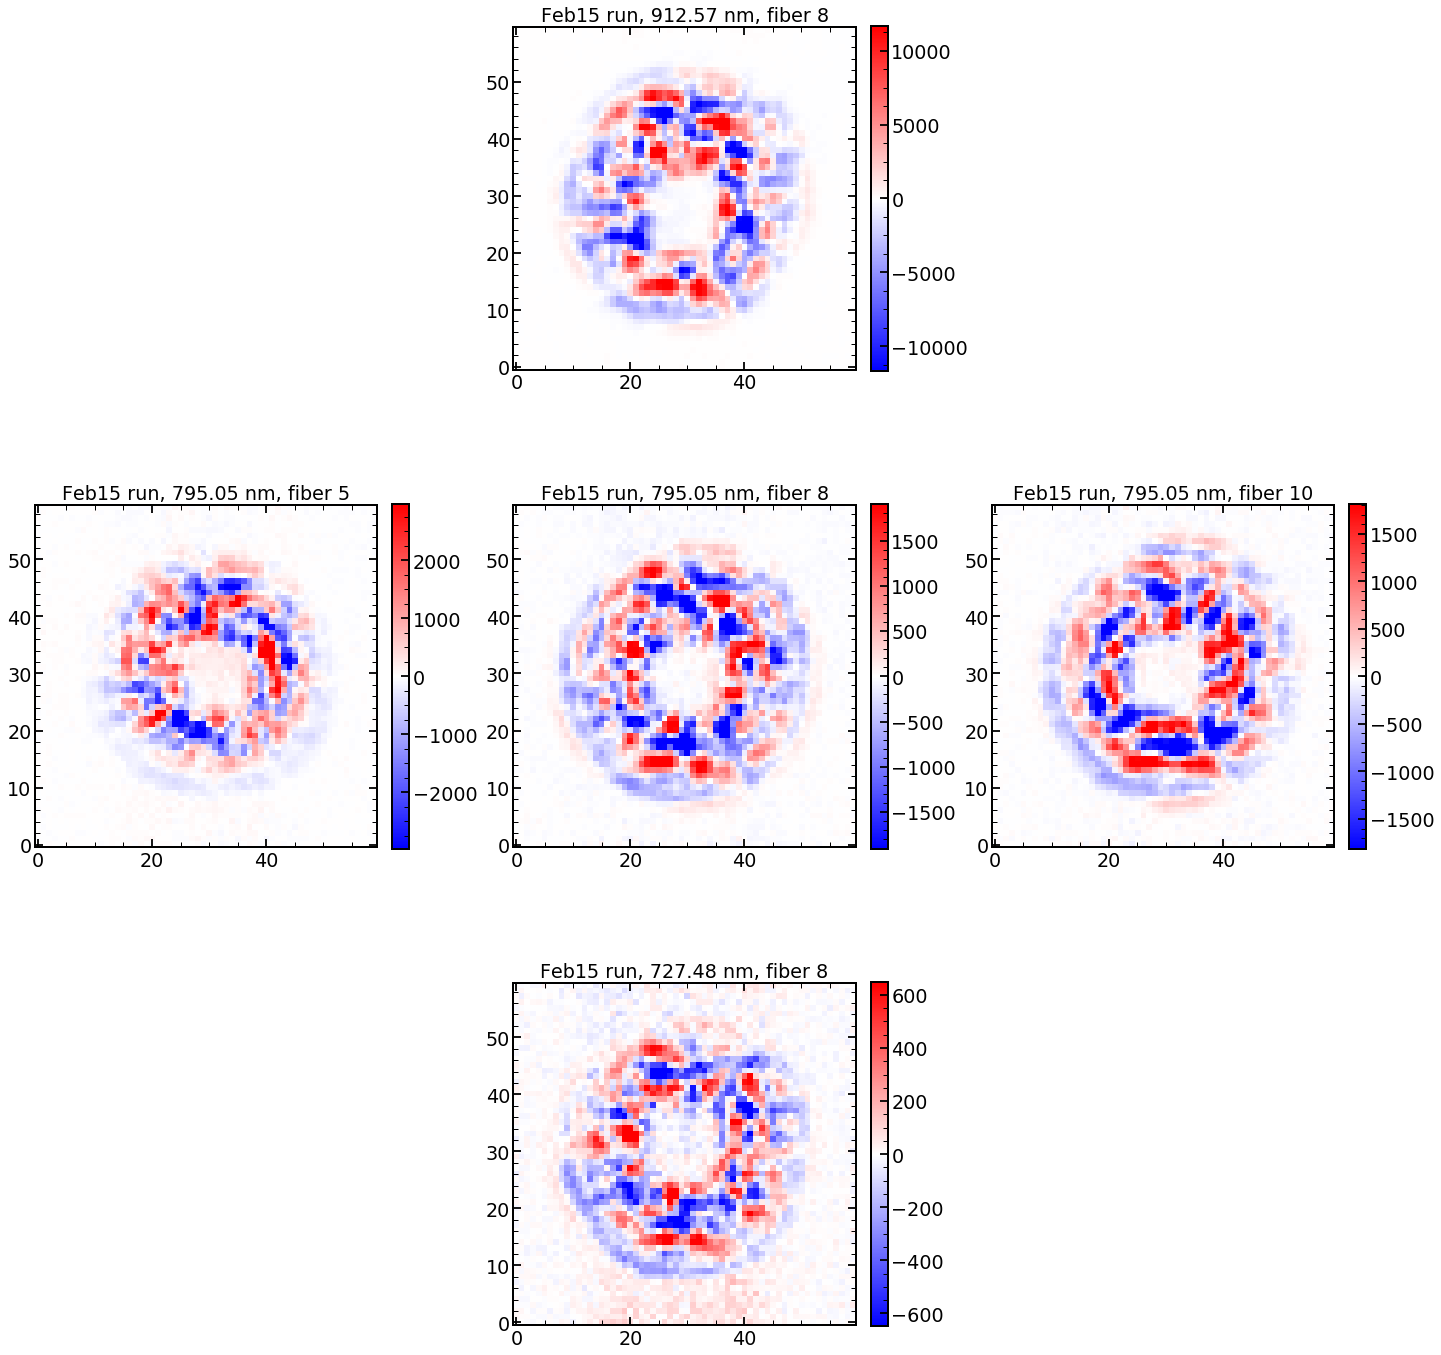

In [235]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))
#plt.suptitle('Residuals - Dec52 run, direct fit to defocused data, scale=5% of max value in the data')

plt.subplot(332)
plt.imshow(test_image_top-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Feb15 run, 912.57 nm, fiber 8')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Feb15 run, 727.48 nm, fiber 8')
plt.imshow(test_image_bottom-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Feb15 run, 795.05 nm, fiber 5')
plt.imshow(test_image_left-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Feb15 run, 795.05 nm, fiber 10')
plt.imshow(test_image_right-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Feb15 run, 795.05 nm, fiber 8')
plt.imshow(test_image_center-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.subplots_adjust(top=0.1)
plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

In [236]:
single_number=126
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_right_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_right_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_right_int)
test_image_right_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_right_Dec23_int-sci_image_right)**2/var_image_right))


single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_left_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_left_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_left_int)
test_image_left_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_left_Dec23_int-sci_image_left)**2/var_image_left))

single_number=99
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_bottom_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_bottom_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_bottom_int)
test_image_bottom_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_bottom_Dec23_int-sci_image_bottom)**2/var_image_bottom))

single_number=105
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_top_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_top_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_top_int)
test_image_top_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_top_Dec23_int-sci_image_top)**2/var_image_top))

single_number=102
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_center_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_center_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_center_int)
test_image_center_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_center_Dec23_int-sci_image_center)**2/var_image_center))

(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 56159.32286924807
minimal chi2 reduced is: 31.194492691274625
zmax: 11
Time for single pupil calculation is 1.3872981071472168
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:9.08416015625e-05
Supplied pupil has so many pixels (pupil_plane_im)(1536, 1536)
pupil.scale: 9.08416015625e-05
pupil.illuminated.astype(np.float32).shape: (1536, 1536)
89.19529039975686
(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 47506.278937939824
minimal chi2 reduced is: 26.387154916157108
zmax: 11
Time for single pupil calculation is 1.3609089851379395
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:9.08416015625e-05
Supplied pupil has so many pixels (pupil_plane_im)(1536, 1536)
pupil.scale: 9.08416015625e-05
pupil.illuminated.astype(np.float32).shape: (1536, 1536)
47.137504999060

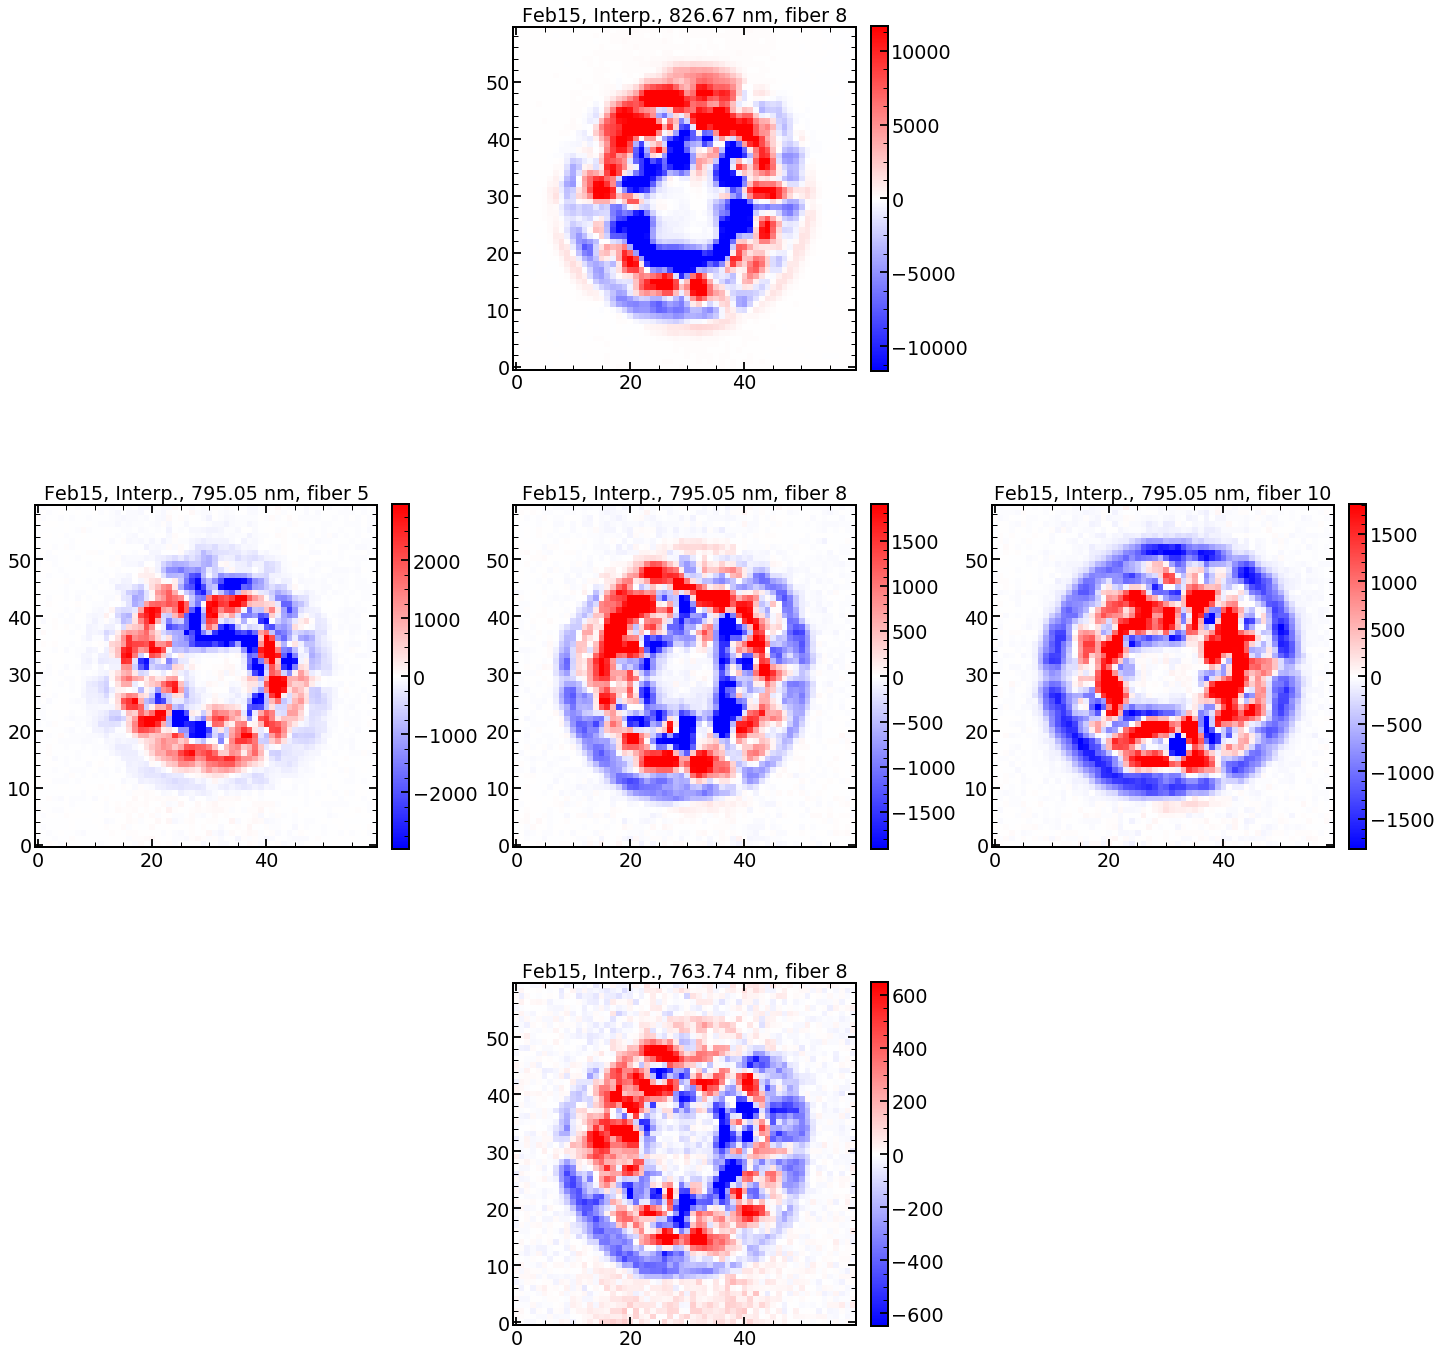

In [237]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(332)
plt.imshow(test_image_top_Dec23_int-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Feb15, Interp., 826.67 nm, fiber 8')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Feb15, Interp., 763.74 nm, fiber 8')
plt.imshow(test_image_bottom_Dec23_int-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Feb15, Interp., 795.05 nm, fiber 5')
plt.imshow(test_image_left_Dec23_int-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Feb15, Interp., 795.05 nm, fiber 10')
plt.imshow(test_image_right_Dec23_int-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Feb15, Interp., 795.05 nm, fiber 8')
plt.imshow(test_image_center_Dec23_int-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

### verification - individual images - Ne

In [238]:
print(results_of_fit_many_HgAr['p35'].loc[102][0])
print(results_of_fit_many_HgAr['p35'].loc[66][0])
print(results_of_fit_many_HgAr['p35'].loc[126][0])

print(results_of_fit_many_HgAr['p35'].loc[105][0])
print(results_of_fit_many_HgAr['p35'].loc[99][0])

-26.764646549017687
-25.70135337373753
-27.969372049959027
-27.133873026999204
-26.59999334377203


In [239]:
print(results_of_fit_many_Ne['m35'].loc[78][0])
print(results_of_fit_many_Ne['m35'].loc[77][0])
print(results_of_fit_many_Ne['m35'].loc[74][0])

print(results_of_fit_many_Ne['m35'].loc[68][0])
print(results_of_fit_many_Ne['m35'].loc[86][0])

25.86535528825243
25.744622250084976
26.429971256383233
25.635730607556248
25.967364834217374


In [240]:
list_of_single_number_Ne=[68,74,77,78,86]

In [241]:
date='Feb28'

arc='Ne'
obs=12397
single_number=86
sci_image_right =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_right =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=68
sci_image_left =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_left =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=74
sci_image_bottom =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_bottom =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=78
sci_image_top =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_top =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=77
sci_image_center =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_center =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [242]:
single_number=86
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right=minchain
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_right)
test_image_right=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=68
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left=minchain
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_left)
test_image_left=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=74
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom=minchain
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_bottom)
test_image_bottom=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=78
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top=minchain
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_top)
test_image_top=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=77
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center=minchain
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_center)
test_image_center=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 330160.47142212733
minimal chi2 reduced is: 264.1202732889163
zmax: 11
Time for single pupil calculation is 0.8800969123840332
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:0.000109009921875
Supplied pupil has so many pixels (pupil_plane_im)(1280, 1280)
pupil.scale: 0.000109009921875
pupil.illuminated.astype(np.float32).shape: (1280, 1280)
(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 369686.5580676122
minimal chi2 reduced is: 295.74110218847187
zmax: 11
Time for single pupil calculation is 1.0446431636810303
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:0.000109009921875
Supplied pupil has so many pixels (pupil_plane_im)(1280, 1280)
pupil.scale: 0.000109009921875
pupil.illuminated.astype(np.float32).shape: (1280, 1280)
(number of walkers, number of step

In [243]:
finalNe_Feb2019.loc[list_of_single_number_Ne[0]]['wavelength'][:5]

'693.1'

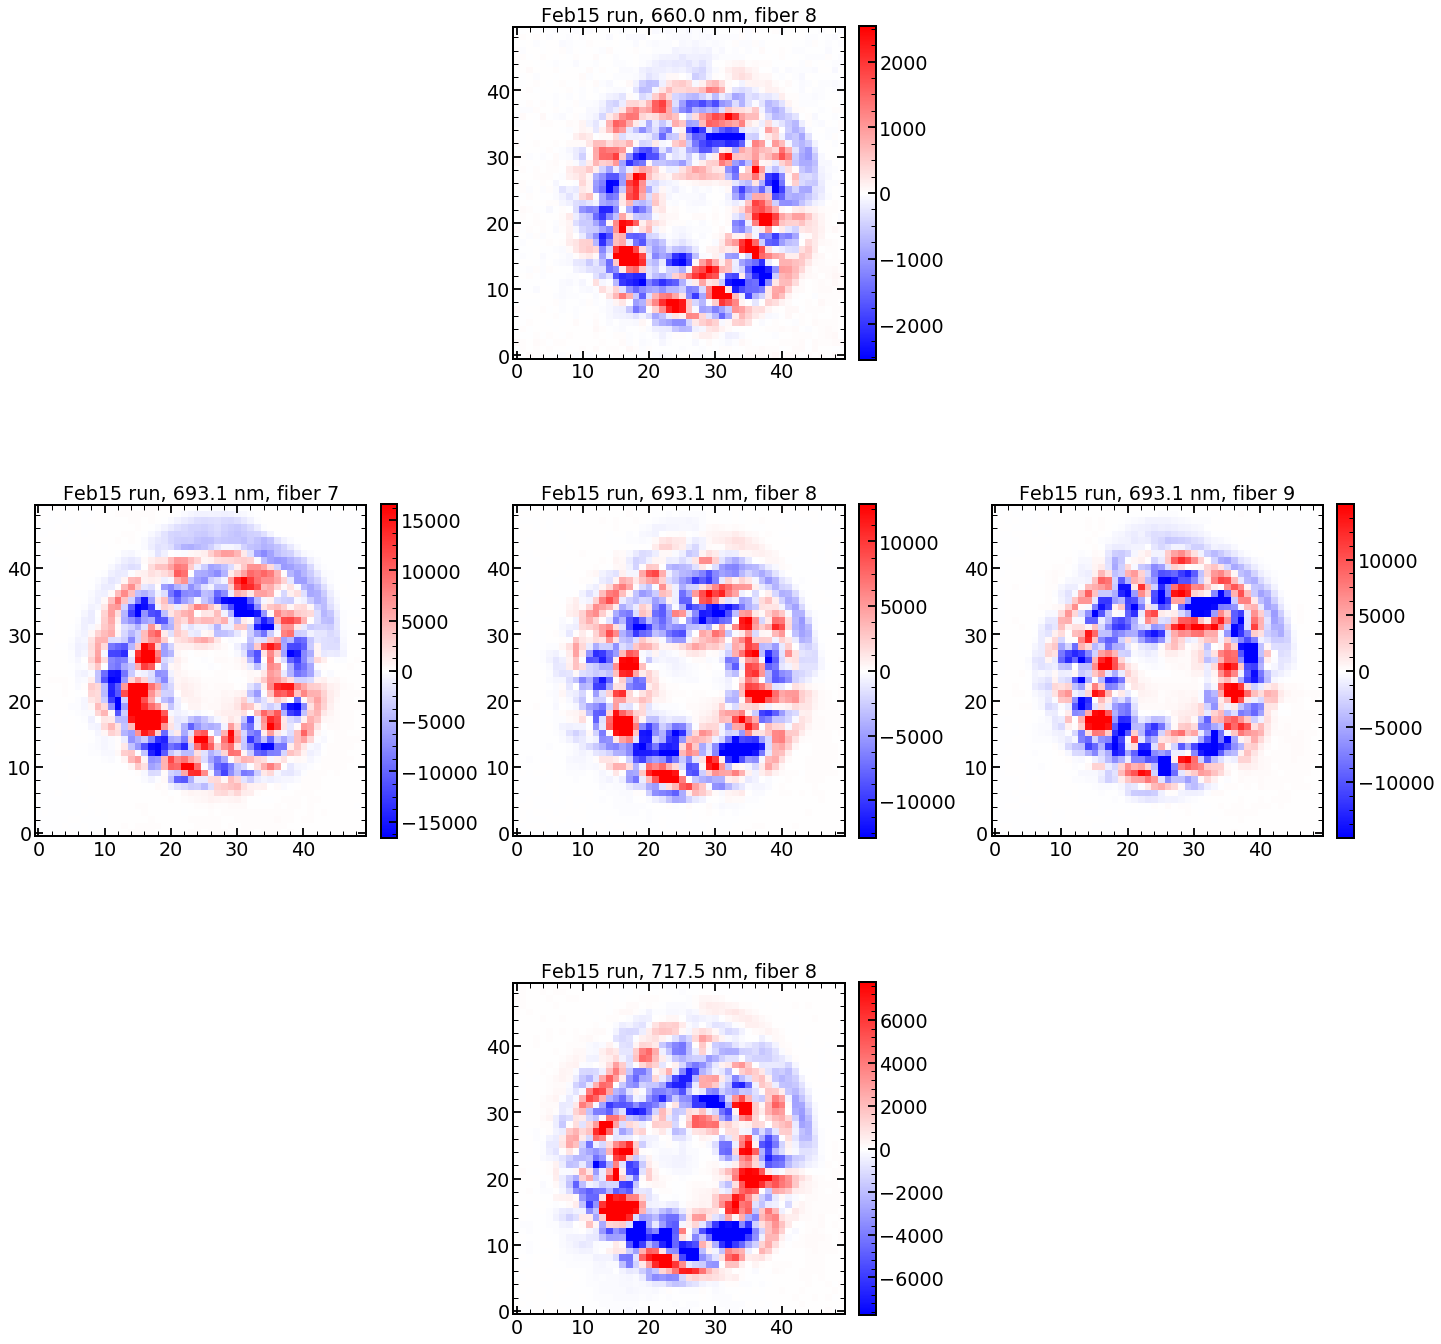

In [244]:
# change titles

matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))
#plt.suptitle('Residuals - Dec52 run, direct fit to defocused data, scale=5% of max value in the data')

plt.subplot(332)
plt.imshow(test_image_top-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Feb15 run, '+finalNe_Feb2019.loc[list_of_single_number_Ne[1]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[1]]['fiber'])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Feb15 run, '+finalNe_Feb2019.loc[list_of_single_number_Ne[3]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[3]]['fiber'])
plt.imshow(test_image_bottom-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Feb15 run, '+finalNe_Feb2019.loc[list_of_single_number_Ne[0]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[0]]['fiber'])
plt.imshow(test_image_left-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Feb15 run, '+finalNe_Feb2019.loc[list_of_single_number_Ne[4]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[4]]['fiber'])
plt.imshow(test_image_right-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Feb15 run, '+finalNe_Feb2019.loc[list_of_single_number_Ne[2]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[2]]['fiber'])
plt.imshow(test_image_center-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.subplots_adjust(top=0.1)
plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

In [245]:
# interpolation

In [246]:
list_of_single_number_Ne[4]

86

In [247]:
single_number=list_of_single_number_Ne[4]
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_right_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_right_int=results_of_fit_many_interpolation_Ne['m35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_right_int)
test_image_right_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_right_Dec23_int-sci_image_right)**2/var_image_right))


single_number=list_of_single_number_Ne[0]
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_left_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_left_int=results_of_fit_many_interpolation_Ne['m35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_left_int)
test_image_left_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_left_Dec23_int-sci_image_left)**2/var_image_left))

single_number=list_of_single_number_Ne[3]
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_bottom_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_bottom_int=results_of_fit_many_interpolation_Ne['m35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_bottom_int)
test_image_bottom_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_bottom_Dec23_int-sci_image_bottom)**2/var_image_bottom))

single_number=list_of_single_number_Ne[3]
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_top_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_top_int=results_of_fit_many_interpolation_Ne['m35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_top_int)
test_image_top_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_top_Dec23_int-sci_image_top)**2/var_image_top))

single_number=list_of_single_number_Ne[1]
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
#allparameters_proposal_center_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
allparameters_proposal_center_int=results_of_fit_many_interpolation_Ne['m35'].loc[single_number][:31]
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=11)   
res=model(allparameters_proposal_center_int)
test_image_center_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_center_Dec23_int-sci_image_center)**2/var_image_center))

(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 330160.47142212733
minimal chi2 reduced is: 264.1202732889163
zmax: 11
Time for single pupil calculation is 1.0204851627349854
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:0.000109009921875
Supplied pupil has so many pixels (pupil_plane_im)(1280, 1280)
pupil.scale: 0.000109009921875
pupil.illuminated.astype(np.float32).shape: (1280, 1280)
495.8138815512687
(number of walkers, number of steps, number of parameters): (186, 35, 31)
minimal likelihood is: 369686.5580676122
minimal chi2 reduced is: 295.74110218847187
zmax: 11
Time for single pupil calculation is 0.9041111469268799
Supplied pupil size is (pupil.size) [m]:0.1395327
One pixel has size of (pupil.scale) [m]:0.000109009921875
Supplied pupil has so many pixels (pupil_plane_im)(1280, 1280)
pupil.scale: 0.000109009921875
pupil.illuminated.astype(np.float32).shape: (1280, 1280)
591.970068448704

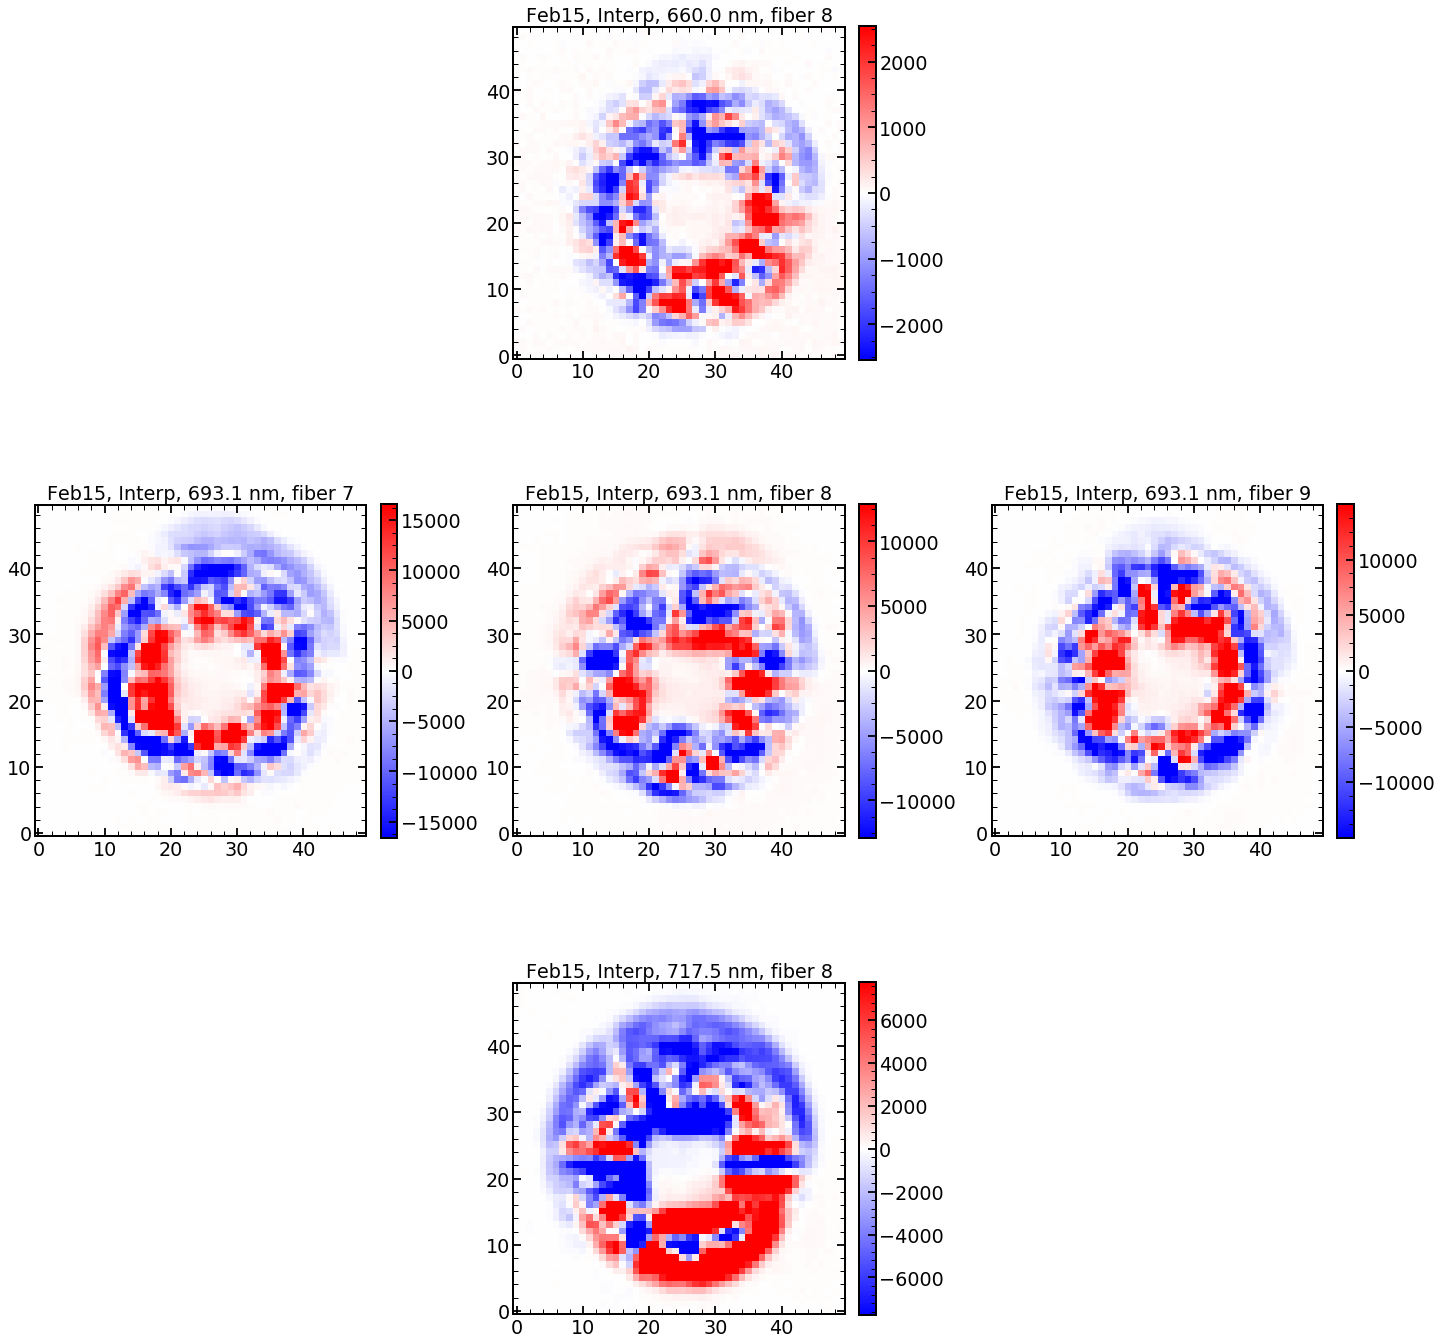

In [248]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(332)
plt.imshow(test_image_top_Dec23_int-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Feb15, Interp, '+finalNe_Feb2019.loc[list_of_single_number_Ne[1]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[1]]['fiber'])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(338)
plt.title('Feb15, Interp, '+finalNe_Feb2019.loc[list_of_single_number_Ne[3]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[3]]['fiber'])
plt.imshow(test_image_bottom_Dec23_int-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(334)
plt.title('Feb15, Interp, '+finalNe_Feb2019.loc[list_of_single_number_Ne[0]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[0]]['fiber'])
plt.imshow(test_image_left_Dec23_int-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(336)
plt.title('Feb15, Interp, '+finalNe_Feb2019.loc[list_of_single_number_Ne[4]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[4]]['fiber'])
plt.imshow(test_image_right_Dec23_int-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(335)
plt.title('Feb15, Interp, '+finalNe_Feb2019.loc[list_of_single_number_Ne[2]]['wavelength'][:5]+' nm, fiber '+finalNe_Feb2019.loc[list_of_single_number_Ne[2]]['fiber'])
plt.imshow(test_image_center_Dec23_int-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(pad=0.4 ,w_pad=0.5, h_pad=0.4)

# Focus (Feb29)

## Scripts

In [255]:
# select all and then remove the fibers 2 and 3

list_of_HgAr_to_analyze_all=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=15)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=0)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)&(finalHgAr_Feb2019['wavelength'].values.astype(float)<1000)&(finalHgAr_Feb2019['wavelength'].values.astype(float)>600)]
print(len(list_of_HgAr_to_analyze_all))

list_of_HgAr_to_not_analyze_2_3=finalHgAr_Feb2019.index[(finalHgAr_Feb2019['fiber'].values.astype(int)<=3)&(finalHgAr_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalHgAr_Feb2019['close'].values.astype(int)==1)&(finalHgAr_Feb2019['wavelength'].values.astype(float)<1000)&(finalHgAr_Feb2019['wavelength'].values.astype(float)>600)]

# remove the spots from fibers 2 and 3 as they are too close together
list_of_HgAr_to_analyze_focus=np.setdiff1d(list_of_HgAr_to_analyze_all,list_of_HgAr_to_not_analyze_2_3)

print(len(list_of_HgAr_to_analyze_focus))

list_of_HgAr_to_analyze_focus_10=np.split(list_of_HgAr_to_analyze_focus,10)

80
70


In [263]:
56/8

7.0

In [264]:
# select all and then remove the fibers 2 and 3

list_of_Ne_to_analyze_all=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=15)&(finalNe_Feb2019['fiber'].values.astype(int)>=0)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)&(finalNe_Feb2019['wavelength'].values.astype(float)<1000)&(finalNe_Feb2019['wavelength'].values.astype(float)>600)]
print(len(list_of_HgAr_to_analyze_all))

list_of_Ne_to_not_analyze_2_3=finalNe_Feb2019.index[(finalNe_Feb2019['fiber'].values.astype(int)<=3)&(finalNe_Feb2019['fiber'].values.astype(int)>=2)
                                        &(finalNe_Feb2019['close'].values.astype(int)==1)&(finalNe_Feb2019['wavelength'].values.astype(float)<1000)&(finalNe_Feb2019['wavelength'].values.astype(float)>600)]

# remove the spots from fibers 2 and 3 as they are too close together
list_of_Ne_to_analyze_focus=np.setdiff1d(list_of_Ne_to_analyze_all,list_of_Ne_to_not_analyze_2_3)

print(len(list_of_Ne_to_analyze_focus))

list_of_Ne_to_analyze_focus_10=np.split(list_of_Ne_to_analyze_focus,8)

80
56


In [256]:
#MPI
for i in range(len(list_of_HgAr_to_analyze_focus_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T08'+str(i)+'Feb_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_focus_10[i]:
        for obs in [11748]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger08_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_HgAr_to_analyze_focus_10)):
    file.write('sbatch /home/ncaplar/Scripts/T08'+str(i)+'Feb_focus.sh \n')

file.close()

In [265]:
#MPI
for i in range(len(list_of_Ne_to_analyze_focus_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T09'+str(i)+'Feb_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_focus_10[i]:
        for obs in [11748]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Feb_MPI02_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/FebScriptToSubmitScriptsTiger09_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_Ne_to_analyze_focus_10)):
    file.write('sbatch /home/ncaplar/Scripts/T09'+str(i)+'Feb_focus.sh \n')

file.close()

## Looking at the single image

In [569]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl', 'rb') as f:
    finalHgAr_Feb2019=pickle.load(f)

date='Feb16'
obs=str(11748)
single_number='102'
image_index=int(single_number)
eps=10
arc='HgAr'


STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=8603
elif arc=="Ne":
    single_number_focus=8693    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
elif arc=='Ne':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr_Feb2019
elif arc=="Ne":
    finalArc=finalNe    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

0d


fiber                           8
xc                           2133
yc                           1955
wavelength               795.0522
close                           1
lamp                         HgAr
xc_effective                 2202
old_index_approx               66
superold_index_approx        55.0
Name: 102, dtype: object

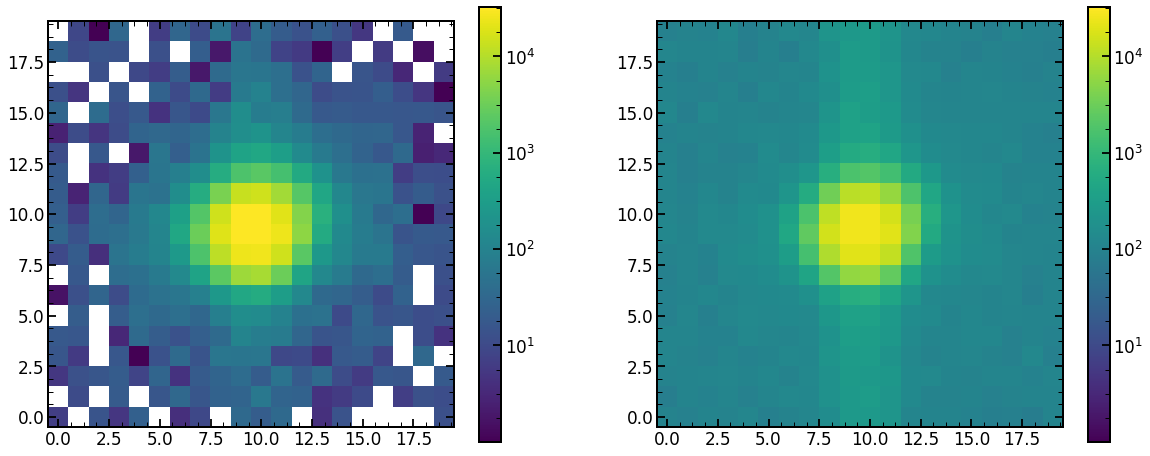

In [570]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [571]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (186, 5, 31)
minimal likelihood is: 869.445608976323
minimal chi2 reduced is: 4.310614552419894


In [572]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
    
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)


(31,)
         z4      z5        z6        z7        z8        z9       z10  \
0 -0.672416 -0.1305 -0.406985  0.283032 -0.015249 -0.026735 -0.303919   

        z11  
0 -0.358828  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.681352   0.077112  0.005523  0.011925  0.059999     0.012756   

   radiometricEffect  radiometricExponent    x_ilum   y_ilum  
0           0.120568             0.689581  0.968483  0.99315  
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0 -0.006576 -0.065229                       0.821551   0.099492   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.546187  1.016796           -0.020801   60992.967301   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0            2.8104              0.006233      0.350739  1.840024  0.996186  


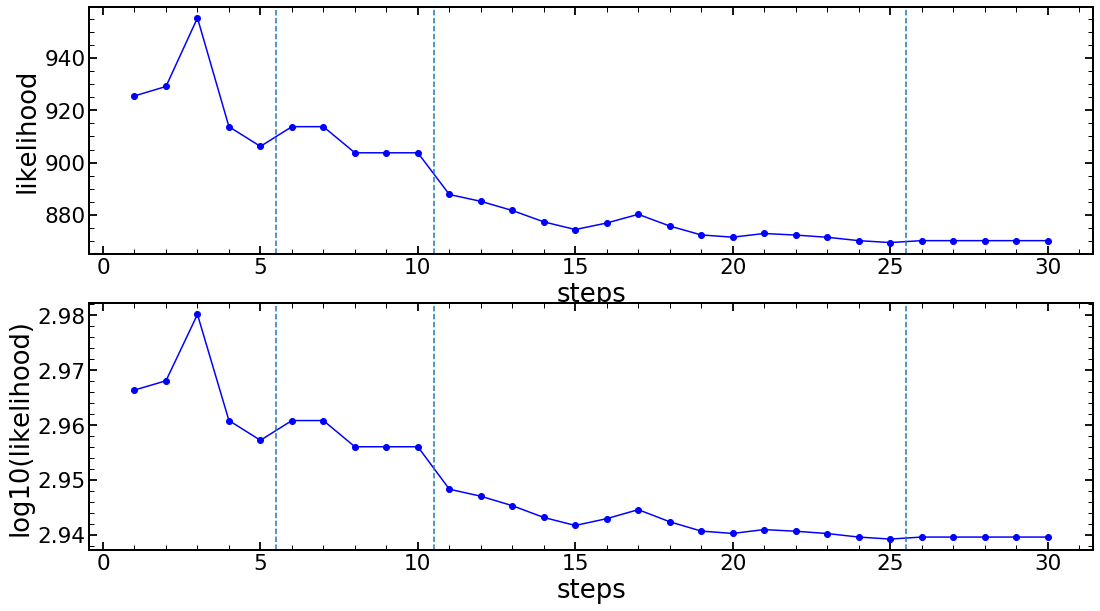

In [573]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [574]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=11)   
       
model(minchain)

zmax: 11


-862.4683842629838

In [575]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

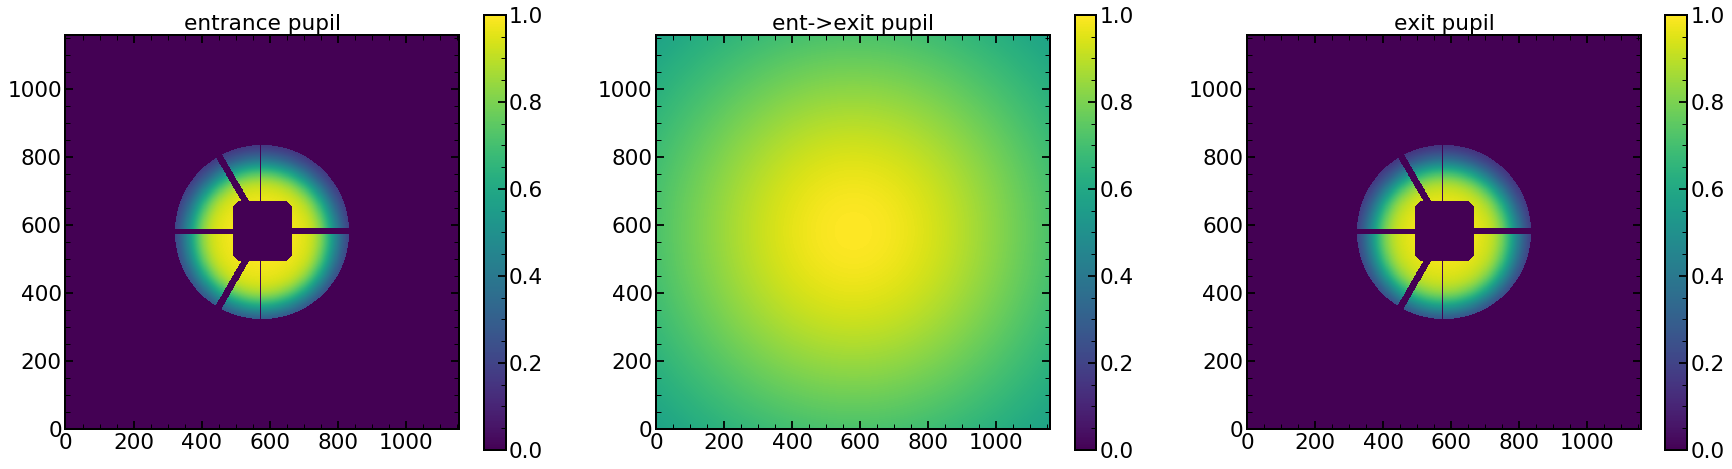

In [576]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

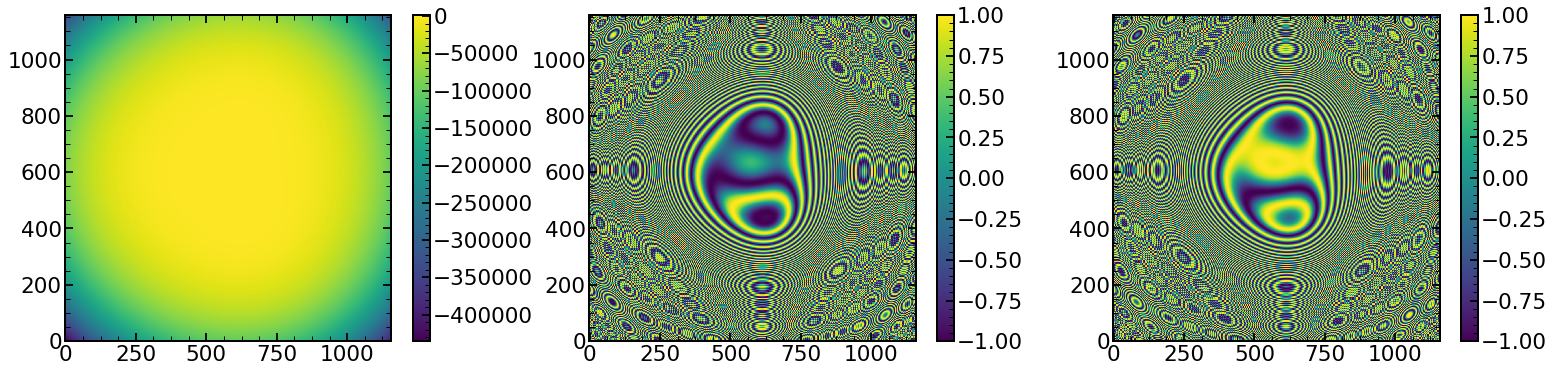

In [577]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

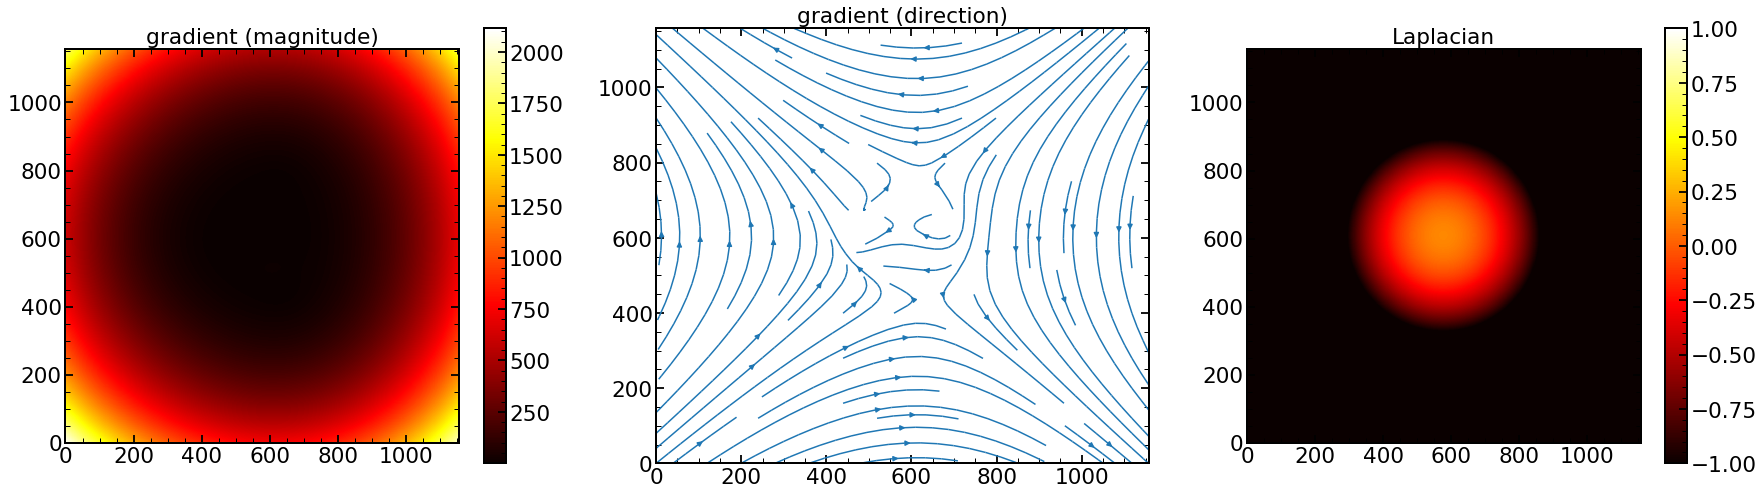

In [578]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

Text(0.5,1,'Residual')

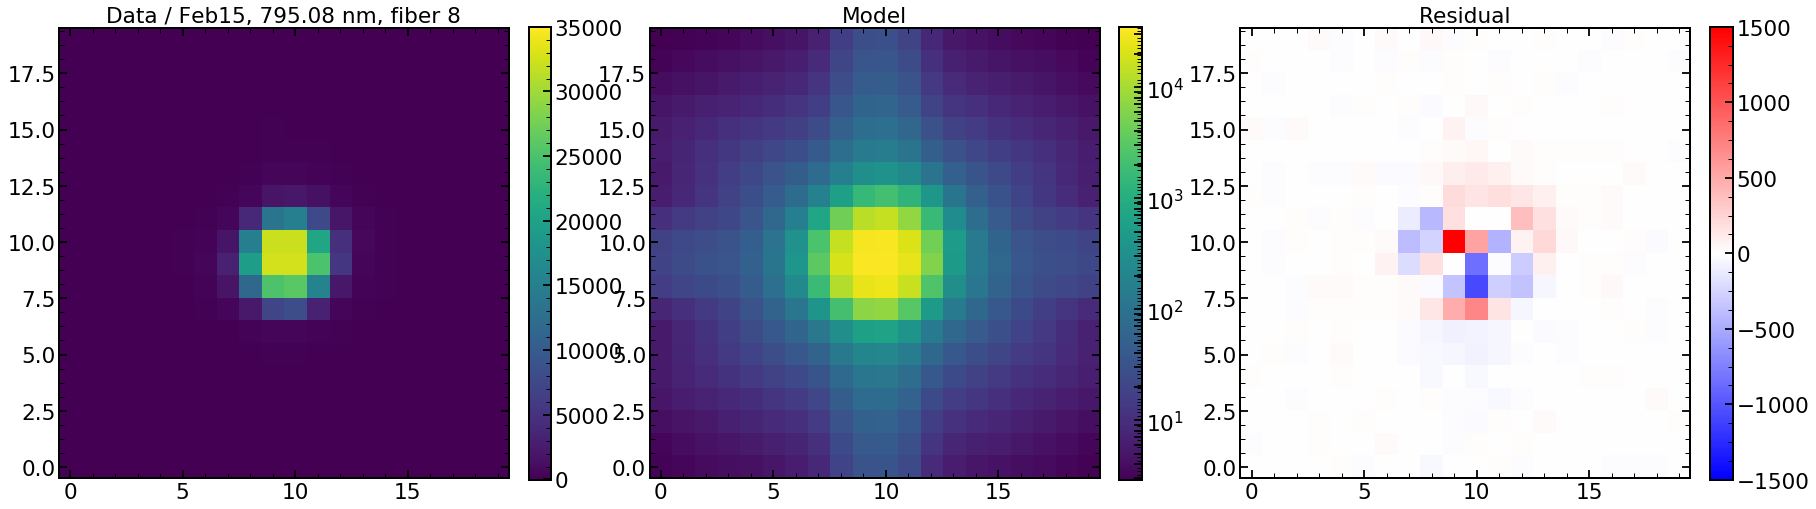

In [579]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=35000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / Feb15, 795.08 nm, fiber 8')
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=35000,norm=LogNorm())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-30000/20,vmax=30000/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

In [580]:
print(np.sum(var_image[0:3]),np.sum(res_iapetus[0:3]),np.sum(sci_image[0:3]))

8174.4297 729.5627671890777 787.7394


In [581]:
print(np.sum(var_image[-3:]),np.sum(res_iapetus[-3:]),np.sum(sci_image[-3:]))

8102.891 618.1422037380275 718.24133


Text(0.5,1,'Residual')

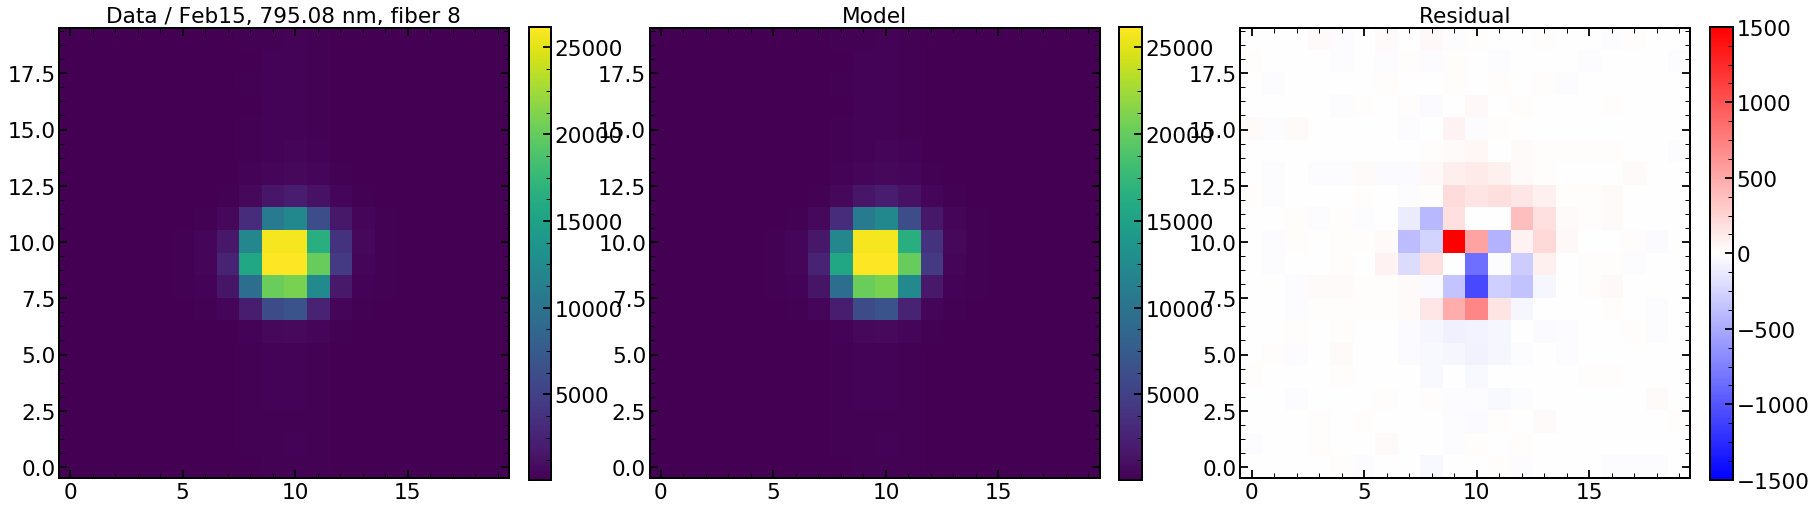

In [582]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(var_image,vmax=np.max(var_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / Feb15, 795.08 nm, fiber 8')
plt.subplot(1,3,2)
plt.imshow(var_image,vmax=np.max(var_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-30000/20,vmax=30000/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

chi**2 reduced is: 4.275728416658656
Abs of residual divided by total flux is: 0.04103330959784643
Abs of residual divided by largest value of a flux in the image is: 0.050845309508075205


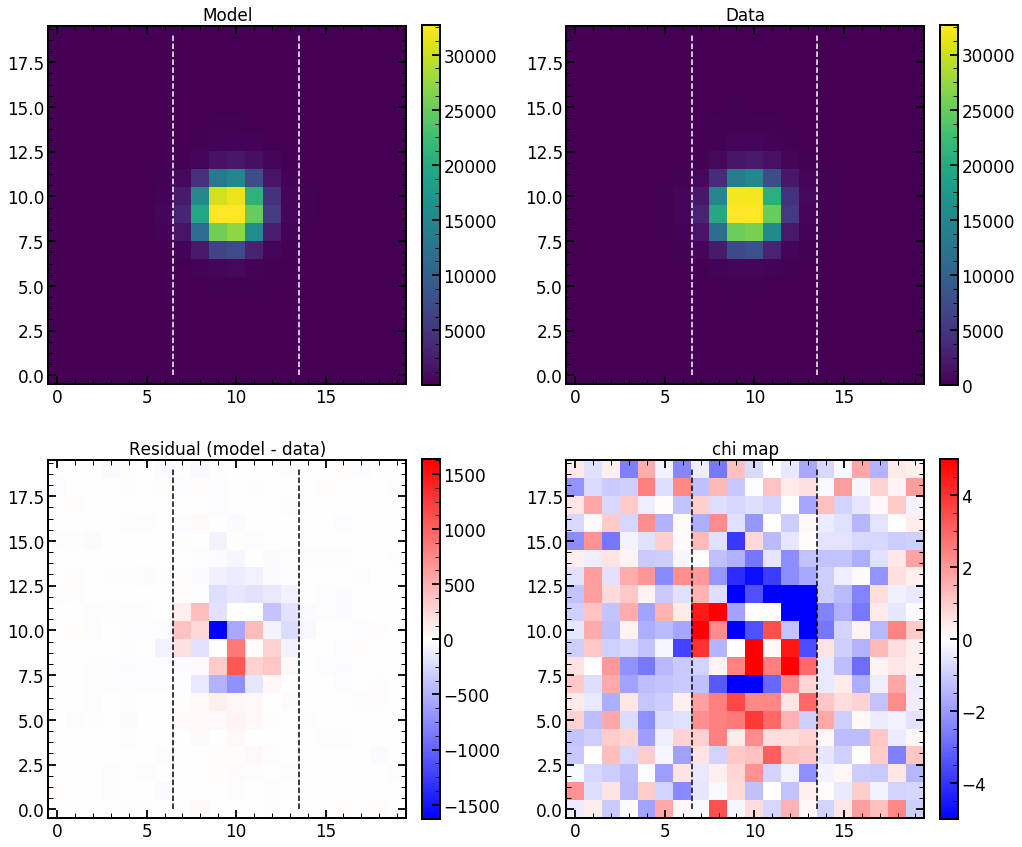

In [583]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

4.275728416658656
chi**2 reduced is: 4.275728416658656
Abs of residual divided by total flux is: 0.04103330959784643
Abs of residual divided by largest value of a flux in the image is: 0.050845309508075205


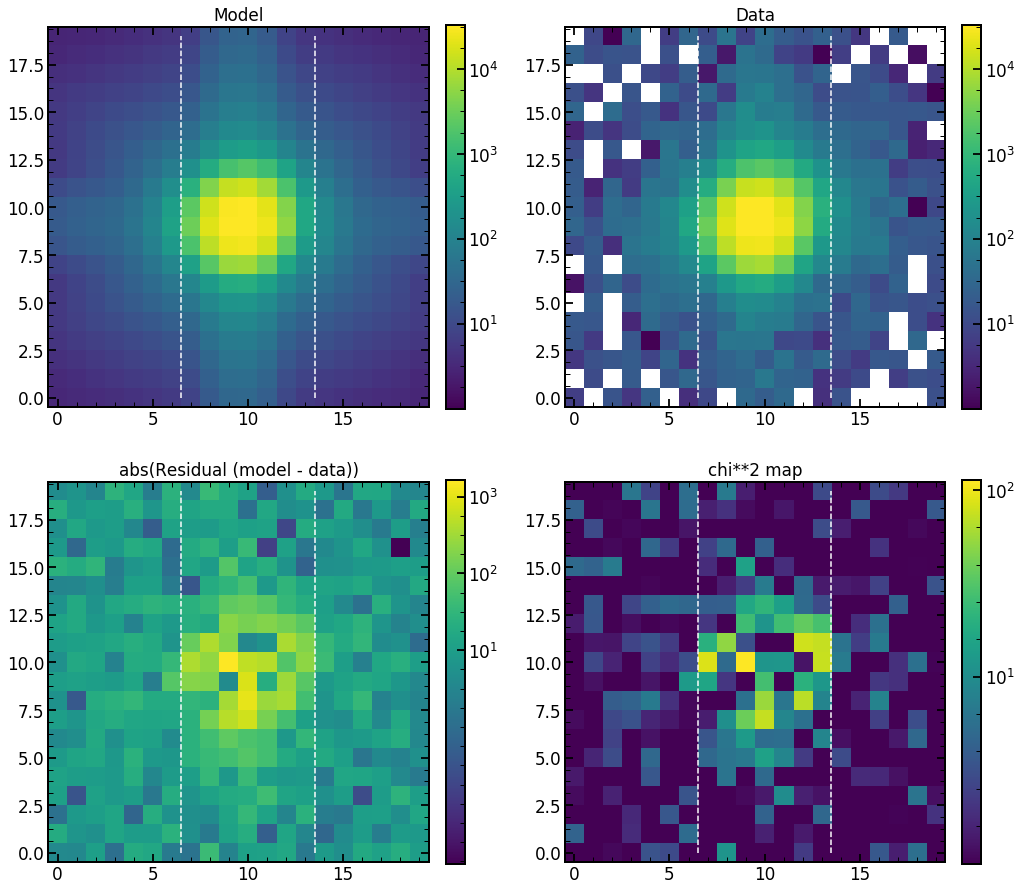

In [584]:
single_analysis.create_basic_comparison_plot_log()

4.275728416658656
chi**2 reduced is: 4.275728416658656
Abs of residual divided by total flux is: 0.04103330959784643
Abs of residual divided by largest value of a flux in the image is: 0.050845309508075205


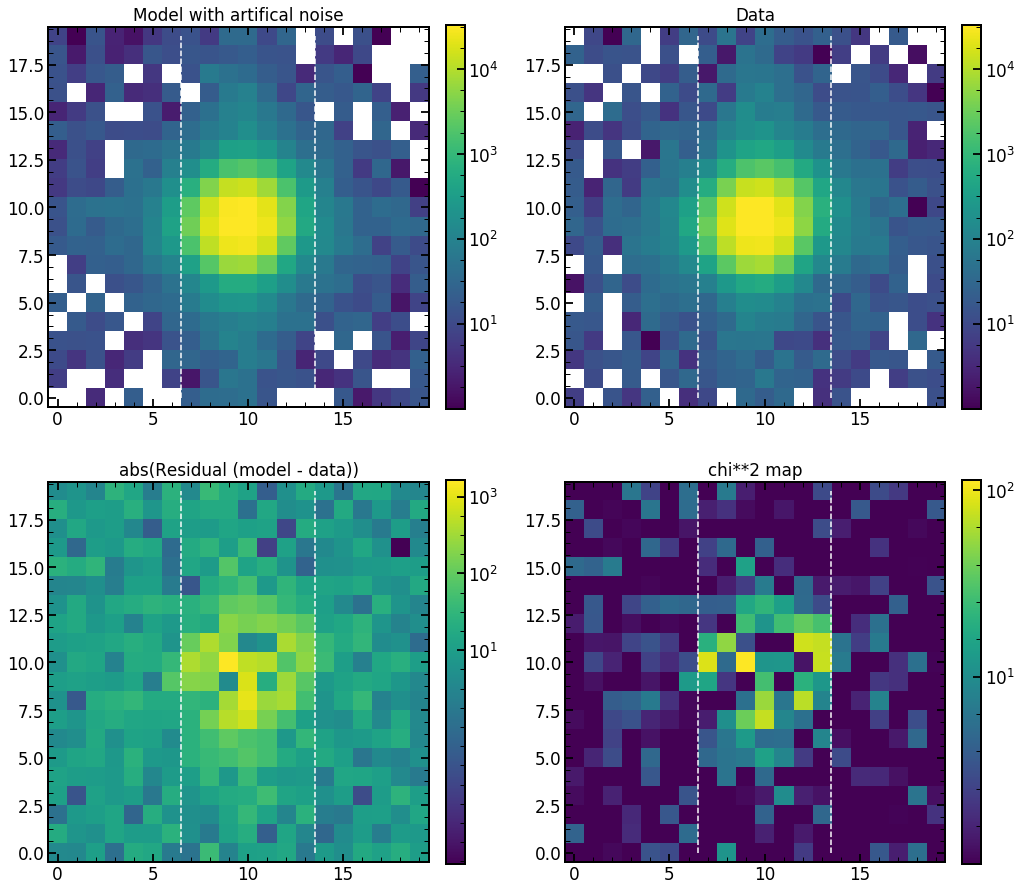

In [585]:
single_analysis.create_basic_comparison_plot_log_artifical()

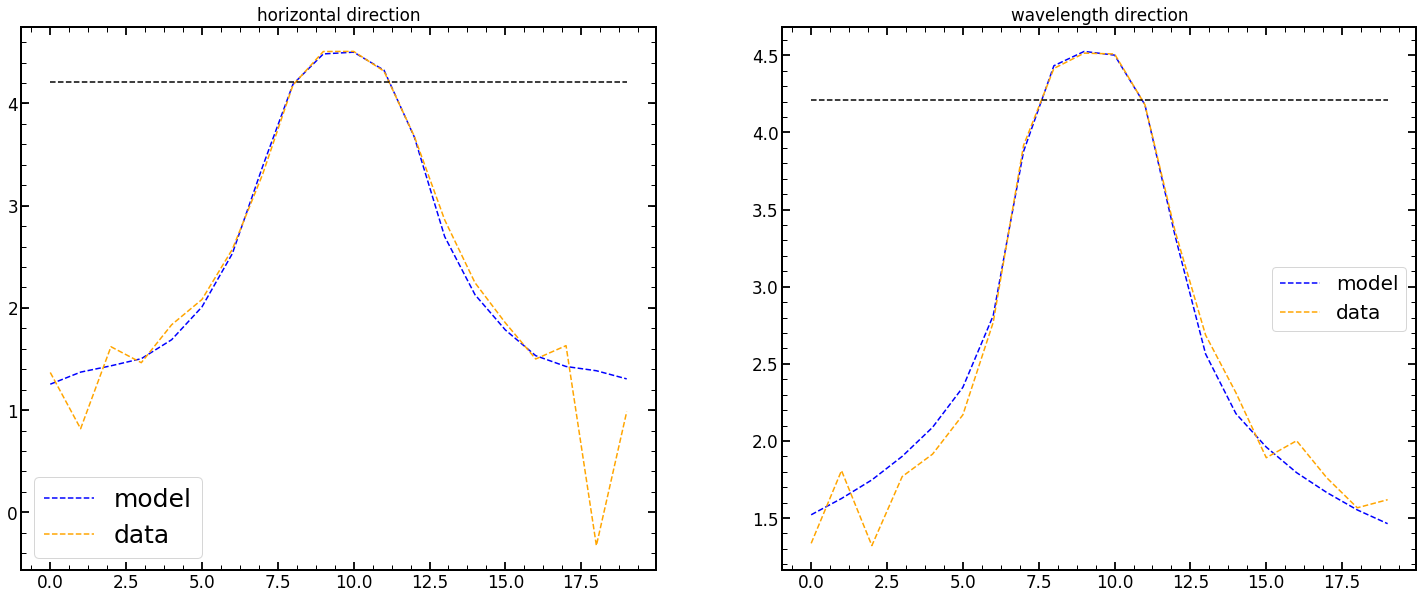

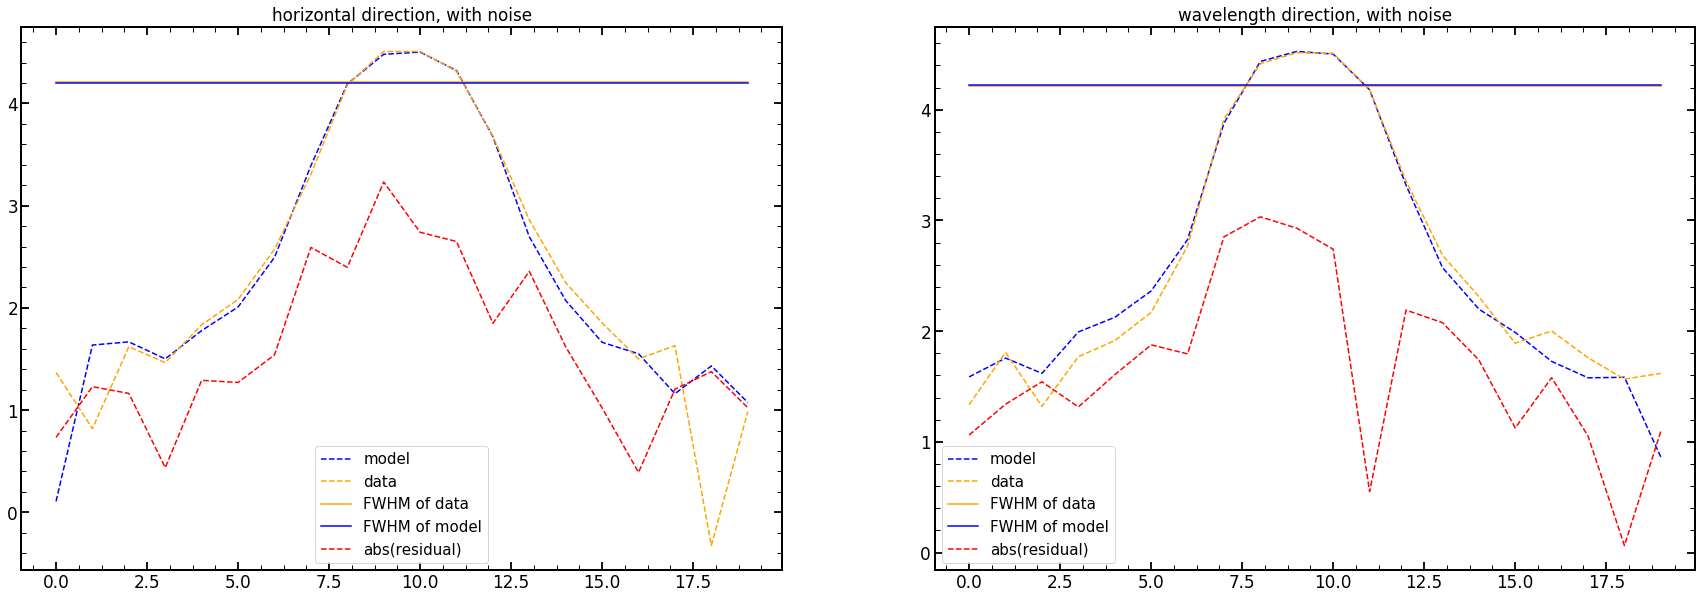

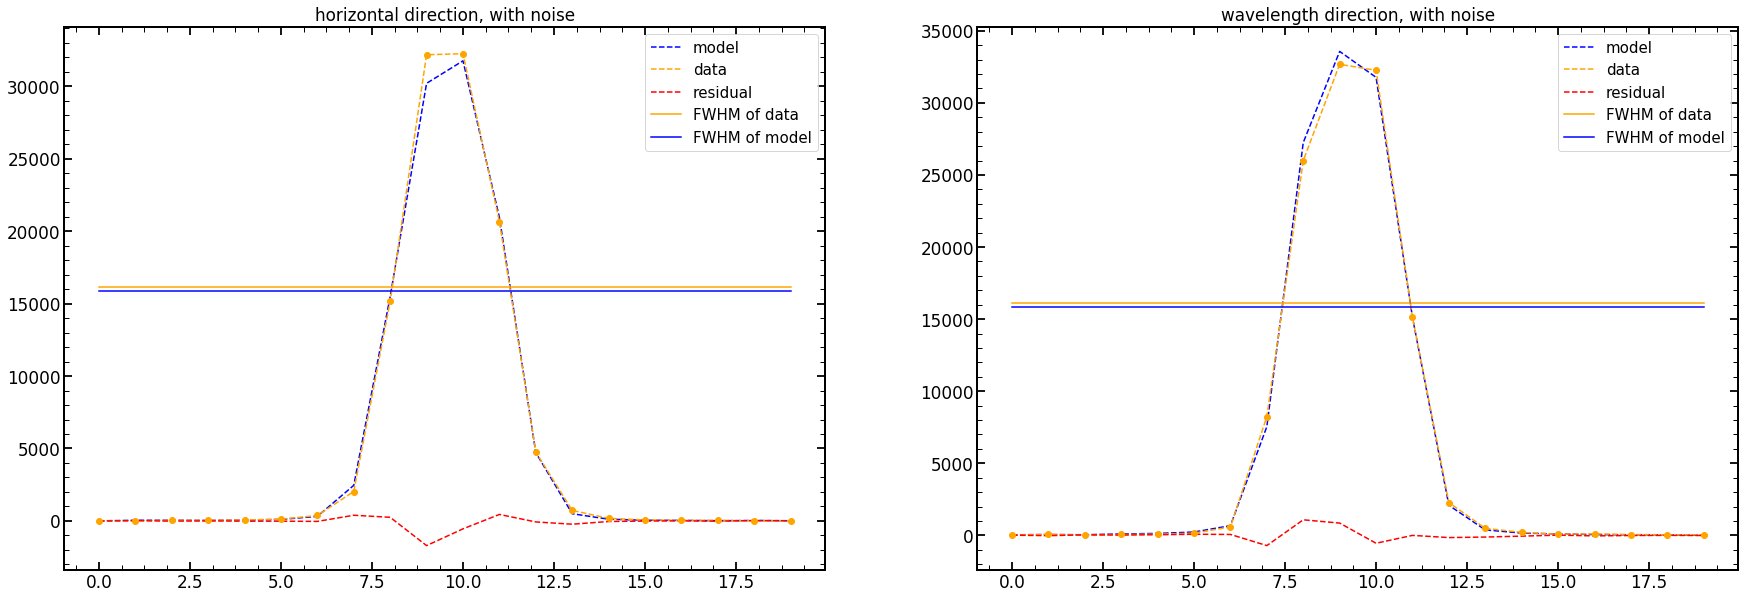

In [586]:
single_analysis.create_cut_plots()

## Testing correctness of detector_Map

In [591]:
from astropy.io import fits

In [593]:
dm=fits.open('/Users/nevencaplar/Documents/PFS/DetectorMap/detectorMap-sim-1-r.fits')

In [625]:
xpos_singlefiber=np.array(dm[3].data)[np.array(dm[3].data)['index']==30][['knot','value']]
ypos_singlefiber=np.array(dm[3].data)[np.array(dm[3].data)['index']==30][['knot','value']]
lamda_pos_singlefiber=np.array(dm[4].data)[np.array(dm[4].data)['index']==30][['knot','value']]

In [626]:
lamda_pos_singlefiber

array([(   0., 620.7515 ), (   1., 620.8369 ), (   2., 620.9223 ), ...,
       (4173., 977.1305 ), (4174., 977.21594), (4175., 977.30133)],
      dtype=[('knot', '>f4'), ('value', '>f4')])

In [630]:
finalHgAr_Feb2019[finalHgAr_Feb2019['wavelength']=='826.6699']

fiber    xc    yc wavelength close  lamp  xc_effective old_index_approx  \
7       0   272  2354   826.6699   0.5  HgAr           272                7   
19      1   483  2346   826.6699   0.5  HgAr           483               19   
31      2   865  2334   826.6699   0.5  HgAr           865               31   
43      3   908  2333   826.6699   0.5  HgAr           908               31   
55      4  1241  2326   826.6699   0.5  HgAr          1241               31   
..    ...   ...   ...        ...   ...   ...           ...              ...   
139    11  2655  2329   826.6699   0.5  HgAr          2724               79   
151    12  2845  2333   826.6699   0.5  HgAr          2914               91   
163    13  3345  2348   826.6699   0.5  HgAr          3414              103   
175    14  3642  2361   826.6699   0.5  HgAr          3711              103   
187    15  3834  2370   826.6699   0.5  HgAr          3903              115   

    superold_index_approx  
7                    40.0  
19                   41.0  
31                   42.0  
43                   42.0  
55                   42.0  
..                    ...  
139                  46.0  
151                  47.0  
163                  48.0  
175                  48.0  
187                  49.0  

[16 rows x 9 columns]

In [631]:
xpos_singlefiber

array([(   0., 3837.8633), (   1., 3837.849 ), (   2., 3837.835 ), ...,
       (4173., 3840.4304), (4174., 3840.4468), (4175., 3840.4631)],
      dtype=[('knot', '>f4'), ('value', '>f4')])

In [641]:
lamda_dm=np.mean(lamda_pos_singlefiber['value'][(lamda_pos_singlefiber['value']<826.6699+1)&(lamda_pos_singlefiber['value']>826.6699-1)])
y_dm=np.mean(ypos_singlefiber['knot'][(lamda_pos_singlefiber['value']<826.6699+1)&(lamda_pos_singlefiber['value']>826.6699-1)])
x_dm=np.mean(xpos_singlefiber['value'][(lamda_pos_singlefiber['value']<826.6699+1)&(lamda_pos_singlefiber['value']>826.6699-1)])
[x_dm,y_dm,lamda_dm]


[3826.6074, 2411.0, 826.6537]

# Testing / Interdependence of parameters

In [81]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=11)   
       
model(minchain)

zmax: 11


-86366.61239701326

69.08583038230516
chi**2 reduced is: 69.08583038230516
Abs of residual divided by total flux is: 0.06333440211517713
Abs of residual divided by largest value of a flux in the image is: 0.17441752616111833


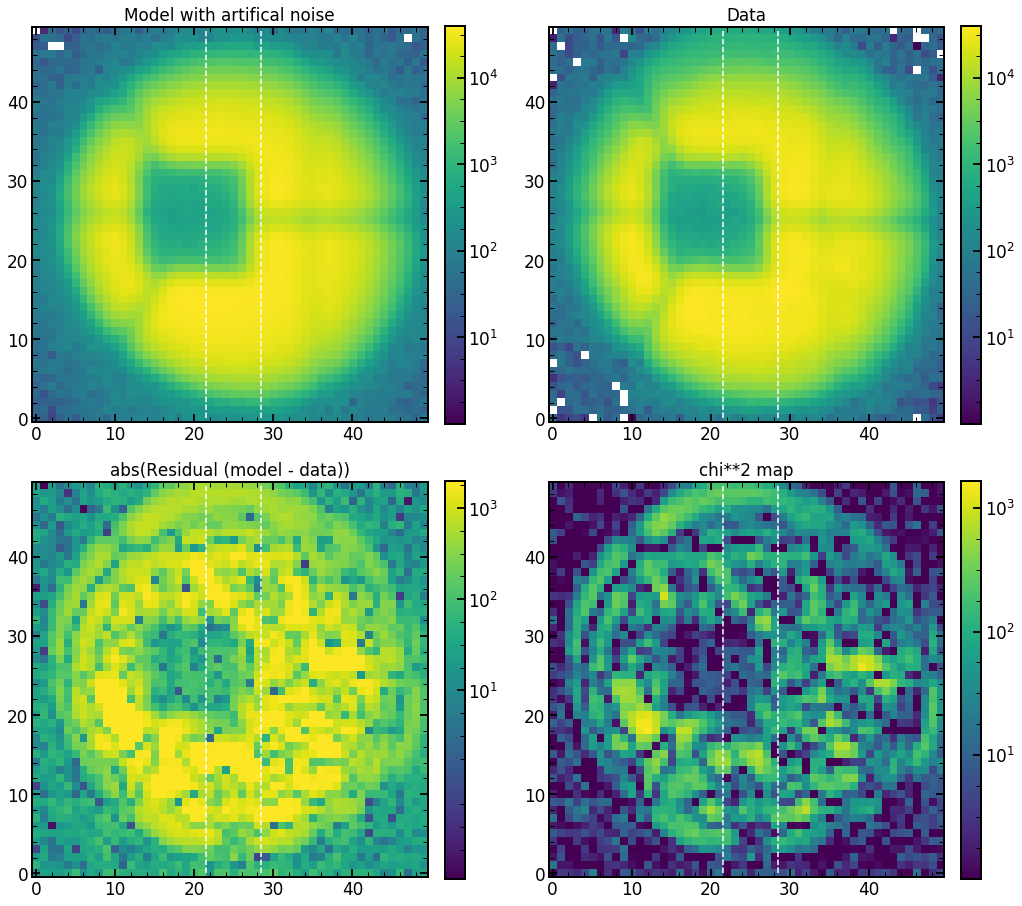

In [82]:
single_analysis.create_basic_comparison_plot_log_artifical()

In [ ]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=11)   
       
        
minchain_modified=np.copy(minchain)
model(minchain_modified)

In [ ]:
single_analysis.create_basic_comparison_plot_log_artifical()

In [ ]:
x=chain0_Emcee3[:,:,0].ravel()
y=chain0_Emcee3[:,:,20].ravel()
z=likechain0_Emcee3.ravel()/np.max(likechain0_Emcee3)

In [ ]:
np.unique([0,0],[0,0])

## Dependence in parameters space

### developing

In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def find_min(arr):
    res=[]
    for i in range(len(arr)):
        res.append(arr[i][abs(arr[i][:,2])==np.min(abs(arr[i][:,2]))])
        
    return res

chain0_Emcee2,likechain0_Emcee2=single_analysis.create_chains_Emcee_2()

# put 2 parameters and likelihood in a single array
test_array_Emcee2=np.unique(np.transpose(np.array([chain0_Emcee2[:,:,0].ravel(),chain0_Emcee2[:,:,20].ravel(),likechain0_Emcee2.ravel()])),axis=0)
test_array_Emcee2=test_array_Emcee2[test_array_Emcee2[:,2]!=-np.inf]
# split size determined so that each bin on the end has around 10 points 
split_size=int(np.round(np.sqrt(test_array_Emcee2.shape[0]/10)  ) )
# sort by first parameters
test_array_sorted_by_0=test_array_Emcee2[np.argsort(test_array_Emcee2[:, 0])]
# split in roughly 27 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size)))
res=[]
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])
res_Emcee2=res

#best results, arrange in a split_size x split_size array
min_res_split_Emcee2=np.array(list(split(res_Emcee2,split_size)))
min_min_res_split_Emcee2=np.array(find_min(min_res_split_Emcee2)).ravel().reshape(split_size,3)

In [ ]:
chain0_Emcee1,likechain0_Emcee1=single_analysis.create_chains_Emcee_1()

# put 2 parameters and likelihood in a single array
test_array_Emcee1=np.unique(np.transpose(np.array([chain0_Emcee1[:,:,0].ravel(),chain0_Emcee1[:,:,20].ravel(),likechain0_Emcee1.ravel()])),axis=0)
test_array_Emcee1=test_array_Emcee1[test_array_Emcee1[:,2]!=-np.inf]
# split size determined so that each bin on the end has around 10 points 
split_size=int(np.round(np.sqrt(test_array_Emcee1.shape[0]/10)  ) )
# sort by first parameters
test_array_sorted_by_0=test_array_Emcee1[np.argsort(test_array_Emcee1[:, 0])]
# split in roughly 27 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size)))
res=[]
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])
res_Emcee1=res

#best results, arrange in a split_size x split_size array
min_res_split_Emcee1=np.array(list(split(res_Emcee1,split_size)))
min_min_res_split_Emcee1=np.array(find_min(min_res_split_Emcee1)).ravel().reshape(split_size,3)

In [ ]:
chain0_Swarm2,likechain0_Swarm2=single_analysis.create_chains_swarm_2()

# put 2 parameters and likelihood in a single array
test_array_Swarm2=np.unique(np.transpose(np.array([chain0_Swarm2[:,:,0].ravel(),chain0_Swarm2[:,:,20].ravel(),likechain0_Swarm2.ravel()])),axis=0)
test_array_Swarm2=test_array_Swarm2[test_array_Swarm2[:,2]!=-np.inf]
# split size determined so that each bin on the end has around 10 points 
split_size=int(np.round(np.sqrt(test_array_Swarm2.shape[0]/10)  ) )
# sort by first parameters
test_array_sorted_by_0=test_array_Swarm2[np.argsort(test_array_Swarm2[:, 0])]
# split in roughly 27 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size)))
res=[]
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])

res_swarm2=res

#best results, arrange in a split_size x split_size array
min_res_split_swarm2=np.array(list(split(res_swarm2,split_size)))
min_min_res_split_swarm2=np.array(find_min(min_res_split_swarm2)).ravel().reshape(split_size,3)

In [ ]:
chain0_Swarm1,likechain0_Swarm1=single_analysis.create_chains_swarm_1()

# put 2 parameters and likelihood in a single array
test_array_Swarm1=np.unique(np.transpose(np.array([chain0_Swarm1[:,:,0].ravel(),chain0_Swarm1[:,:,20].ravel(),likechain0_Swarm1.ravel()])),axis=0)
test_array_Swarm1=test_array_Swarm1[test_array_Swarm1[:,2]!=-np.inf]
# split size determined so that each bin on the end has around 10 points 
split_size=int(np.round(np.sqrt(test_array_Swarm1.shape[0]/10)  ) )
# sort by first parameters
test_array_sorted_by_0=test_array_Swarm1[np.argsort(test_array_Swarm1[:, 0])]
# split in roughly 27 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size)))
res=[]
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])

res_swarm1=res

#best results, arrange in a split_size x split_size array
min_res_split_swarm1=np.array(list(split(res_swarm1,split_size)))
min_min_res_split_swarm1=np.array(find_min(min_res_split_swarm1)).ravel().reshape(split_size,3)

In [ ]:
test_array_stack=np.vstack((test_array_Swarm1,test_array_Swarm2,test_array_Emcee2,test_array_Emcee1))
test_array_stack=np.unique(np.transpose(np.array([test_array_stack[:,0].ravel(),test_array_stack[:,1].ravel(),test_array_stack[:,2].ravel()])),axis=0)
# split size determined so that
split_size_1=int(np.round(test_array_stack.shape[0]/100)   )
# sort by first parameters
test_array_sorted_by_0=test_array_stack[np.argsort(test_array_stack[:, 0])]
# split in split_size_1 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size_1)))
res=[]
split_size_2=10
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size_2)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])

res_stack=res

#best results, arrange in a split_size x split_size array
min_res_split_stack=np.array(list(split(res_stack,split_size_1)))
min_min_res_split_stack=np.array(find_min(min_res_split_stack)).ravel().reshape(split_size_1,3)

In [ ]:
test_array_stack_test=np.unique(np.transpose(np.array([chain0_stack[:,:,0].ravel(),chain0_stack[:,:,20].ravel(),likechain0_stack.ravel()])),axis=0)
test_array_stack_test=np.unique(np.transpose(np.array([test_array_stack[:,0].ravel(),test_array_stack[:,1].ravel(),test_array_stack[:,2].ravel()])),axis=0)
# split size determined so that
split_size_1=int(np.round(test_array_stack_test.shape[0]/100)   )
# sort by first parameters
test_array_sorted_by_0=test_array_stack_test[np.argsort(test_array_stack_test[:, 0])]
# split in split_size_1 arrays with same number of objects
test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,split_size_1)))
res=[]
split_size_2=10
for j in range(len(test_array_sorted_by_0_split)):
    # within these arrays do one more split
    test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],split_size_2)))
    res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
res[:,2]=res[:,2]/np.max(res[:,2])

res_stack_test=res

#best results, arrange in a split_size x split_size array
min_res_split_stack_test=np.array(list(split(res_stack_test,split_size_1)))
min_min_res_split_stack_test=np.array(find_min(min_res_split_stack_test)).ravel().reshape(split_size_1,3)

In [ ]:
chain0_Emcee1.shape

In [ ]:
chain_stack[1000][22]

In [ ]:
min_min_res_split_stack_test

In [ ]:
# together

In [ ]:
poly_fit_res_1=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],1)
p1 = np.poly1d(poly_fit_res_1)

poly_fit_res_2=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],2)
p2 = np.poly1d(poly_fit_res_2)

poly_fit_res_3=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],3)
p3= np.poly1d(poly_fit_res_3)

In [ ]:
plt.figure(figsize=(12,8))

#surf = plt.scatter(res_Emcee1[:,0], res_Emcee1[:,1],c=np.log10(res_Emcee1[:,2]),s=20,vmax=1)
#plt.plot(min_min_res_split_Emcee1[:,0],min_min_res_split_Emcee1[:,1],lw=4,alpha=0.7,color='yellow')

#surf = plt.scatter(res_swarm1[:,0], res_swarm1[:,1],c=np.log10(res_swarm1[:,2]),s=20,vmax=1)
#plt.plot(min_min_res_split_swarm1[:,0],min_min_res_split_swarm1[:,1],lw=4,alpha=0.7,color='red')

#surf = plt.scatter(res_Emcee2[:,0], res_Emcee2[:,1],c=np.log10(res_Emcee[:,2]),s=20,vmax=1)
#plt.plot(min_min_res_split_Emcee2[:,0],min_min_res_split_Emcee2[:,1],lw=4,alpha=0.7,color='orange')

#surf = plt.scatter(res_swarm2[:,0], res_swarm2[:,1],c=np.log10(res_swarm2[:,2]),s=20,vmax=1)
#plt.plot(min_min_res_split_swarm2[:,0],min_min_res_split_swarm2[:,1],lw=4,alpha=0.7,color='brown')

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=20,vmax=1)
plt.plot(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],lw=1,alpha=1,color='black',ls='--')

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=20,vmax=1)
plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=1,alpha=1,color='pink',ls='--')

plt.plot(min_min_res_split_stack[:,0],p1(min_min_res_split_stack[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack[:,0],p2(min_min_res_split_stack[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack[:,0],p3(min_min_res_split_stack[:,0]),lw=1,alpha=1,color='black',ls=':')


plt.colorbar()

In [ ]:
test_array_stack_test

In [ ]:
array_stack

In [ ]:
    chain0=chain0_stack
    likechain0=likechain0_stack
    # select the columns you want and remove duplicates
    array_stack=np.unique(np.transpose(np.array([chain0[:,:,0].ravel(),chain0[:,:,20].ravel(),likechain0.ravel()])),axis=0)
    array_stack=np.unique(np.transpose(np.array([array_stack[:,0].ravel(),array_stack[:,1].ravel(),array_stack[:,2].ravel()])),axis=0)
    array_stack=array_stack[array_stack[:,2]!=-np.inf]
    # split size 1 determined so that each bin has 100 measurments
    split_size_1=int(np.round(array_stack.shape[0]/100)   )
    # sort by first parameter
    array_stack_sorted_by_0=array_stack[np.argsort(array_stack[:, 0])]
    # split in split_size_1 arrays with same number of objects
    array_stack_sorted_by_0_split=np.array(list(split(array_stack_sorted_by_0,split_size_1)))
    res=[]
    # when doing finer split, each bin will have around 10 objects
    split_size_2=10 
    for j in range(len(array_stack_sorted_by_0_split)):
        # within these arrays do one more split
        array_stack_sorted_by_0_split_sorted_by_1_split=np.array(list(split(array_stack_sorted_by_0_split[j][np.argsort(array_stack_sorted_by_0_split[j][:, 1])],split_size_2)))
        # find best value
        res.append(find_min(array_stack_sorted_by_0_split_sorted_by_1_split))
    
    print(len(res))
    print(res[0])
    # get everthing in one array
    print(len(np.array(res).ravel()))
    res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
    # normalize
    res[:,2]=res[:,2]/np.max(res[:,2])


    #best results, arrange in a split_size x split_size array
    min_res_split_stack=np.array(list(split(res,split_size_1)))
    min_min_res_split_stack=np.array(find_min(min_res_split_stack)).ravel().reshape(split_size_1,3)
    
    poly_fit_res_1=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],1)
    p1 = np.poly1d(poly_fit_res_1)

    poly_fit_res_2=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],2)
    p2 = np.poly1d(poly_fit_res_2)

    poly_fit_res_3=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],3)
    p3= np.poly1d(poly_fit_res_3)

In [ ]:
chain0_stack

In [ ]:
chain0_Emcee1,likechain0_Emcee1=single_analysis.create_chains_Emcee_1()
chain0_Swarm1,likechain0_Swarm1=single_analysis.create_chains_swarm_1()

chain0_Emcee2,likechain0_Emcee2=single_analysis.create_chains_Emcee_2()
chain0_Swarm2,likechain0_Swarm2=single_analysis.create_chains_swarm_2()

### developed / test on a single spot all combinations

In [84]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def find_min(arr):
    res=[]
    for i in range(len(arr)):
        res.append(arr[i][abs(arr[i][:,2])==np.min(abs(arr[i][:,2]))])
        
    return res

In [85]:
def create_stack():

    chain0_Emcee1,likechain0_Emcee1=single_analysis.create_chains_Emcee_1()
    chain0_Swarm1,likechain0_Swarm1=single_analysis.create_chains_swarm_1()

    chain0_Emcee2,likechain0_Emcee2=single_analysis.create_chains_Emcee_2()
    chain0_Swarm2,likechain0_Swarm2=single_analysis.create_chains_swarm_2()

    for i in range(chain0_Emcee1.shape[1]):
        if i==0:
            chain0_Emcee1_reshaped=chain0_Emcee1[:,0]
            likechain0_Emcee1_reshaped=likechain0_Emcee1[:,0]
        else:
            chain0_Emcee1_reshaped=np.vstack((chain0_Emcee1_reshaped,chain0_Emcee1[:,i]))
            likechain0_Emcee1_reshaped=np.vstack((likechain0_Emcee1_reshaped,likechain0_Emcee1[:,i]))

    for i in range(chain0_Emcee2.shape[1]):
        if i==0:
            chain0_Emcee2_reshaped=chain0_Emcee2[:,0]
            likechain0_Emcee2_reshaped=likechain0_Emcee2[:,0]
        else:
            chain0_Emcee2_reshaped=np.vstack((chain0_Emcee2_reshaped,chain0_Emcee2[:,i]))
            likechain0_Emcee2_reshaped=np.vstack((likechain0_Emcee2_reshaped,likechain0_Emcee2[:,i]))

    for i in range(chain0_Swarm1.shape[1]):
        if i==0:
            chain0_Swarm1_reshaped=chain0_Swarm1[:,0]
            likechain0_Swarm1_reshaped=likechain0_Swarm1[:,0]
        else:
            chain0_Swarm1_reshaped=np.vstack((chain0_Swarm1_reshaped,chain0_Swarm1[:,i]))
            likechain0_Swarm1_reshaped=np.vstack((likechain0_Swarm1_reshaped,likechain0_Swarm1[:,i]))

    for i in range(chain0_Swarm2.shape[1]):
        if i==0:
            chain0_Swarm2_reshaped=chain0_Swarm2[:,0]
            likechain0_Swarm2_reshaped=likechain0_Swarm2[:,0]
        else:
            chain0_Swarm2_reshaped=np.vstack((chain0_Swarm2_reshaped,chain0_Swarm2[:,i]))
            likechain0_Swarm2_reshaped=np.vstack((likechain0_Swarm2_reshaped,likechain0_Swarm2[:,i]))

    chain0_stack=np.vstack((chain0_Emcee1_reshaped,chain0_Emcee2_reshaped,chain0_Swarm1_reshaped,chain0_Swarm2_reshaped))
    likechain0_stack=np.concatenate((likechain0_Emcee1_reshaped.ravel(),likechain0_Emcee2_reshaped.ravel(),likechain0_Swarm1_reshaped.ravel(),likechain0_Swarm2_reshaped.ravel()))
    
    return chain0_stack,likechain0_stack


In [86]:


def create_min_min_res_split(chain0,likechain0,column1,column2):
   

    # select the columns you want and remove duplicates
    array_stack=np.unique(np.transpose(np.array([chain0[:,column1].ravel(),chain0[:,column2].ravel(),likechain0.ravel()])),axis=0)
    array_stack=np.unique(np.transpose(np.array([array_stack[:,0].ravel(),array_stack[:,1].ravel(),array_stack[:,2].ravel()])),axis=0)
    array_stack=array_stack[array_stack[:,2]!=-np.inf]
    # split size 1 determined so that each bin has 100 measurments
    split_size_1=int(np.round(array_stack.shape[0]/100)   )
    # sort by first parameter
    array_stack_sorted_by_0=array_stack[np.argsort(array_stack[:, 0])]
    # split in split_size_1 arrays with same number of objects
    array_stack_sorted_by_0_split=np.array(list(split(array_stack_sorted_by_0,split_size_1)))
    res=[]
    # when doing finer split, each bin will have around 10 objects
    split_size_2=10 
    for j in range(len(array_stack_sorted_by_0_split)):
        # within these arrays do one more split
        array_stack_sorted_by_0_split_sorted_by_1_split=np.array(list(split(array_stack_sorted_by_0_split[j][np.argsort(array_stack_sorted_by_0_split[j][:, 1])],split_size_2)))
        # find best value
        res.append(find_min(array_stack_sorted_by_0_split_sorted_by_1_split))
    

    # get everthing in one array

    res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
    # normalize
    res[:,2]=res[:,2]/np.max(res[:,2])


    #best results, arrange in a split_size x split_size array
    min_res_split_stack=np.array(list(split(res,split_size_1)))
    min_min_res_split_stack=np.array(find_min(min_res_split_stack)).ravel().reshape(split_size_1,3)
    
    poly_fit_res_1=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],1)
    p1 = np.poly1d(poly_fit_res_1)

    poly_fit_res_2=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],2)
    p2 = np.poly1d(poly_fit_res_2)

    poly_fit_res_3=np.polyfit(min_min_res_split_stack[:,0],min_min_res_split_stack[:,1],3)
    p3= np.poly1d(poly_fit_res_3)
    
    return min_min_res_split_stack,res,p1,p2,p3

In [88]:
chain0_stack,likechain0_stack=create_stack()


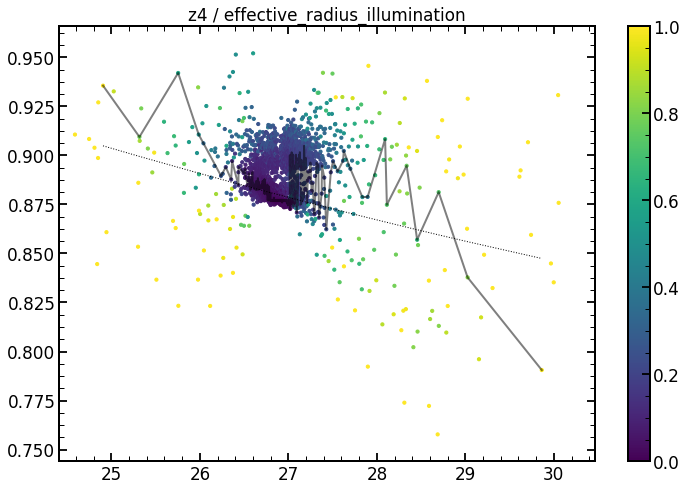

In [89]:
min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,0,20)

plt.figure(figsize=(12,8))

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=10,vmax=1)
plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=2,alpha=0.5,color='black',ls='-')
#plt.plot(min_min_res_split_stack_test[:,0],p1(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
#plt.plot(min_min_res_split_stack_test[:,0],p3(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.xlim(0.98*np.min(min_min_res_split_stack_test[:,0]),np.max(min_min_res_split_stack_test[:,0]*1.02))
plt.title(str(columns[0]) +' / '+ str(columns[20]))
plt.colorbar()

In [ ]:
date='FEB15'
for i in tqdm(range(31)):
    for j in range(31):
        min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,i,j)

        plt.figure(figsize=(12,8))

        surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=10,vmax=1)
        plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=2,alpha=0.5,color='black',ls='-')
        #plt.plot(min_min_res_split_stack_test[:,0],p1(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
        plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
        #plt.plot(min_min_res_split_stack_test[:,0],p3(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
        plt.xlim(0.98*np.min(min_min_res_split_stack_test[:,0]),np.max(min_min_res_split_stack_test[:,0]*1.02))
        plt.title(str(columns[i]) +' / '+ str(columns[j]))
        plt.colorbar()
        
        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/InterDependance/'+str(columns[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
        
        plt.savefig(IMAGES_FOLDER1+str(columns[i])+str(columns[j]))
        plt.clf()

## One combination, same spot, different defocus

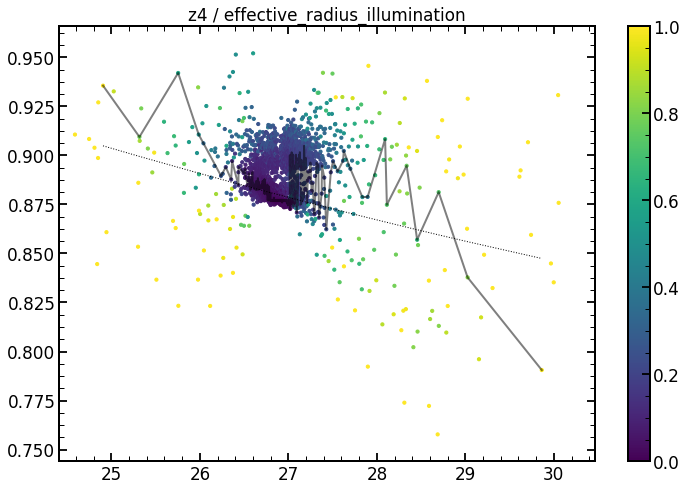

In [91]:
date='Feb15'
obs=str(11790)
single_number='6'
image_index=int(single_number)
eps=5
arc='HgAr'

single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_stack,likechain0_stack=create_stack()

min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,0,20)

plt.figure(figsize=(12,8))

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=10,vmax=1)
plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=2,alpha=0.5,color='black',ls='-')
#plt.plot(min_min_res_split_stack_test[:,0],p1(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
#plt.plot(min_min_res_split_stack_test[:,0],p3(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.xlim(0.98*np.min(min_min_res_split_stack_test[:,0]),np.max(min_min_res_split_stack_test[:,0]*1.02))
plt.title(str(columns[0]) +' / '+ str(columns[20]))
plt.colorbar()

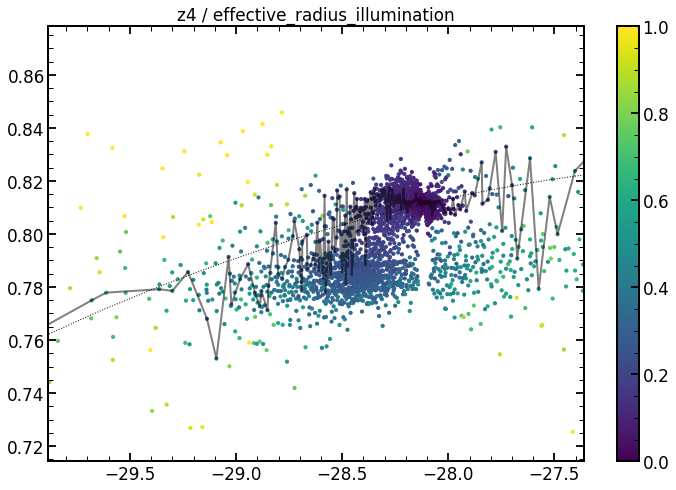

In [95]:
date='Feb15'
obs=str(11736)
single_number='6'
image_index=int(single_number)
eps=5
arc='HgAr'

single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_stack,likechain0_stack=create_stack()

min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,0,20)

plt.figure(figsize=(12,8))

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=10,vmax=1)
plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=2,alpha=0.5,color='black',ls='-')
#plt.plot(min_min_res_split_stack_test[:,0],p1(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
#plt.plot(min_min_res_split_stack_test[:,0],p3(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.xlim(0.98*np.min(min_min_res_split_stack_test[:,0]),np.max(min_min_res_split_stack_test[:,0]*1.02))
plt.title(str(columns[0]) +' / '+ str(columns[20]))
plt.colorbar()

## One combination, many spots

### creation

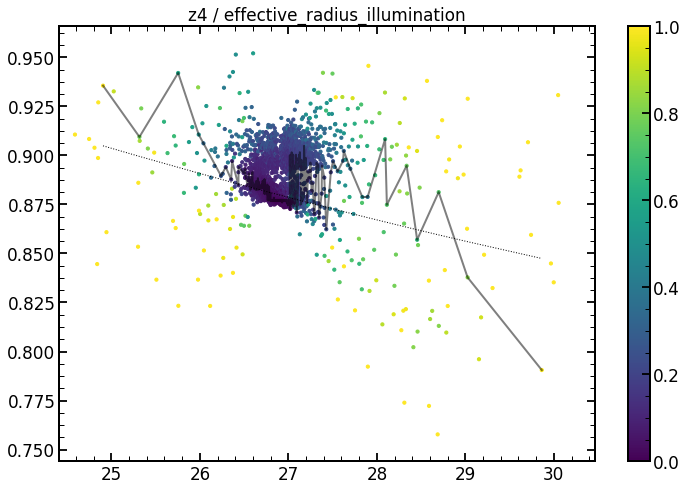

In [96]:
date='Feb15'
obs=str(11790)
single_number='6'
image_index=int(single_number)
eps=5
arc='HgAr'

single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_stack,likechain0_stack=create_stack()

min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,0,20)

plt.figure(figsize=(12,8))

surf = plt.scatter(res_stack[:,0], res_stack[:,1],c=np.log10(res_stack[:,2]),s=10,vmax=1)
plt.plot(min_min_res_split_stack_test[:,0],min_min_res_split_stack_test[:,1],lw=2,alpha=0.5,color='black',ls='-')
#plt.plot(min_min_res_split_stack_test[:,0],p1(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
#plt.plot(min_min_res_split_stack_test[:,0],p3(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')
plt.xlim(0.98*np.min(min_min_res_split_stack_test[:,0]),np.max(min_min_res_split_stack_test[:,0]*1.02))
plt.title(str(columns[0]) +' / '+ str(columns[20]))
plt.colorbar()

In [117]:
list_of_p2=[]
for i in tqdm(results_of_fit_many_HgAr['m35'].index.values):
    try:
        date='Feb15'
        obs=str(11790)
        single_number=results_of_fit_many_HgAr['m35'].index.values[i]
        image_index=int(single_number)
        eps=5
        arc='HgAr'

        single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
        chain0_stack,likechain0_stack=create_stack()

        min_min_res_split_stack_test,res_stack,p1,p2,p3=create_min_min_res_split(chain0_stack,likechain0_stack,0,20)

        list_of_p2.append(p2)
    except:
        pass

100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


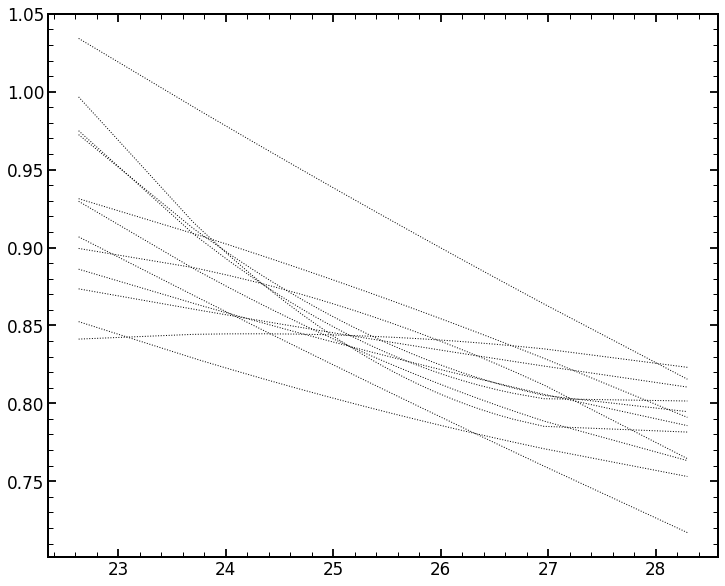

In [118]:
for i in range(len(list_of_p2)):
    p2=list_of_p2[i]
    plt.plot(min_min_res_split_stack_test[:,0],p2(min_min_res_split_stack_test[:,0]),lw=1,alpha=1,color='black',ls=':')


In [113]:
p2

poly1d([-0.00133119,  0.056683  ,  0.27391173])

In [114]:
list_of_p2

[poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),
 poly1d([-0.00133119,  0.056683  ,  0.27391173]),


## Feb28

In [41]:
input_parameters=[]
for arg1 in range(11):
    for arg2 in range(arg1+1,11):
        for i in np.arange(-0.5,0.6,0.1):
            for j in np.arange(-0.5,0.6,0.1):
                allparameters_proposal_int_22_test=np.copy(allparameters_proposal_direct_22)
                allparameters_proposal_int_22_test[arg1+8]=i
                allparameters_proposal_int_22_test[arg2+8]=j
                input_parameters.append(allparameters_proposal_int_22_test) 

In [ ]:
len(input_parameters)

In [43]:
input_parameters[0:4]

[array([   25.46927509,    -0.02124209,    -1.04992786,     0.69853391,
           -0.0641416 ,     0.02247082,    -0.29192157,    -0.18292153,
           -0.5       ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.69976007,
            0.08438785,     0.00028714,    -0.09023436,     0.06347543,
            0.01088842,     0.00008689,     0.51837526,     0.9760724 ,
            0.83827641,    -0.02061162,    -0.06103453,     0.82536987,
            0.08903461,     0.69209871,     1.04051888,    -0.04201478,
        90682.83733571,     2.58159004,     0.00378112,     0.48956584,
            1.81188317,     0.99545856]),
 array([   25.46927509,    -0.02124209,    -1.04992786,     0.69853391,
           -0.0641416 ,     0.02247082,    -0.29192157,    -0.18292153,
           -0.4       ,     0.        ,     0.        ,     0.        ,
            0.        

In [46]:
from multiprocessing import Pool
pool=Pool(processes=4)

Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py"

In [66]:
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,zmax=22)   

zmax: 22


In [67]:
model(input_parameters[0])

-2774.205062587988

In [68]:
out1=pool.map(model,input_parameters[0:3])

In [69]:
out1

[-2774.205062587988, -2763.292248145043, -2755.9531585373834]

In [89]:
res=[]
for arg1 in range(11):
    for arg2 in range(arg1+1,11):
        for i in np.arange(-0.3,0.31,0.1):
            for j in np.arange(-0.3,0.31,0.1):
                res.append([arg1,arg2,i,j])

In [90]:
len(res)

2695

In [82]:
np.arange(-0.3,0.31,0.1)

array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3])

In [88]:
res

[[0, 1, -0.3, -0.3],
 [0, 1, -0.3, -0.19999999999999998],
 [0, 1, -0.3, -0.09999999999999998],
 [0, 1, -0.3, 5.551115123125783e-17],
 [0, 1, -0.3, 0.10000000000000003],
 [0, 1, -0.3, 0.2],
 [0, 1, -0.3, 0.3000000000000001],
 [0, 1, -0.19999999999999998, -0.3],
 [0, 1, -0.19999999999999998, -0.19999999999999998],
 [0, 1, -0.19999999999999998, -0.09999999999999998],
 [0, 1, -0.19999999999999998, 5.551115123125783e-17],
 [0, 1, -0.19999999999999998, 0.10000000000000003],
 [0, 1, -0.19999999999999998, 0.2],
 [0, 1, -0.19999999999999998, 0.3000000000000001],
 [0, 1, -0.09999999999999998, -0.3],
 [0, 1, -0.09999999999999998, -0.19999999999999998],
 [0, 1, -0.09999999999999998, -0.09999999999999998],
 [0, 1, -0.09999999999999998, 5.551115123125783e-17],
 [0, 1, -0.09999999999999998, 0.10000000000000003],
 [0, 1, -0.09999999999999998, 0.2],
 [0, 1, -0.09999999999999998, 0.3000000000000001],
 [0, 1, 5.551115123125783e-17, -0.3],
 [0, 1, 5.551115123125783e-17, -0.19999999999999998],
 [0, 1, 5.55